# 2. EDA и генерация признаков

In [2]:
import os
import pandas as pd
import pickle
import numpy as np
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split

%matplotlib inline
# warnings.filterwarnings('ignore')

In [33]:
def cut_outliers(col: pd.Series) -> pd.DataFrame:
    q_95 = col.quantile(0.9)
    q_5 = col.quantile(0.5)
    q_05 = col.quantile(0.05)
#     columns = [f'{col.name}_q95', f'{col.name}_med']
    tmp_df = col.where(col <= q_95, q_95).where(col >= 0.05, q_05).to_frame(name = f'{col.name}_q95')
    tmp_df[f'{col.name}_med'] = col.where((col <= q_95) & (col >= q_05), q_5)
    
    return tmp_df

def get_describe(col: pd.Series, bins=40):
    print(col.name)
    print(f'Ассиметрия: {col.skew()}, эксцесс: {col.kurt()}')
    print(f'Корреляция с таргетом: {col.corr(X_train.target)}')
    
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,3,1)
    sns.boxplot(col, whis=1.5)

    ax2 = fig.add_subplot(1,3,2)     
    sns.distplot(col, bins=bins, fit=norm)

    ax3 = fig.add_subplot(1,3,3)
    res = stats.probplot(col, plot=plt)
    plt.show()

- к датасету можно сделать много интересных запросов, но надо выбирать
- первым делом уберу все столбцы за 2019 год, 
- предсказываю статус организации на 2022-2023, учитывая данные за 2021 и 2020
- вообще говоря, разные данные даже из одного источника обновляются в разное время - так что со временем может быть немного сложно


In [5]:
with open('../parsed_data/data.pickle', 'rb') as f:
    data = pickle.load(f)

In [6]:
col_2019 = [col for col in data.columns if '2019' in col]
col_2019

['2019_1150',
 '2019_1170',
 '2019_1210',
 '2019_1230',
 '2019_1250',
 '2019_1600',
 '2019_1350',
 '2019_1360',
 '2019_1300',
 '2019_1520',
 '2019_1700',
 '0102_2019',
 '0103_2019',
 '0105_2019',
 'breach_2019',
 'AI92_cost_2019',
 'AI92_volume_2019',
 'AI95_cost_2019',
 'AI95_volume_2019',
 'AI98_cost_2019',
 'AI98_volume_2019',
 'cons_basket_child_2019',
 'cons_basket_pens_2019',
 'cons_basket_working_age_2019',
 'diesel_cost_2019',
 'diesel_volume_2019']

In [7]:
data.drop(columns=col_2019, axis=1, inplace = True)

- удаляем столбец region - там есть пропуски, тогда как в столбце region_code пропусков нет
- можно было бы посмотреть расхождения, но...

In [8]:
data.drop(columns='region', axis=1, inplace = True)

- не знаю, что это + уникальное значение только одно
- м.б, как раз ЮЛ или ФЛ?

In [9]:
data.subj_form.unique()

array([1], dtype=int8)

In [10]:
data.drop(columns='subj_form', axis=1, inplace = True)

In [11]:
data.columns.size

96

- таргет - объединяю LIQUIDATION_STAGE и INACTIVE (т.к. и так большой дисбаланс)

In [12]:
data.statusCode.value_counts(normalize=True)

ACTIVE                  0.978111
LIQUIDATION_STAGE       0.016796
INACTIVE                0.002975
REORGANIZATION_STAGE    0.002118
Name: statusCode, dtype: float64

In [13]:
data['target'] = data.statusCode.replace({'ACTIVE': 0, 'REORGANIZATION_STAGE': 0, 'LIQUIDATION_STAGE': 1, 'INACTIVE': 1})

In [14]:
data['target'].value_counts(normalize=True)

0    0.980229
1    0.019771
Name: target, dtype: float64

- перемешиваем и бъём на трейн и тест

In [15]:
# заодно убираю inn и short_name!
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 2:], 
                                                    data.target, 
                                                    random_state=42, 
                                                    shuffle=True, 
                                                    stratify=data.target,
                                                    test_size=0.3 )

In [35]:
X_train.head()

index          city settlement   okved2  okopf statusCode  \
797919  125252        Москва       None  46.73.6  12300     ACTIVE   
691284  620141  Екатеринбург       None    55.10  12300     ACTIVE   
475119  109651        Москва       None     46.4  12300     ACTIVE   
24310   117525        Москва       None    46.14  12300     ACTIVE   
866703  660061    Красноярск       None    71.11  12300     ACTIVE   

       registrationDate  authorizedCapital  2021_1150  2020_1150  ...  \
797919       2020-02-25            10000.0        NaN        NaN  ...   
691284       2014-01-29            10000.0        NaN        NaN  ...   
475119       2008-08-18            10000.0        NaN        NaN  ...   
24310        2008-03-18            20000.0        NaN        NaN  ...   
866703       2016-10-12            15000.0      151.0        NaN  ...   

        cons_basket_working_age_2020  cons_basket_working_age_2021  \
797919                   6621.530762                   7592.104004   
691284                   5262.521484                   5943.590820   
475119                   6621.530762                   7592.104004   
24310                    6621.530762                   7592.104004   
866703                   5894.688965                   6584.278320   

        diesel_cost_2020  diesel_cost_2021  diesel_volume_2020  \
797919         47.165710         49.359341        1.146123e+06   
691284         48.367622         50.376961        3.361229e+05   
475119         47.165710         49.359341        1.146123e+06   
24310          47.165710         49.359341        1.146123e+06   
866703         51.152733         52.567753        9.352627e+04   

        diesel_volume_2021  region_population  city_population  \
797919        1.241958e+06           13010112       13010112.0   
691284        3.095252e+05            4268998        1588665.0   
475119        1.241958e+06           13010112       13010112.0   
24310         1.241958e+06           13010112       13010112.0   
866703        1.225199e+05            2856971        1188533.0   

        settlement_population  target  
797919                    NaN       0  
691284                    NaN       0  
475119                    NaN       0  
24310                     NaN       0  
866703                    NaN       0  

[5 rows x 95 columns]

#### Описание полей:

        index - почтовый инедкс
        city - город
        settlement - населённый пункт
        okved2 - код по общерос. классификатор видов эк. деятельности 2
        okopf - код по общерос. классификатор орг-правовых форм собственности
        statusCode - статус организации: ACTIVE, LIQUIDATION_STAGE, INACTIVE, REORGANIZATION_STAGE
        registrationDate - дата регистрации (bo.nalog.ru)
        authorizedCapital - уставный капитал
        _1150 - _1700 - данные бух. учёта за 21 и 20 гг.
        _2110 - _2400 - аналогично фин. результат
        n_employees - среднесписочное число работников
        is_soc_enterprise - относится ли предприятие к числу социальных (0, 1 - нет, да)
        newly_establ - является ли вновь созданным (0, 1)
        subj_cat - категория субъекта (1, 2, 3 - микро, малое или среднее предприятие)
        subj_form - не знаю, что, уникальное только одно - удаляем
        inclusion_date - дата включения в реестр мсп
        region_code - код региона
        n_okovd_add - число кодов доп. деятельностей = число доп. деятельностей
        n_licenses - число лицензий
        n_products - число производимых продуктов
        is_high_tech - является ли высокотехнологичным
        n_contracts - число контрактов (информация о которых предоставляется в соотв с ФЗ...)
        n_agreements - число договоров (в соотв с ФЗ...)
        0102_ - 0105_ - сумма поддержки за 20 и 21 гг.
        breach_ - сумма нарушений условий поддержки за 20 и 21 гг.
        arrears - налоговые задолженности по состоянию на 2021 г
        penalties - пени
        fines - штрафы
        fine_amount - сумма штрафа за налоговые нарушения
        disqual_person - есть ли дисквалифицированные персоны в администрации (0, 1)
        вид топлива_cost_год - средняя стоимость топлива за 20 и 21 год2_volume_2020             
        вид топлива_volume_год - средний объём продажи за год      
        cons_basket_child_год - средняя стоимость потребительской корзины для детей  
        cons_basket_pens_год - --//-- для пенсионеров
        cons_basket_working_age_год - --//-- для трудоспособных граждан
        region_population - численность населения региона
        city_population - численность населения города (населённого пункта)      
        settlement_population - численность населённого пункта   

- 3 типа данных: категория, число, дата

- заполняю простые пропуски (0 для фин. и бух. отчётов):

        - на самом деле, есть разница: у кого-то эти поля есть, но равны 0, а у кого-то их нет
        - заполнять 0 - терять часть информации
        - так, например, для n_employees чуть полезнее оказалось заполнить пропуски -1, а не 0

In [36]:
float_cols = X_train.select_dtypes(include='float32').columns.tolist()
# вот в этих столбцах заменяю None на 0
float_cols[1:37]

['2021_1150',
 '2020_1150',
 '2021_1170',
 '2020_1170',
 '2021_1210',
 '2020_1210',
 '2021_1230',
 '2020_1230',
 '2021_1250',
 '2020_1250',
 '2021_1600',
 '2020_1600',
 '2021_1350',
 '2020_1350',
 '2021_1360',
 '2020_1360',
 '2021_1300',
 '2020_1300',
 '2021_1520',
 '2020_1520',
 '2021_1700',
 '2020_1700',
 '2021_2110',
 '2020_2110',
 '2021_2120',
 '2020_2120',
 '2021_2330',
 '2020_2330',
 '2021_2340',
 '2020_2340',
 '2021_2350',
 '2020_2350',
 '2021_2410',
 '2020_2410',
 '2021_2400',
 '2020_2400']

In [37]:
for col in float_cols[1:37]:
    X_train[col] = X_train[col].fillna(0)

## 1. Признаки (пропуски, выбросы)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936073 entries, 797919 to 1006195
Data columns (total 95 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   index                         933180 non-null  object        
 1   city                          852413 non-null  object        
 2   settlement                    97258 non-null   object        
 3   okved2                        935391 non-null  object        
 4   okopf                         936073 non-null  object        
 5   statusCode                    936073 non-null  object        
 6   registrationDate              936072 non-null  datetime64[ns]
 7   authorizedCapital             897200 non-null  float32       
 8   2021_1150                     936073 non-null  float32       
 9   2020_1150                     936073 non-null  float32       
 10  2021_1170                     936073 non-null  float32       
 11  2020_11

### 1.1. target

In [39]:
X_train.statusCode.value_counts(normalize=True)

ACTIVE                  0.978121
LIQUIDATION_STAGE       0.016762
INACTIVE                0.003009
REORGANIZATION_STAGE    0.002108
Name: statusCode, dtype: float64

In [40]:
interest = X_train.statusCode.value_counts(normalize=True)
# меняем местами 2 и 3
interest[2], interest[3] = interest[3], interest[2]

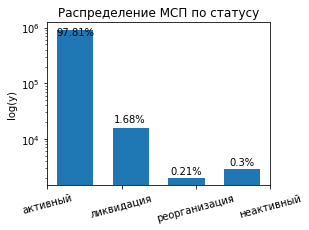

In [45]:
plt.figure(figsize=(4, 3))
for i, el in zip(zip([0.195, 0.395, 0.59, 0.795], [0.9, 0.5, 0.26, 0.3]), interest):
    plt.annotate(f'{round(el*100, 2)}%', (i[0], i[1]), xycoords='figure fraction')
plt.title('Распределение МСП по статусу')
plt.hist(X_train.statusCode, bins=4, rwidth=0.65)
plt.yscale('log')
plt.ylabel("log(y)");

### 1.2. Категориальные

In [54]:
cat_columns = X_train.select_dtypes(include='object').columns.tolist()
cat_columns += ['is_soc_enterprise', 'newly_establ', 'subj_cat', 'region_code', 'is_high_tech',
                'disqual_person', ]
cat_columns

['index',
 'city',
 'settlement',
 'okved2',
 'okopf',
 'statusCode',
 'is_soc_enterprise',
 'newly_establ',
 'subj_cat',
 'region_code',
 'is_high_tech',
 'disqual_person']

In [55]:
X_train.describe(include='object')

index    city settlement  okved2   okopf statusCode
count   933180  852413      97258  935391  936073     936073
unique   25416    1234      16395    2213      33          4
top     105082  Москва  Парголово   41.20   12300     ACTIVE
freq      1961  155434        749   52770  884842     915593

- почтовых индексов много - мб несколько индексов для 1 города, можно по частоте оргарнизаций сделать бины
- регионов не так много - их можно сделать onehot + численность по регионам - сильно коррелирует с численностью по нас. пунктам
- городов слишком много для onehot 
- okved2 - достаточно много, можно укрупнить категории, отбросив часть за .
- okopf - немного
- 'is_soc_enterprise', 'newly_establ', 'is_high_tech', 'disqual_person' - бинарные
- subj_cat - можно использовать и как ранговую шкалу

#### 1.2.1. index = почтовый индекс

- по индексу можно присоединить какую-нибудь дополнительную информацию

In [57]:
X_train['index'].nunique()

25416

In [58]:
X_train['index'].isnull().sum()

2893

- теоретически можно было бы более осмысленно заполнить пропуски, но...

In [59]:
X_train.loc[X_train['index'].isna()]

index              city       settlement   okved2  okopf  \
665584  None            Тюмень             None    25.99  12300   
936771  None             Пермь             None    77.39  12300   
481920  None       Калининград             None    56.10  12300   
160344  None        Прохладный             None    01.11  12300   
314344  None           Нальчик             None    80.10  12300   
...      ...               ...              ...      ...    ...   
387164  None            Якутск             None    01.70  12300   
405097  None          Подольск  Железнодорожный    62.09  12300   
929436  None  Великий Новгород             None  68.20.2  12300   
125855  None             Томск             None    38.11  12300   
32668   None        Чайковский             None    41.20  12300   

                  statusCode registrationDate  authorizedCapital  2021_1150  \
665584                ACTIVE       2014-04-09            10000.0     4297.0   
936771                ACTIVE       2000-02-28         10131000.0     4186.0   
481920                ACTIVE       2006-04-17           200000.0      936.0   
160344                ACTIVE       2021-11-19         10000000.0      480.0   
314344                ACTIVE       2005-02-07           100000.0        0.0   
...                      ...              ...                ...        ...   
387164                ACTIVE       2000-02-17           190000.0        0.0   
405097                ACTIVE       2016-10-12            10000.0      505.0   
929436                ACTIVE       2000-07-10           490000.0     6883.0   
125855                ACTIVE       2009-03-12            10000.0     8075.0   
32668   REORGANIZATION_STAGE       2005-08-30            12000.0        0.0   

        2020_1150  ...  cons_basket_working_age_2020  \
665584      806.0  ...                   5311.635254   
936771     7187.0  ...                   4884.756348   
481920     1235.0  ...                   6027.332520   
160344        0.0  ...                   5089.250000   
314344        2.0  ...                   5089.250000   
...           ...  ...                           ...   
387164        0.0  ...                   7618.674805   
405097      391.0  ...                   6004.048340   
929436     7900.0  ...                   5164.585449   
125855    21074.0  ...                   5029.795410   
32668         0.0  ...                   4884.756348   

        cons_basket_working_age_2021  diesel_cost_2020  diesel_cost_2021  \
665584                   6041.088867         48.787075         50.840218   
936771                   5544.374512         48.920765         51.262028   
481920                   6686.780273         49.178497         51.489040   
160344                   6015.302734         46.968143         47.117012   
314344                   6015.302734         46.968143         47.117012   
...                              ...               ...               ...   
387164                   8515.986328         58.757076         59.619396   
405097                   6792.406738         46.640190         48.816631   
929436                   5810.568359         48.133415         50.459755   
125855                   5731.980957         49.614536         51.924686   
32668                    5544.374512         48.920765         51.262028   

        diesel_volume_2020  diesel_volume_2021  region_population  \
665584        9.080044e+04        1.083825e+05            3823910   
936771        1.738828e+05        1.818318e+05            2532405   
481920        1.863601e+05        2.383083e+05            1029966   
160344        1.608176e+04        2.225768e+04             904200   
314344        1.608176e+04        2.225768e+04             904200   
...                    ...                 ...                ...   
387164        2.881768e+04        3.612271e+04             995686   
405097        1.383346e+06        1.870944e+06            8524665   
929436        7.348181e+04        9.336040e+04

- есть ещё такие

In [61]:
X_train.loc[X_train['index'] == ' '].shape

(61, 95)

- новый признак - число организаций по индексу - **n_org_per_index**

In [62]:
tmp_series = X_train['index'].fillna(0).replace({' ': 0}).astype('int').value_counts()

In [63]:
%%time
X_train['n_org_per_index'] = X_train['index'].fillna(0).replace({' ': 0}).astype('int').replace(tmp_series)

Wall time: 46.3 s


In [64]:
X_train.n_org_per_index.nunique()

683

n_org_per_index
Ассиметрия: 2.3942894010848548, эксцесс: 8.471552883405105
Корреляция с таргетом: 0.0008738697423520463


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


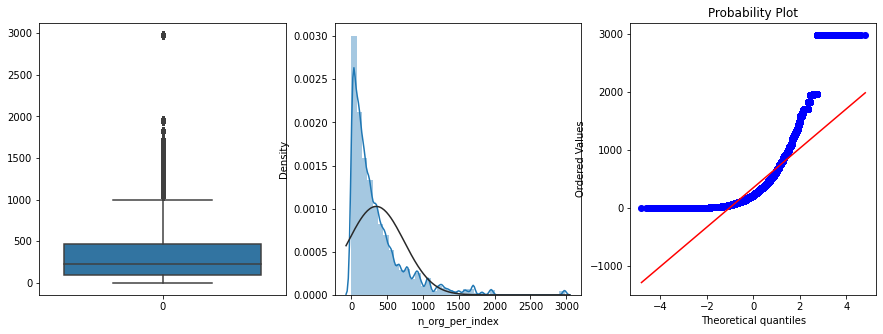

In [67]:
get_describe(X_train.n_org_per_index)

- форма распределения как раз понятна - длинный правый хвост, максимум - 80-90 организаций на индекс 
- с логарифмом смотрится лучше

In [68]:
X_train.n_org_per_index.min()

1

n_org_per_index
Ассиметрия: -1.0345533035126193, эксцесс: 1.3144731379465067
Корреляция с таргетом: -0.0037428056663834485


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


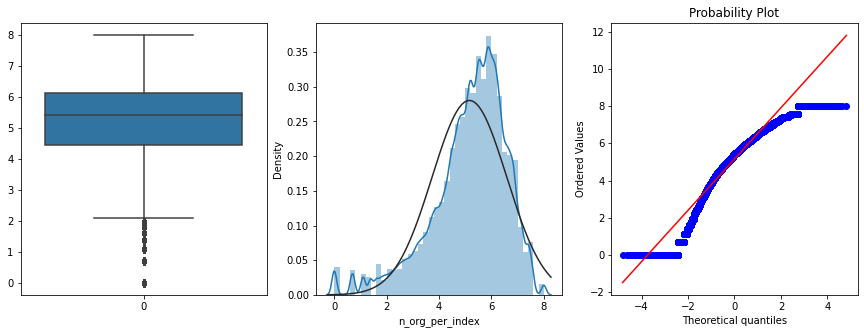

In [70]:
get_describe(np.log(X_train.n_org_per_index))

- новый признак - логарифм - **n_org_per_index_log**

In [71]:
X_train['n_org_per_index_log'] = np.log(X_train.n_org_per_index)

- выбросы

In [72]:
X_train.loc[X_train.n_org_per_index > X_train.n_org_per_index.quantile(0.95)].shape

(46110, 97)

- заполняю выбросы верхним квантилем - **n_org_per_index_q95**

In [73]:
q_95 = X_train.n_org_per_index.quantile(0.95)
X_train['n_org_per_index_q95'] = X_train.n_org_per_index.where(X_train.n_org_per_index < q_95, q_95)

In [74]:
X_train.n_org_per_index_q95.corr(X_train.target)

0.0013624755064081397

- новый признак - квантили для число организаций по индексу - **n_org_per_index_quant**
- мб основой для других признаков или визуализаций

In [75]:
X_train['n_org_per_index_quant'] = pd.qcut(X_train.n_org_per_index, q=10, labels=range(10))

#### 1.2.2. city и settlement

- для них уже есть численность
- понятно, что все признаки,связанные с адресом, будут сильно коррелировать => отбор

In [76]:
X_train.city.isna().sum(), X_train.settlement.isna().sum()

(83660, 838815)

In [77]:
X_train['locality'] = X_train.settlement.where(~X_train.settlement.isna(), X_train.city)

In [78]:
X_train.locality.isna().sum(), X_train.locality.nunique()

(8909, 17363)

- замена на число организаций будет отрабатывать слишком долго (т.к. поиск по строке)

#### 1.2.3. region_code

- их немного, они - цифра, делаем всё то же самое, что для индекса

In [79]:
X_train.region_code.isnull().sum(), X_train.region_code.nunique()

(0, 85)

- новый признак - число организаций по регионам: **n_org_per_region_code**

In [81]:
tmp_series = X_train.region_code.value_counts()
X_train['n_org_per_region_code'] = X_train.region_code.replace(tmp_series)
X_train.n_org_per_region_code.nunique()

84

n_org_per_region_code
Ассиметрия: 1.3345598597150012, эксцесс: 0.20413777824464807
Корреляция с таргетом: -0.001416537705544522


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


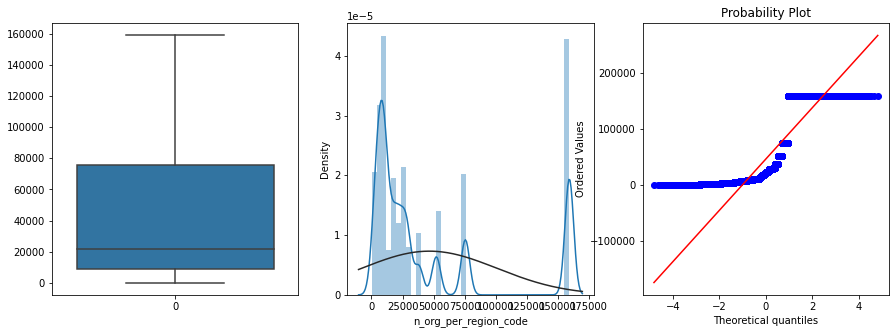

In [82]:
get_describe(X_train.n_org_per_region_code)

- логарифм - **n_org_per_region_code_log**

In [83]:
X_train['n_org_per_region_code_log'] = np.log(X_train.n_org_per_region_code)

n_org_per_region_code_log
Ассиметрия: 0.03696144315055017, эксцесс: -0.6843871200112357
Корреляция с таргетом: -0.0026726661736842317


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


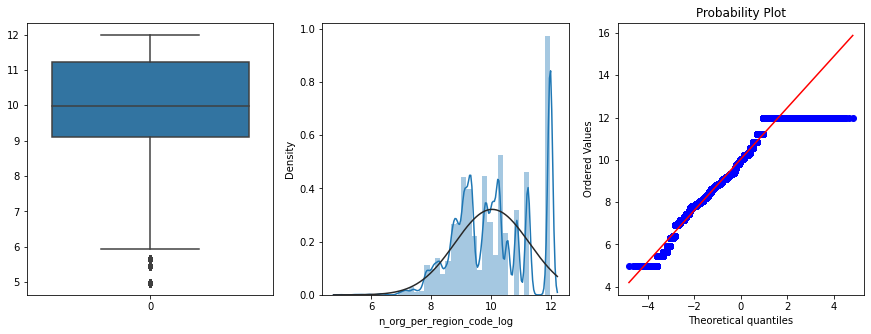

In [84]:
get_describe(X_train.n_org_per_region_code_log)

- выбросы - два варианта заполнения: медиана и граничные квантили

In [85]:
X_train = pd.concat([X_train, cut_outliers(X_train.n_org_per_region_code)], axis=1)

In [86]:
X_train.shape

(936073, 104)

- новый признак - квантили для число организаций по индексу - **n_org_per_region_code_quant**

In [87]:
X_train['n_org_per_region_code_quant'] = pd.qcut(X_train.n_org_per_region_code, q=11, labels=range(10), duplicates='drop')

#### 1.2.4. okved2

- здесь можно уменьшить число категорий, укрупнив их - обрежем до первой точки

In [89]:
X_train.okved2.nunique()

2213

In [90]:
X_train.okved2.unique()

array(['46.73.6', '55.10', '46.4', ..., '38.22.11', '30.30.42', '10.86.2'],
      dtype=object)

- пропуски

In [91]:
X_train.okved2.isnull().sum()

682

их немного, просто заменим самым частым

In [97]:
X_train.okved2.value_counts().index[0]

'41.20'

In [98]:
X_train.okved2.fillna(X_train.okved2.value_counts().index[0], inplace=True)

- сперва обрежем до второй точки и посмотрим

In [99]:
X_train['okved2_2'] = X_train.okved2.apply(lambda x: tuple(x.split('.')[:2]))
X_train.okved2_2.nunique()

813

- обрежем до первой точки - **okved2_1**

In [100]:
# сразу в число, так будет быстрее
X_train['okved2_1'] = X_train.okved2.apply(lambda x: int(x.split('.')[0]))

In [101]:
X_train.okved2_1.nunique()

88

In [111]:
X_train.okved2_1.value_counts(normalize=True)

46    0.198711
68    0.085823
47    0.072586
41    0.066946
43    0.052741
        ...   
39    0.000051
92    0.000049
97    0.000047
98    0.000006
99    0.000003
Name: okved2_1, Length: 88, dtype: float64

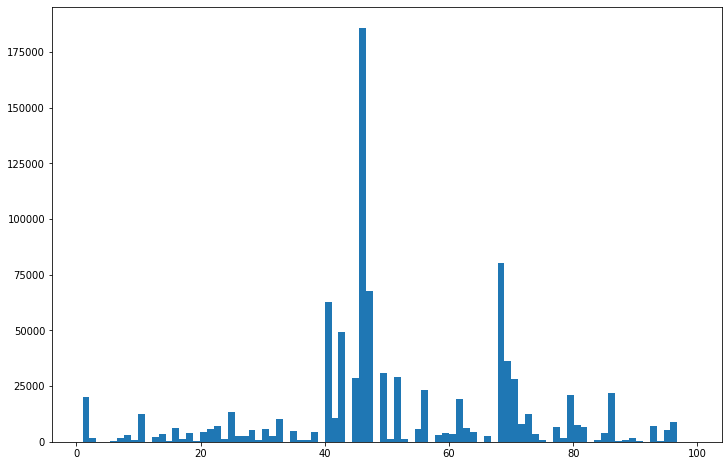

In [113]:
plt.figure(figsize=(12, 8))
plt.hist(X_train.okved2_1, bins=88);
# plt.yscale('log');

- число организаций по okovd2_1 - **n_org_per_okved2**

In [114]:
X_train['n_org_per_okved2'] = X_train.okved2_1.replace(X_train.okved2_1.value_counts())

n_org_per_okved2
Ассиметрия: 1.0641533211029701, эксцесс: -0.3735533720919819
Корреляция с таргетом: 0.001633926224545389


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


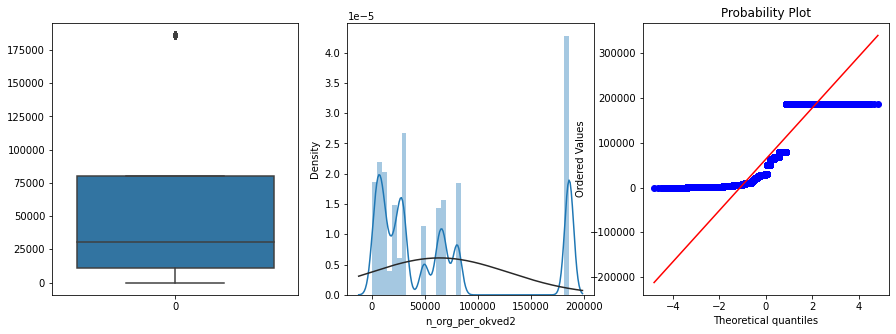

In [118]:
get_describe(X_train.n_org_per_okved2)

- число организаций по okovd2 по региону **n_org_per_okved2_per_region**
- тут чуть сложнее группировка

In [115]:
tmp = X_train[['region_code', 'okved2_1']].value_counts().reset_index().rename(columns={0: 'n_org_per_okved2_per_region'})
tmp.head(3)

region_code  okved2_1  n_org_per_okved2_per_region
0           77        46                        35946
1           78        46                        16313
2           77        68                        13439

- и мержим по двум столбцам

In [116]:
X_train = X_train.merge(tmp, how='left', on=['region_code', 'okved2_1'])

In [117]:
X_train.n_org_per_okved2_per_region.isna().sum()

0

n_org_per_okved2_per_region
Ассиметрия: 3.533865577365468, эксцесс: 12.546971449118704
Корреляция с таргетом: -0.0007508909712874278


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


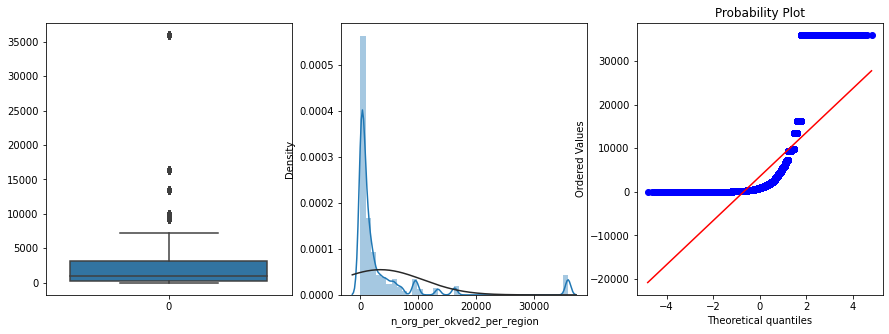

In [119]:
get_describe(X_train.n_org_per_okved2_per_region)

- и логарифм

n_org_per_okved2_per_region
Ассиметрия: -0.15500936554461012, эксцесс: -0.15475304600285567
Корреляция с таргетом: -0.0014159918569823231


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


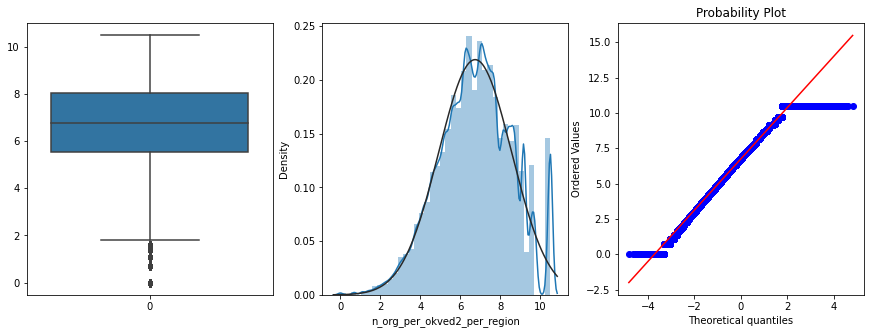

In [121]:
get_describe(np.log(X_train.n_org_per_okved2_per_region))

In [123]:
X_train['n_org_per_okved2_per_region_log'] = np.log(X_train.n_org_per_okved2_per_region)

- и выбросы

In [124]:
X_train = pd.concat([X_train, cut_outliers(X_train.n_org_per_okved2_per_region)], axis=1)

- число организаций по okovd2 по locality  **n_org_per_okved2_per_locality**

In [125]:
tmp = X_train[['locality', 'okved2_1']].value_counts().reset_index().rename(columns={0: 'n_org_per_okved2_per_locality'})
tmp.head(3)

locality  okved2_1  n_org_per_okved2_per_locality
0           Москва        46                          34805
1  Санкт-Петербург        46                          15346
2           Москва        68                          12931

- но здесь есть пропуски для locality, значит будут пропуски и в новом столбце

In [126]:
X_train.locality.isna().sum()

8909

- просто заполним медианой по okoved

In [128]:
tmp1 = tmp.groupby('okved2_1')['n_org_per_okved2_per_locality'].mean()
tmp1

okved2_1
1     2.255022
2     2.572684
3     2.073090
5     2.180328
6     3.059701
        ...   
95    7.513067
96    8.812500
97    1.375000
98    1.500000
99    1.000000
Name: n_org_per_okved2_per_locality, Length: 88, dtype: float64

In [129]:
X_train = X_train.merge(tmp, how='left', on=['locality', 'okved2_1'])

In [130]:
X_train.n_org_per_okved2_per_locality.isna().sum()

8909

- заполняем

In [131]:
cond = X_train.n_org_per_okved2_per_locality.isna()
X_train.loc[cond, 'n_org_per_okved2_per_locality'] = X_train.loc[cond, 'okved2_1'].replace(tmp1)

In [132]:
X_train.n_org_per_okved2_per_locality.isna().sum()

0

n_org_per_okved2_per_locality
Ассиметрия: 3.7635544439106057, эксцесс: 14.01173024994965
Корреляция с таргетом: 0.00011633647658572578


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


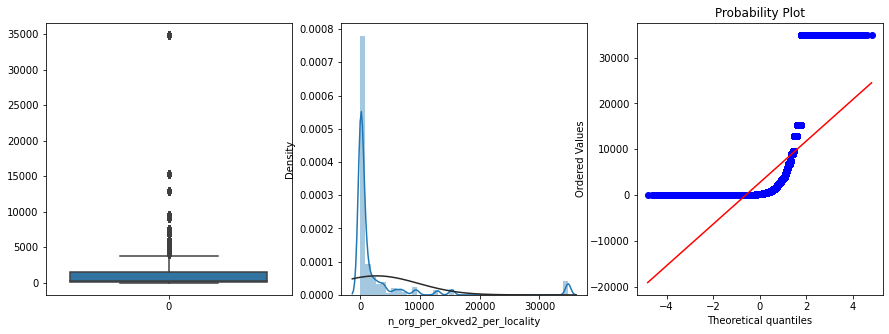

In [134]:
get_describe(X_train.n_org_per_okved2_per_locality)

- логарифм

n_org_per_okved2_per_locality
Ассиметрия: -0.18737030023551415, эксцесс: -0.7644746369555726
Корреляция с таргетом: -0.0019086785956155482


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


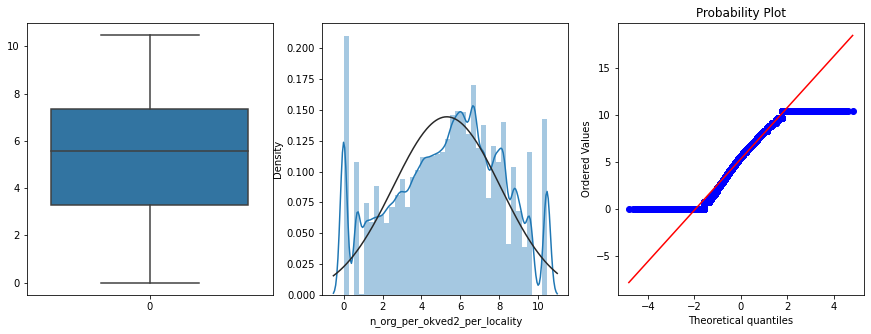

In [135]:
get_describe(np.log(X_train.n_org_per_okved2_per_locality))

In [137]:
X_train['n_org_per_okved2_per_locality_дщп'] = np.log(X_train.n_org_per_okved2_per_locality)

- выбросы

In [138]:
X_train = pd.concat([X_train, cut_outliers(X_train.n_org_per_okved2_per_locality)], axis=1)

#### 1.2.5. okopf

- уникальных немного
- пропуски уже заполнены нулями

In [139]:
X_train.okopf.nunique()

33

In [140]:
X_train.okopf.isna().sum()

0

In [142]:
X_train.okopf.value_counts(normalize=True)

12300    0.945270
0        0.015587
12267    0.012143
20101    0.010147
20102    0.004670
20100    0.003112
15300    0.001770
14100    0.001716
12247    0.001464
20107    0.001363
14200    0.000633
20109    0.000519
20112    0.000366
14153    0.000277
20110    0.000231
20111    0.000166
12200    0.000109
20115    0.000105
14000    0.000089
11064    0.000068
14154    0.000065
11051    0.000047
14155    0.000036
20700    0.000014
20105    0.000011
20104    0.000006
20116    0.000006
20200    0.000002
20702    0.000002
20108    0.000002
20103    0.000001
20716    0.000001
20600    0.000001
Name: okopf, dtype: float64

число оганизаций по okopf - **n_org_per_okopf**
- всего два пика - неизвестная форма (0) и - ООО (12300)

In [143]:
X_train['n_org_per_okopf'] = X_train.okopf.replace(X_train.okopf.value_counts())

n_org_per_okopf
Ассиметрия: -3.9155205000661137, эксцесс: 13.331983131813384
Корреляция с таргетом: 0.0009681765897715279


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


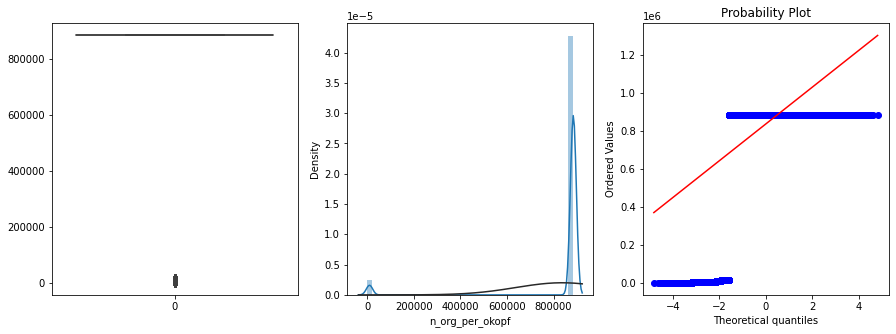

In [144]:
get_describe(X_train.n_org_per_okopf)

- число организаций по регион-okopf - **n_org_per_okopf_region**

In [145]:
tmp = X_train[['region_code', 'okopf']].value_counts().reset_index().rename(columns={0: 'n_org_per_okopf_region'})
tmp.head(3)

region_code  okopf  n_org_per_okopf_region
0           77  12300                  151779
1           78  12300                   72337
2           50  12300                   49145

In [146]:
X_train = X_train.merge(tmp, how='left', on=['region_code', 'okopf'])

In [147]:
X_train.n_org_per_okopf_region.isna().sum()

0

- распределение чуть разнообразнее

n_org_per_okopf_region
Ассиметрия: 1.3879823448268838, эксцесс: 0.3729099531719462
Корреляция с таргетом: -0.0011528691182393735


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


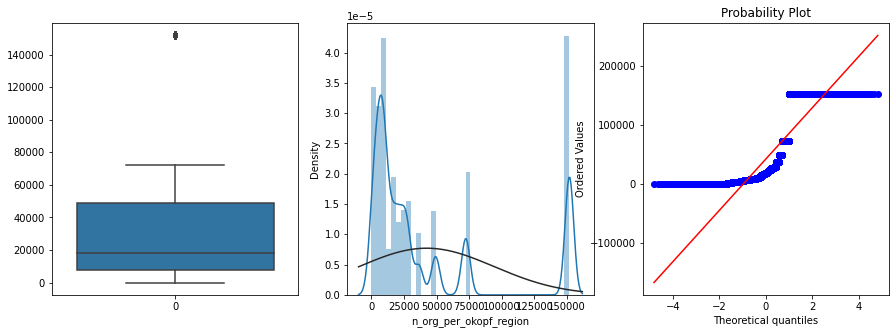

In [148]:
get_describe(X_train.n_org_per_okopf_region)

- логарифм

n_org_per_okopf_region
Ассиметрия: -1.2736752217224996, эксцесс: 3.261928079392663
Корреляция с таргетом: -0.0032865009300256493


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


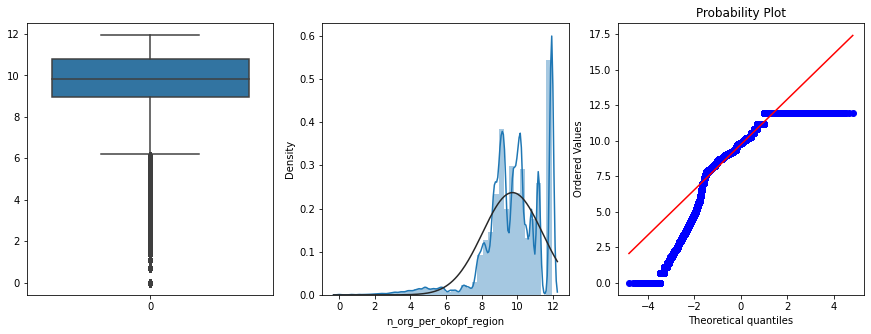

In [150]:
get_describe(np.log(X_train.n_org_per_okopf_region))

- не очень красиво, но посмотрим

In [ ]:
X_train['n_org_per_okopf_region_log'] = np.log(X_train.n_org_per_okopf_region)

- выбросы

In [149]:
X_train = pd.concat([X_train, cut_outliers(X_train.n_org_per_okopf_region)], axis=1)

- число организаций по locality-okopf - **n_org_per_okopf_locality**
- тоже будут пропуски

In [151]:
tmp = X_train[['locality', 'okopf']].value_counts().reset_index().rename(columns={0: 'n_org_per_okopf_locality'})
tmp.head(3)

locality  okopf  n_org_per_okopf_locality
0           Москва  12300                    146390
1  Санкт-Петербург  12300                     67334
2     Екатеринбург  12300                     25515

In [152]:
tmp1 = tmp.groupby('okopf')['n_org_per_okopf_locality'].mean()

- соединяем

In [153]:
X_train = X_train.merge(tmp, how='left', on=['locality', 'okopf'])
X_train.n_org_per_okopf_locality.isna().sum()

8909

- заполняем пропуски

In [154]:
cond = X_train.n_org_per_okopf_locality.isna()
X_train.loc[cond, 'n_org_per_okopf_locality'] = X_train.loc[cond, 'okopf'].replace(tmp1)
X_train.n_org_per_okopf_locality.isna().sum()

0

n_org_per_okopf_locality
Ассиметрия: 1.5615908919284536, эксцесс: 0.7240195338325073
Корреляция с таргетом: 0.00021347959313942024


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


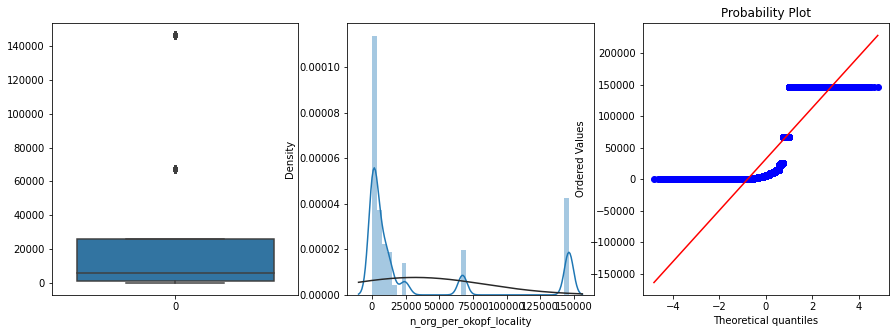

In [155]:
get_describe(X_train.n_org_per_okopf_locality)

- выбросы

In [156]:
X_train = pd.concat([X_train, cut_outliers(X_train.n_org_per_okopf_locality)], axis=1)

#### 1.2.6. 'is_soc_enterprise', 'newly_establ', 'is_high_tech', 'disqual_person' - бинарные

In [157]:
bin_col = ['is_soc_enterprise', 'newly_establ', 'is_high_tech', 'disqual_person']

Пропуски: 0
Баланс классов: 
0    0.998625
1    0.001375
Name: is_soc_enterprise, dtype: float64
Корреляция с тарегтом: -0.004648362671437081


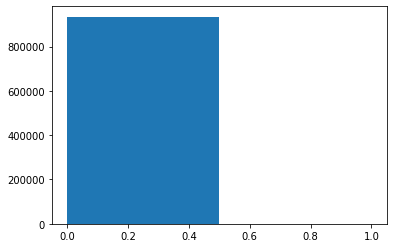

Пропуски: 0
Баланс классов: 
0    0.996531
1    0.003469
Name: newly_establ, dtype: float64
Корреляция с тарегтом: -0.0028970641545429565


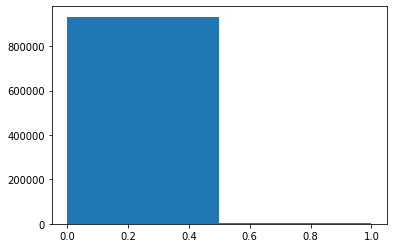

Пропуски: 0
Баланс классов: 
0    0.999922
1    0.000078
Name: is_high_tech, dtype: float64
Корреляция с тарегтом: -0.0012542175164981428


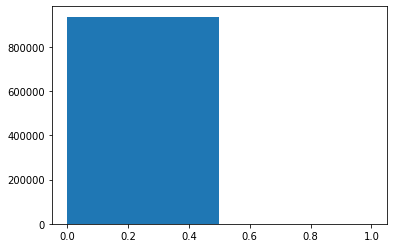

Пропуски: 0
Баланс классов: 
0    0.999885
1    0.000115
Name: disqual_person, dtype: float64
Корреляция с тарегтом: 0.004190157880449358


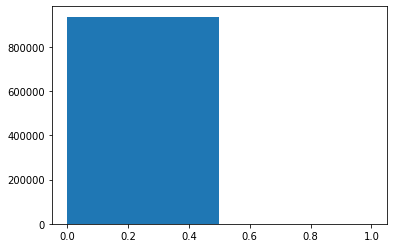

In [158]:
for col in bin_col:
    print(f'Пропуски: {X_train[col].isnull().sum()}\nБаланс классов: ')
    print(X_train[col].value_counts(normalize=True))
    print(f'Корреляция с тарегтом: {X_train[col].corr(X_train.target)}')
    plt.hist(X_train[col], bins=2)
    plt.show()

- везде достаточно сильный дисбаланс
- пропусков нет

#### 1.2.7. subj_cat
- пропусков нет

In [163]:
X_train.subj_cat.isnull().sum()

0

- подавляющее большинство - микропредприятия. 

In [164]:
X_train.subj_cat.value_counts(normalize=True)

1    0.897320
2    0.094054
3    0.008626
Name: subj_cat, dtype: float64

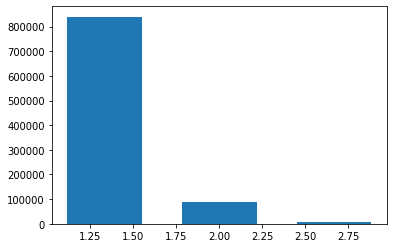

In [165]:
plt.hist(X_train.subj_cat, bins=3, rwidth=0.65);

X_train.subj_cat.corr(X_train.target)

- Но здесь есть определённый зазор: предприятия, которые уже не соответствуют категории (по численности рабтников или по доходу) - только по истечении 3 лет сменят категорию в реестре, тогда как численность работников подаётся каждый год
- можно использовать как признак

        1 - Микро: не более 15 человек, доход - не более 120 млн
        2 - Малое: не более 100, не более 800 млн 
        3 - Среднее: не более 250, не более 2 млрд
        
- микро, которые не микро - 15.5 тыс строк
- я не смотрю здесь доходы, потому что можно закопаться (выручка + прочие доходы + налог на прибыль, если доход...)

In [166]:
X_train.loc[(X_train.subj_cat == 1) & (X_train.n_employees > 15), ['subj_cat', 'city', 'statusCode', 'n_employees']]

subj_cat               city statusCode  n_employees
61             1             Москва     ACTIVE           27
103            1             Москва     ACTIVE           65
212            1               None     ACTIVE           27
229            1             Казань     ACTIVE           25
244            1             Москва     ACTIVE           17
...          ...                ...        ...          ...
935767         1  Каменск-Уральский     ACTIVE           57
935797         1             Казань     ACTIVE           24
935808         1       Екатеринбург     ACTIVE           21
935838         1    Санкт-Петербург     ACTIVE           20
936023         1         Красноярск     ACTIVE           16

[15480 rows x 4 columns]

- из них микро, которые малое

In [168]:
X_train.loc[(X_train.subj_cat == 1) & (X_train.n_employees > 15) & (X_train.n_employees <= 100), ['subj_cat', 'city', 'statusCode', 'n_employees']]

subj_cat               city statusCode  n_employees
61             1             Москва     ACTIVE           27
103            1             Москва     ACTIVE           65
212            1               None     ACTIVE           27
229            1             Казань     ACTIVE           25
244            1             Москва     ACTIVE           17
...          ...                ...        ...          ...
935767         1  Каменск-Уральский     ACTIVE           57
935797         1             Казань     ACTIVE           24
935808         1       Екатеринбург     ACTIVE           21
935838         1    Санкт-Петербург     ACTIVE           20
936023         1         Красноярск     ACTIVE           16

[14983 rows x 4 columns]

- кодирую категорией: 1->1, 1->2, 1->3, 2->1, 2->2, 2->3, 3->1, 3->2, 3->3. - 9 групп

- на первый взгляд, - это всё делать надо после заполнения пропусков в n_employees (там пропуски == -1), но ! существенно ничего не меняется
- и, кажется, пропуск является важной информацией

- новый признак - актуальный размер предприятия по числу работников - **new_subj_cat**

In [169]:
X_train['new_subj_cat'] = np.where(X_train.n_employees <=15, 1, 
                                   np.where((X_train.n_employees > 15) & (X_train.n_employees <= 100), 2, 3))

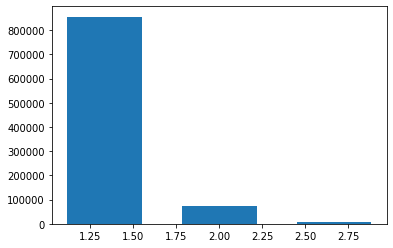

In [170]:
plt.hist(X_train.new_subj_cat, bins=3, rwidth=0.65);

- а теперь **change_subj_cat**

In [171]:
X_train['change_subj_cat'] = X_train[['subj_cat', 'new_subj_cat']].astype(str).agg('->'.join, axis= 1)

In [172]:
X_train['change_subj_cat'].value_counts(normalize=True)

1->1    0.880783
2->2    0.061787
2->1    0.031186
1->2    0.016006
3->3    0.004335
3->2    0.002487
3->1    0.001804
2->3    0.001081
1->3    0.000531
Name: change_subj_cat, dtype: float64

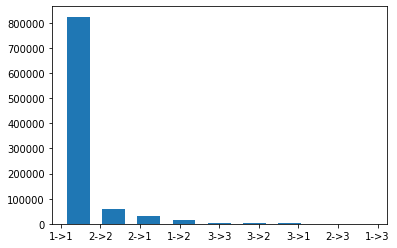

In [173]:
plt.hist(X_train.change_subj_cat, bins=9, rwidth=0.65);
# plt.ylabel("log(y)")

- распределение с таргетом
- плохо понятно соотношение из-за логарифма, а без логарифма - слишком большой дисбаланс

In [ ]:
plt.hist(X_train.loc[X_train.target == 0, 'change_subj_cat'], bins=9, align='left', rwidth=0.5)
plt.hist(X_train.loc[X_train.target == 1, 'change_subj_cat'], bins=9, align='left', density=True, alpha=0.5)
plt.yscale('log')
plt.legend(['0', '1'])

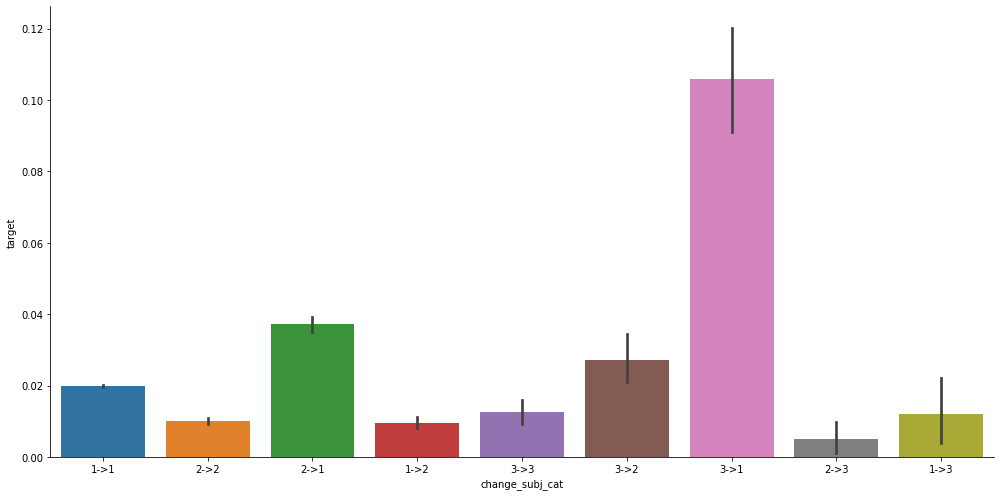

In [174]:
# матожидание для столбца, можно сделать log
# plt.figure(figsize=(12, 7))
sns.catplot(
    data=X_train, x="change_subj_cat", y="target",
    kind="bar", height=7, aspect=2,
)
# g.set_axis_labels()
# g.set_xticklabels([])
# g.set_titles("")
# plt.yscale('log')
# g.despine(left=True)

- здесь сразу заметно - например, 3->1 - группа риска, 3->2 - тоже...
- что очевидно, впрочем

- снижение числа работников - тревожный фактор
- рост или стабильность - позитивный фактор
- за исключением группы 1->1 - их просто больше всех остальных и им некуда дальше падать

- и здесь можно схитрить и сделать новый признак - отранжировать change_subj_cat по вероятности таргета
- **change_subj_cat_range**

In [178]:
tmp_sc = X_train.groupby('change_subj_cat').agg(count_target=('target', 'count'), sum_target=('target', 'sum'))
tmp_sc['target_perc'] = tmp_sc.sum_target / tmp_sc.count_target
tmp_sc.sort_values('target_perc', inplace=True)
tmp_sc.target_perc

change_subj_cat
2->3    0.004941
1->2    0.009611
2->2    0.010132
1->3    0.012072
3->3    0.012568
1->1    0.019873
3->2    0.027062
2->1    0.037270
3->1    0.105980
Name: target_perc, dtype: float64

In [179]:
change_subj_cat_to_range = {i: n for i, n in zip(tmp_sc.index, range(9))}
change_subj_cat_to_range

{'2->3': 0,
 '1->2': 1,
 '2->2': 2,
 '1->3': 3,
 '3->3': 4,
 '1->1': 5,
 '3->2': 6,
 '2->1': 7,
 '3->1': 8}

In [182]:
X_train['change_subj_cat_range'] = X_train.change_subj_cat.replace(change_subj_cat_to_range)

### 1.3. Даты

- 2 даты: регистрация и включение в реестр

- регистрация -  число, когда информация об учреждении организации была внесена регистрирующим органом ФНС в ЕГРЮЛ. = момент приобретения правоспособности.
- дата внесения в реестр - внесение информации в реестр МСП. Непонятно, насколько мб полезным.


- беру время жизни до 1 января 2022
- можно сгладить различие для более старых компаний (1/x)
- дни или месяцы?

In [183]:
date_col = ['registrationDate', 'inclusion_date']

In [184]:
X_train[date_col].isnull().sum()

registrationDate    1
inclusion_date      0
dtype: int64

In [185]:
# ага, это в любом случае странная строка, избавляемся ниже
X_train.loc[X_train.registrationDate.isnull(), ['city', 'okved2', 'statusCode', 
                                                'authorizedCapital', 'n_employees', 
                                                'inclusion_date']]

city    okved2 statusCode  authorizedCapital  n_employees  \
812086  Энгельс  52.21.24     ACTIVE                NaN           -1   

       inclusion_date  
812086     2016-09-10

In [186]:
X_train[date_col].describe(datetime_is_numeric=True)

registrationDate                 inclusion_date
count                         936072                         936073
mean   2012-09-22 21:39:54.923467520  2017-12-19 16:29:27.585220352
min              1955-09-06 00:00:00            2016-08-01 00:00:00
25%              2008-07-07 00:00:00            2016-08-01 00:00:00
50%              2014-05-29 00:00:00            2016-08-01 00:00:00
75%              2018-03-12 00:00:00            2019-06-10 00:00:00
max              2022-11-17 00:00:00            2023-03-10 00:00:00

#### 1.3.1. registrationDate

- есть интересное минимальное значение

In [188]:
# гостиница
data.loc[data.registrationDate == '1955-09-06 00:00:00']

inn                 shortName   index  city settlement okved2  \
962152  9103067691  ООО "ЛИВАДИОН САН ПЛАЗА"  298635  Ялта       None  55.10   

        okopf statusCode registrationDate  authorizedCapital  ...  \
962152  12300     ACTIVE       1955-09-06            10000.0  ...   

        cons_basket_working_age_2020  cons_basket_working_age_2021  \
962152                   5387.308105                   6091.378906   

        diesel_cost_2020  diesel_cost_2021  diesel_volume_2020  \
962152         49.070381         52.189369        238884.03125   

        diesel_volume_2021  region_population  city_population  \
962152        284649.46875            1934630         137947.0   

        settlement_population  target  
962152                    NaN       0  

[1 rows x 97 columns]

- но, в любом случае, наверное стоит обрезать выбросы

In [190]:
X_train.loc[X_train.registrationDate < '1990-01-01 00:00:00']

index             city settlement    okved2  okopf statusCode  \
385     140007          Люберцы       None  52.21.24  20101     ACTIVE   
468     350080        Краснодар       None   68.32.1  20102     ACTIVE   
559     162622        Череповец       None  52.21.24  20101     ACTIVE   
924     426052           Ижевск       None  52.21.24  20101     ACTIVE   
2180    185007     Петрозаводск       None  52.21.24  20101     ACTIVE   
...        ...              ...        ...       ...    ...        ...   
934849  195176  Санкт-Петербург       None     68.32  20102     ACTIVE   
935115  298048      Симферополь       None     68.32      0     ACTIVE   
935394  195176  Санкт-Петербург       None   68.32.1  20102     ACTIVE   
935557  198217  Санкт-Петербург       None   68.32.1  20102     ACTIVE   
935643  144002     Электросталь       None  52.21.24  20101     ACTIVE   

       registrationDate  authorizedCapital  2021_1150  2020_1150  ...  \
385          1986-06-24                NaN        0.0        0.0  ...   
468          1977-10-19                NaN        0.0        0.0  ...   
559          1984-03-03                NaN        0.0        0.0  ...   
924          1988-09-05                NaN        0.0        0.0  ...   
2180         1981-05-19                NaN        0.0        0.0  ...   
...                 ...                ...        ...        ...  ...   
934849       1964-10-12                NaN        0.0        0.0  ...   
935115       1988-11-15                NaN        0.0        0.0  ...   
935394       1970-04-01                NaN        0.0        0.0  ...   
935557       1964-08-29                NaN        0.0        0.0  ...   
935643       1975-06-27                NaN        0.0        0.0  ...   

        n_org_per_okopf  n_org_per_okopf_region  n_org_per_okopf_region_q95  \
385                9498                     504                         504   
468                4371                     122                         122   
559                9498                     585                         585   
924                9498                     126                         126   
2180               9498                     197                         197   
...                 ...                     ...                         ...   
934849             4371                     711                         711   
935115            14591                     274                         274   
935394             4371                     711                         711   
935557             4371                     711                         711   
935643             9498                     504                         504   

        n_org_per_okopf_region_med  n_org_per_okopf_locality  \
385                        18402.0                       9.0   
468                        18402.0                      54.0   
559                        18402.0                     446.0   
924                        18402.0                      44.0   
2180                       18402.0                     112.0   
...                            ...                       ...   
934849                     18402.0                     684.0   
935115                     18402.0                      90.0   
935394                     18402.0                     684.0   
935557                     18402.0                     684.0   
935643                     18402.0                      20.0   

        n_org_per_okopf_locality_q95  n_org_per_okopf_locality_med  \
385                              9.0                           9.0   
468                             54.0                          54.0   
559                            446.0                         446.0   
924                             44.0                          44.0   
2180                           112.0                         112.0   
...                              ...                           ...   
934849                         684.

- а здесь те, у кого регистрация в 2022г,
- отчёт за 2021 есть, но всё по нулям
- эту строку точно убрать - она будет отрицательной

In [191]:
data.loc[data.registrationDate == '2022-11-17 00:00:00', ['inn', 'city', 'registrationDate', 'inclusion_date']]

inn       city registrationDate inclusion_date
800209  7447309698  Челябинск       2022-11-17     2022-12-10

- новый признак - время жизни (от регистрации до 2022.01.01) - **from_registr_days**

In [192]:
X_train['from_registr_days'] = (pd.to_datetime('2022-01-01') - X_train.registrationDate).dt.days

- убираем всех, кто живёт меньше 1 дня

In [193]:
X_train = X_train.loc[X_train.from_registr_days > 0]

from_registr_days
Ассиметрия: 1.216507600349534, эксцесс: 2.4088096802114762
Корреляция с таргетом: 0.0034960892787809406


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


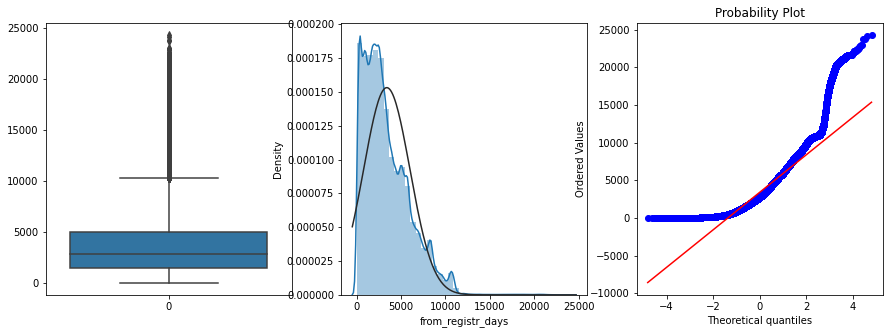

In [194]:
get_describe(X_train.from_registr_days)

- логарифм

from_registr_days
Ассиметрия: -1.2661519287463843, эксцесс: 2.428894609412259
Корреляция с таргетом: 0.008046103479901763


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


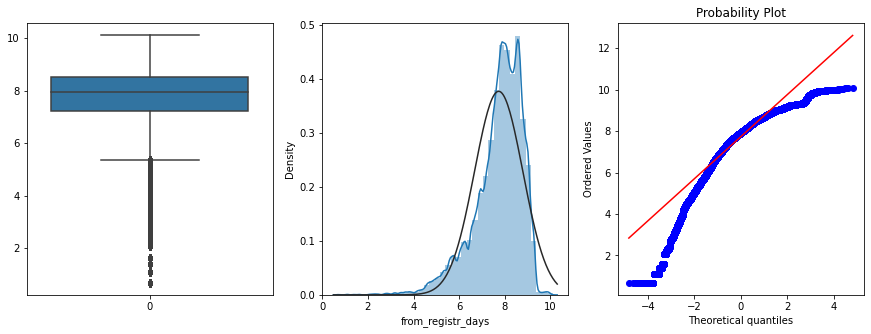

In [195]:
get_describe(np.log(X_train.from_registr_days))

In [196]:
X_train['from_registr_days_log'] = np.log(X_train.from_registr_days)

C:\Users\013\AppData\Local\Temp/ipykernel_5820/1801578152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['from_registr_days_log'] = np.log(X_train.from_registr_days)


- выбросы

In [197]:
X_train = pd.concat([X_train, cut_outliers(X_train.from_registr_days)], axis=1)

- обратная шкала - **from_registr_days_fract** (1/x) - нуля нет, его обрезали

In [198]:
X_train['from_registr_days_fract'] = 1/X_train.from_registr_days

from_registr_days_fract
Ассиметрия: 37.01500591766458, эксцесс: 1792.8839029069954
Корреляция с таргетом: -0.003245656298836246


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


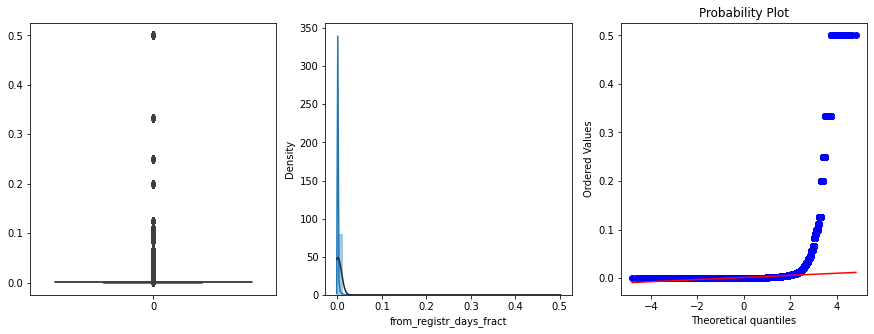

In [199]:
get_describe(X_train.from_registr_days_fract)

- выбросы

In [200]:
X_train = pd.concat([X_train, cut_outliers(X_train.from_registr_days_fract)], axis=1)

- можно поподбирать функцию для преобразования - на будущее

#### 1.3.2. inclusion_date

- пропусков нет

In [201]:
X_train.inclusion_date.max(), X_train.inclusion_date.min()

(Timestamp('2023-03-10 00:00:00'), Timestamp('2016-08-01 00:00:00'))

- новый признак - время жизни (от внесения в реестр до 2022.01.01) - **from_inclusion_days**

In [202]:
X_train['from_inclusion_days'] = (pd.to_datetime('2022-01-01') - X_train.inclusion_date).dt.days

In [203]:
X_train.from_inclusion_days.min(), X_train.from_inclusion_days.max()

(-433, 1979)

- ага, Внесение в реестр происходит: с 10 января по 10 июня – на основании сведений за календарный год, предшествующий предыдущему году
- те отрицательные значения норм, можно сдвинуть точку отчёта, а можно не сдвигать

In [205]:
X_train.loc[X_train.from_inclusion_days <= 0].shape

(24651, 134)

from_inclusion_days
Ассиметрия: -1.0189056025770957, эксцесс: -0.4500631128082784
Корреляция с таргетом: -0.03455662503861172


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


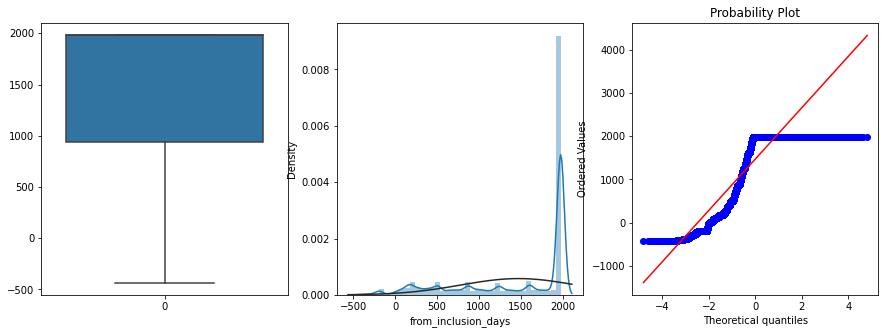

In [206]:
get_describe(X_train.from_inclusion_days)

- выбросы

In [207]:
X_train = pd.concat([X_train, cut_outliers(X_train.from_inclusion_days)], axis=1)

- новый признак - сглаживаем - **from_inclusion_days_fract**

In [208]:
X_train['from_inclusion_days_fract'] = 1/np.where(X_train.from_inclusion_days == 0, 
                                                  1, 
                                                  X_train.from_inclusion_days)

- интересно, но имеет ли смысл с отрицательными значениями? - 2 гиперболы вместо одной

from_inclusion_days_fract
Ассиметрия: -10.148907443182894, эксцесс: 148.68547980677414
Корреляция с таргетом: -0.0006092930863269989


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


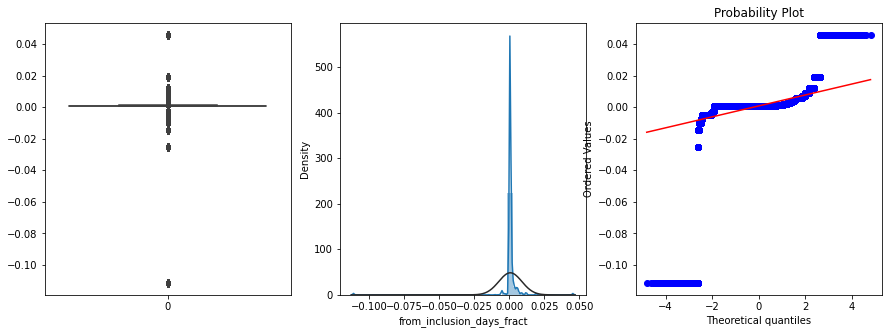

In [209]:
get_describe(X_train.from_inclusion_days_fract)

- даты вместе - не так уж и сильно связаны

In [210]:
X_train.from_registr_days.corr(X_train.from_inclusion_days)

0.47692792687778

### 1.4. Вещественные

- есть организации, зараегистрированные в 2021 г, те для них отчёты за 2020 - по нулям

In [211]:
num_cols = X_train.select_dtypes(include='float32').columns.tolist() + \
           ['n_contracts', 'n_agreements', 'n_okovd_add', 'n_licenses', 'n_products', 
            'n_employees', 'region_population']
len(num_cols)

78

- большая часть пропусков уже заполнена

In [212]:
for i, val in X_train[num_cols].isna().sum().items():
    if val > 0:
        print(i, val)

authorizedCapital 38871
city_population 86093
settlement_population 875707


In [213]:
X_train[num_cols].describe()

authorizedCapital     2021_1150     2020_1150     2021_1170  \
count       8.971290e+05  9.360000e+05  9.360000e+05  9.360000e+05   
mean        4.347398e+06  7.040832e+03  6.231093e+03  2.495133e+05   
std         9.581766e+08  1.383972e+05  1.326463e+05  2.361859e+08   
min         0.000000e+00 -7.252740e+05 -7.197480e+05 -2.368400e+04   
25%         1.000000e+04  0.000000e+00  0.000000e+00  0.000000e+00   
50%         1.000000e+04  0.000000e+00  0.000000e+00  0.000000e+00   
75%         2.000000e+04  4.050000e+02  2.510000e+02  0.000000e+00   
max         7.360000e+11  1.047500e+08  1.048818e+08  2.285006e+11   

          2020_1170     2021_1210     2020_1210     2021_1230     2020_1230  \
count  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05   
mean   2.487846e+05  1.616450e+04  1.370190e+04  2.054195e+04  1.603358e+04   
std    2.361858e+08  6.253771e+06  6.205124e+06  2.624176e+06  2.083759e+06   
min   -2.368400e+04 -5.811240e+05 -1.590034e+06 -2.759500e+05 -2.833740e+05   
25%    0.000000e+00  0.000000e+00  0.000000e+00  1.500000e+01  0.000000e+00   
50%    0.000000e+00  2.700000e+01  1.000000e+01  8.430000e+02  5.190000e+02   
75%    0.000000e+00  1.674000e+03  1.245000e+03  6.567000e+03  4.968000e+03   
max    2.285006e+11  5.947565e+09  5.947565e+09  2.003000e+09  2.003000e+09   

          2021_1250  ...  diesel_volume_2021  city_population  \
count  9.360000e+05  ...        9.360000e+05         849907.0   
mean   2.702145e+03  ...        5.323247e+05        3307989.5   
std    5.686164e+04  ...        5.321992e+05        4815505.5   
min   -1.590000e+06  ...        7.202673e+02            207.0   
25%    4.000000e+00  ...        1.225199e+05         301199.0   
50%    9.000000e+01  ...        2.491568e+05         913035.0   
75%    7.390000e+02  ...        8.149203e+05        5601911.0   
max    3.275013e+07  ...        1.870944e+06       13010112.0   

       settlement_population    n_contracts   n_agreements    n_okovd_add  \
count           6.029300e+04  936000.000000  936000.000000  936000.000000   
mean            1.354460e+04       0.004851       0.001556      17.224729   
std             4.780136e+04       1.336810       0.201458      20.746728   
min             5.500000e+01       0.000000       0.000000       0.000000   
25%             3.567000e+03       0.000000       0.000000       6.000000   
50%             6.624000e+03       0.000000       0.000000      12.000000   
75%             1.236100e+04       0.000000       0.000000      22.000000   
max             1.934630e+06    1084.000000      88.000000    2420.000000   

          n_licenses     n_products    n_employees  region_population  
count  936000.000000  936000.000000  936000.000000       9.360000e+05  
mean        0.192392       0.003525       6.098689       4.836931e+06  
std         0.752348       0.237494      19.067820       4.174956e+06  
min         0.000000       0.000000      -1.000000       4.143400e+04  
25%         0.000000       0.000000       1.000000       1.540486e+06  
50%         0.000000       0.000000       1.000000       3.172925e+06  
75%         0.000000       0.000000       5.000000       5.838273e+06  
max       251.000000      70.000000    8617.000000       1.301011e+07  

[8 rows x 78 columns]

#### 1.4.1. city_population, settlement_population
- сперва разберёмся с численность населения по конечному населённому пункту

In [214]:
X_train[['city', 
         'settlement', 
         'city_population', 
         'settlement_population']].loc[~X_train.settlement_population.isna()]

city     settlement  city_population  settlement_population
9       Раменское         Быково           1177.0                 8594.0
20           None     Хохольский              NaN                 7954.0
22           None       Гелдаган              NaN                11021.0
23           None        Янино-1              NaN                16886.0
24           None        Нежинка              NaN                10656.0
...           ...            ...              ...                    ...
936017       None        Маркова              NaN                36971.0
936025       None        Ашукино              NaN                 8855.0
936036       None  Летняя Ставка              NaN                 3855.0
936044       None    Пригородный              NaN                 3437.0
936046       None     Усть-Тарка              NaN                 4054.0

[60293 rows x 4 columns]

- берём численность по конечному населённому пункту (settlement - если есть, иначе - city)

In [215]:
X_train['populations'] = X_train.settlement_population \
                                .where(~X_train.settlement.isna(), X_train.city_population)

In [217]:
X_train['populations'].loc[9]

8594.0

- ок, всё корректно
- смотрим пропуски - 

In [218]:
X_train['populations'].isna().sum()

48291

populations
Ассиметрия: 1.4553688764572144, эксцесс: 0.36928224563598633
Корреляция с таргетом: 6.944464772133923e-05


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


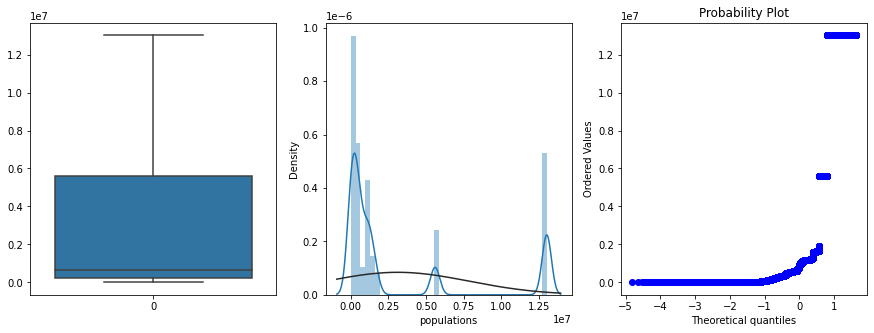

In [219]:
get_describe(X_train.populations)

- заполню медианой всех значений менее 3000 - тк именно для таких пунктов нет данных

In [220]:
popul_med = X_train.loc[X_train['populations'] < 3000, 'populations'].median()
popul_med

1177.0

In [221]:
X_train['populations_med'] = X_train.populations.fillna(popul_med)

- или медианой по коду региона

In [222]:
popul_region_med = X_train.groupby('region_code')['populations'].median()
popul_region_med

region_code
1      167658.0
2     1167775.0
3      437565.0
4       65342.0
5      124953.0
        ...    
86      40180.0
87      13598.0
89     100188.0
91     154621.0
92     547820.0
Name: populations, Length: 85, dtype: float32

In [223]:
cond = X_train.populations.isna()
X_train['populations_region_med'] = X_train.populations
X_train.loc[cond, 'populations_region_med'] = X_train.loc[cond, 'region_code'].replace(popul_region_med)

- выбросы

In [224]:
X_train = pd.concat([X_train, cut_outliers(X_train.populations_med)], axis=1)
X_train = pd.concat([X_train, cut_outliers(X_train.populations_region_med)], axis=1)

#### 1.4.2. region_populations

- дб сильно связан с populations
- + пригодится для нормирования цен на топливо/потребит. корзины

In [225]:
X_train.region_population.isna().sum()

0

In [226]:
X_train.region_population.nunique()

85

- можно подумать, как визуализировать

In [228]:
# !pip install squarify
import squarify

In [227]:
region_popul = X_train.groupby('region_code', as_index=False)['region_population'].first()
region_popul.sort_values('region_population', ascending=False, inplace=True)

- топ-10 регионов по численности
- пока не очень интересно
-  можно добавить в подписи число организаций (n_org: %0, %1)? или другую простую статистику? Фин. показатели? Уровень цен?

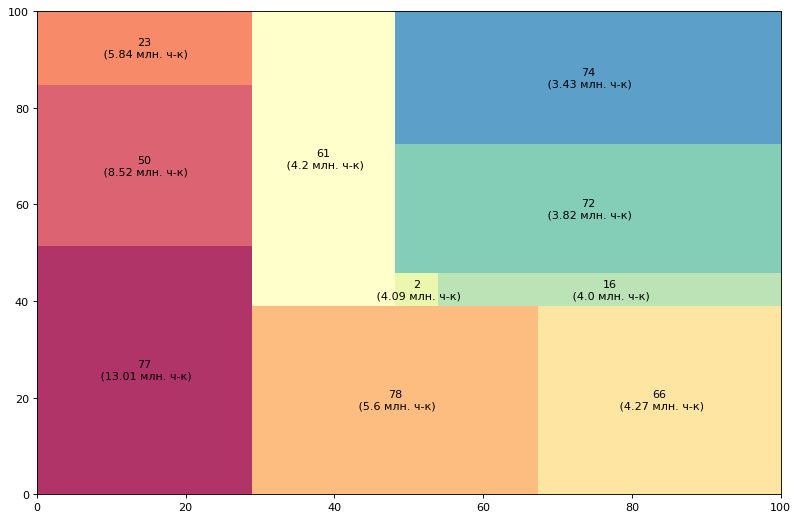

In [229]:
labels = region_popul.iloc[:10].apply(lambda x: str(int(x[0])) + "\n (" + str((x[1]/1000000).round(2)) + " млн. ч-к)", axis=1)
sizes = region_popul.iloc[:10]['region_code'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]


plt.figure(figsize=(12,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# plt.title()
# plt.axis()
plt.show()

- корреляция с populations - ожидаемо

In [230]:
X_train.region_population.corr(X_train.populations)

0.9034315602983161

#### 1.4.3. бух. отчёт

- признаков уже осталось не так много - только основные и те, по которым не слишком много 0, 
- пропусков нет - все заполнены нулями
- для новых организаций, у которых нет предыдущего года - тоже все нули, т.е. рост будет 100% в сравнении с предыдущим годом - что не имеет смысла по факту

     '2021_1150', - осн средства
     '2020_1150', 
     '2021_1170', - фин вложения 
     '2020_1170',
     '2021_1210', - запасы
     '2020_1210',
     '2021_1230', - дебиторская задолженность
     '2020_1230',
     '2021_1250', - денежные средства и денежные эквиваленты
     '2020_1250',
     '2021_1600', - итоговый баланс по активам
     '2020_1600',
     '2021_1350', - добавочный капитал (без переоценки)
     '2020_1350',
     '2021_1360', - резервный капитал
     '2020_1360',
     '2021_1300', - итог по капиталу и резервам
     '2020_1300',
     '2021_1520', - кредиторская задолженность
     '2020_1520',
     '2021_1700', - баланс по пассивам
     '2020_1700',

In [233]:
acc_report = num_cols[1:23]
acc_report

['2021_1150',
 '2020_1150',
 '2021_1170',
 '2020_1170',
 '2021_1210',
 '2020_1210',
 '2021_1230',
 '2020_1230',
 '2021_1250',
 '2020_1250',
 '2021_1600',
 '2020_1600',
 '2021_1350',
 '2020_1350',
 '2021_1360',
 '2020_1360',
 '2021_1300',
 '2020_1300',
 '2021_1520',
 '2020_1520',
 '2021_1700',
 '2020_1700']

In [234]:
X_train[acc_report].describe()

2021_1150     2020_1150     2021_1170     2020_1170     2021_1210  \
count  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05   
mean   7.040832e+03  6.231093e+03  2.495133e+05  2.487846e+05  1.616450e+04   
std    1.383972e+05  1.326463e+05  2.361859e+08  2.361858e+08  6.253771e+06   
min   -7.252740e+05 -7.197480e+05 -2.368400e+04 -2.368400e+04 -5.811240e+05   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.700000e+01   
75%    4.050000e+02  2.510000e+02  0.000000e+00  0.000000e+00  1.674000e+03   
max    1.047500e+08  1.048818e+08  2.285006e+11  2.285006e+11  5.947565e+09   

          2020_1210     2021_1230     2020_1230     2021_1250     2020_1250  \
count  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05   
mean   1.370190e+04  2.054195e+04  1.603358e+04  2.702145e+03  2.257501e+03   
std    6.205124e+06  2.624176e+06  2.083759e+06  5.686164e+04  4.137145e+04   
min   -1.590034e+06 -2.759500e+05 -2.833740e+05 -1.590000e+06 -7.330000e+05   
25%    0.000000e+00  1.500000e+01  0.000000e+00  4.000000e+00  0.000000e+00   
50%    1.000000e+01  8.430000e+02  5.190000e+02  9.000000e+01  5.700000e+01   
75%    1.245000e+03  6.567000e+03  4.968000e+03  7.390000e+02  5.690000e+02   
max    5.947565e+09  2.003000e+09  2.003000e+09  3.275013e+07  1.850014e+07   

       ...     2021_1350     2020_1350     2021_1360     2020_1360  \
count  ...  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05   
mean   ...  1.820714e+03  1.629311e+03  1.123270e+03  1.114024e+03   
std    ...  7.776398e+05  7.766231e+05  1.012992e+06  1.012990e+06   
min    ... -7.126435e+06 -3.050917e+06 -2.754510e+05 -2.753220e+05   
25%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    ...  7.505354e+08  7.501942e+08  9.800175e+08  9.800157e+08   

          2021_1300     2020_1300     2021_1520     2020_1520     2021_1700  \
count  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05   
mean   1.390969e+04  1.121436e+04  8.950556e+04  8.352406e+04  3.714997e+05   
std    1.421523e+06  1.180190e+06  6.397857e+07  6.361284e+07  2.468057e+08   
min   -8.378300e+07 -8.378300e+07 -3.265600e+04 -3.544800e+04 -1.478000e+06   
25%    1.000000e+01  0.000000e+00  1.400000e+01  0.000000e+00  2.750000e+02   
50%    4.140000e+02  2.470000e+02  5.990000e+02  3.710000e+02  3.168000e+03   
75%    4.065000e+03  3.114000e+03  5.648000e+03  4.199000e+03  1.783900e+04   
max    7.504571e+08  7.503157e+08  6.184000e+10  6.151000e+10  2.305048e+11   

          2020_1700  
count  9.360000e+05  
mean   3.588444e+05  
std    2.466759e+08  
min   -1.563336e+06  
25%    8.300000e+01  
50%    2.185000e+03  
75%    1.389525e+04  
max    2.305048e+11  

[8 rows x 22 columns]

- везде много нулей
- стоит обратить внимание на осн средства (1150), денежные средства и денежные эквиваленты (1250), итог по капиталу и резервам (1300)

- надо резать выбросы

In [237]:
acc_report_corr = X_train[acc_report + ['target']].corr()

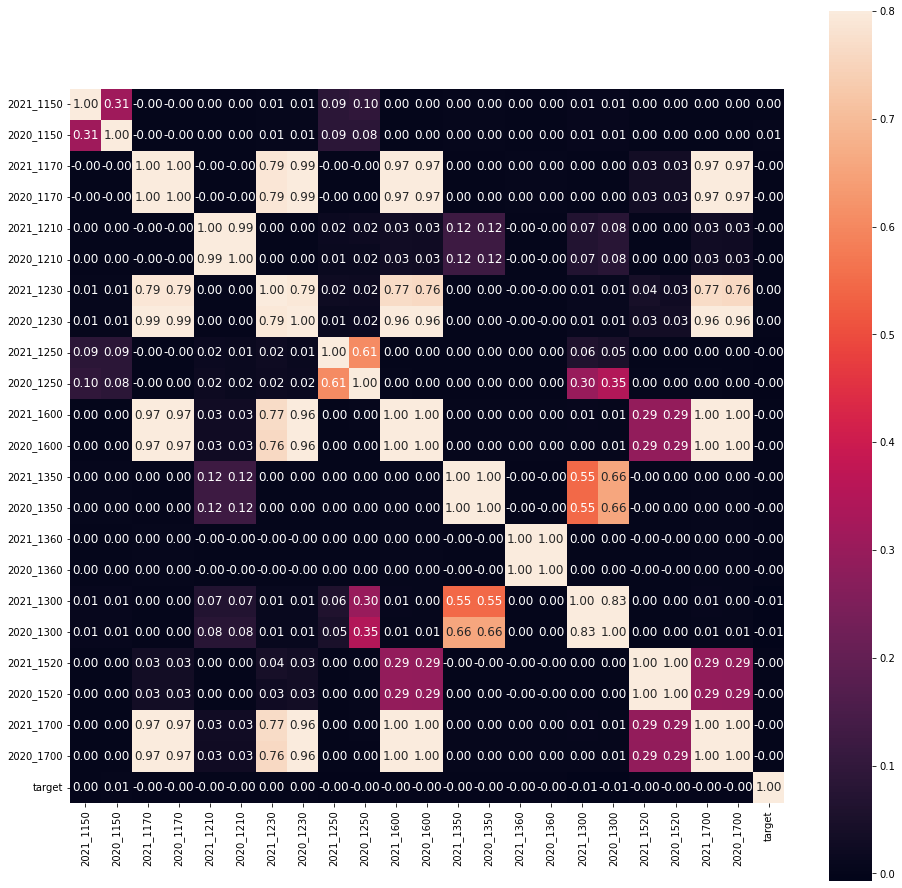

In [238]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(acc_report_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.2f', 
            annot_kws={'size': 12});

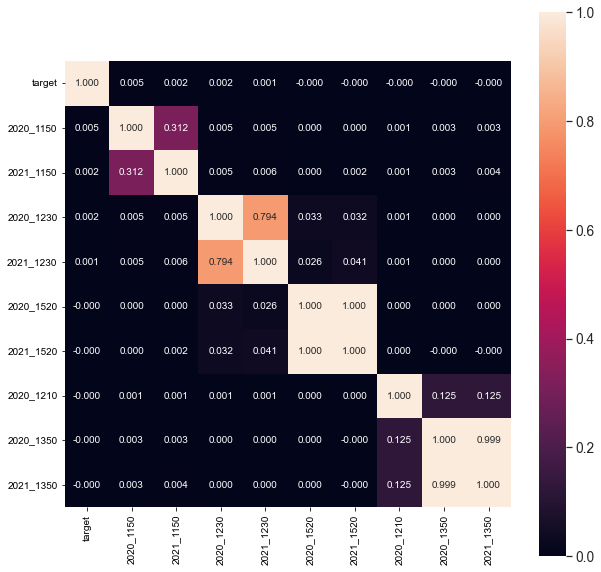

In [239]:
f, ax = plt.subplots(figsize=(10, 10))
k = 10 #number of variables for heatmap
cols = acc_report_corr.nlargest(k, 'target')['target'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- выбросы

In [241]:
col_2020 = [col for col in acc_report if '2020' in col]
col_2021 = [col for col in acc_report if '2021' in col]

In [242]:
# чтобы проще обращаться по именам
col_2020_cut_med = [f'{col}_med' for col in col_2020]
col_2020_cut_q95 = [f'{col}_q95' for col in col_2020]
col_2021_cut_med = [f'{col}_med' for col in col_2021]
col_2021_cut_q95 = [f'{col}_q95' for col in col_2021]

In [243]:
for col in acc_report:
    X_train = pd.concat([X_train, cut_outliers(X_train[col])], axis=1)

In [248]:
# for col in col_2020_cut_q95 + col_2021_cut_q95:
#     print(col)
#     sns.boxplot(X_train[col], whis=1.5)
#     plt.show()

 - некоторые признаки при обрезке зануляются
 - но корреляции намного лучше

- новые признаки **_growth_coef**  (2021 - 2020) / 2020
- вопрос в том, что делать, если за 2020 = 0: (просто оставлю 0 для них)

In [255]:
cutted_acc_report_2020 = ['2020_1150_q95',
                          '2020_1170',
                          '2020_1210_q95',
                          '2020_1230_q95',
                          '2020_1250_q95',
                          '2020_1600_q95',
                          '2020_1350',
                          '2020_1360',
                          '2020_1300_q95',
                          '2020_1520_q95',
                          '2020_1700_q95']
cutted_acc_report_2021 = ['2021_1150_q95',
                          '2021_1170',
                          '2021_1210_q95',
                          '2021_1230_q95',
                          '2021_1250_q95',
                          '2021_1600_q95',
                          '2021_1350',
                          '2021_1360',
                          '2021_1300_q95',
                          '2021_1520_q95',
                          '2021_1700_q95']
acc_report_growth = [f'{col}_growth' for col in cutted_acc_report_2020]

In [256]:
for col_0, col_1 in zip(cutted_acc_report_2020, cutted_acc_report_2021):
    X_train[f'{col_0}_growth'] = np.where(X_train[col_0] != 0,  
                                               (X_train[col_1] - X_train[col_0]) / X_train[col_0],
                                                0)

- распределения на вид не такие уж и плохие

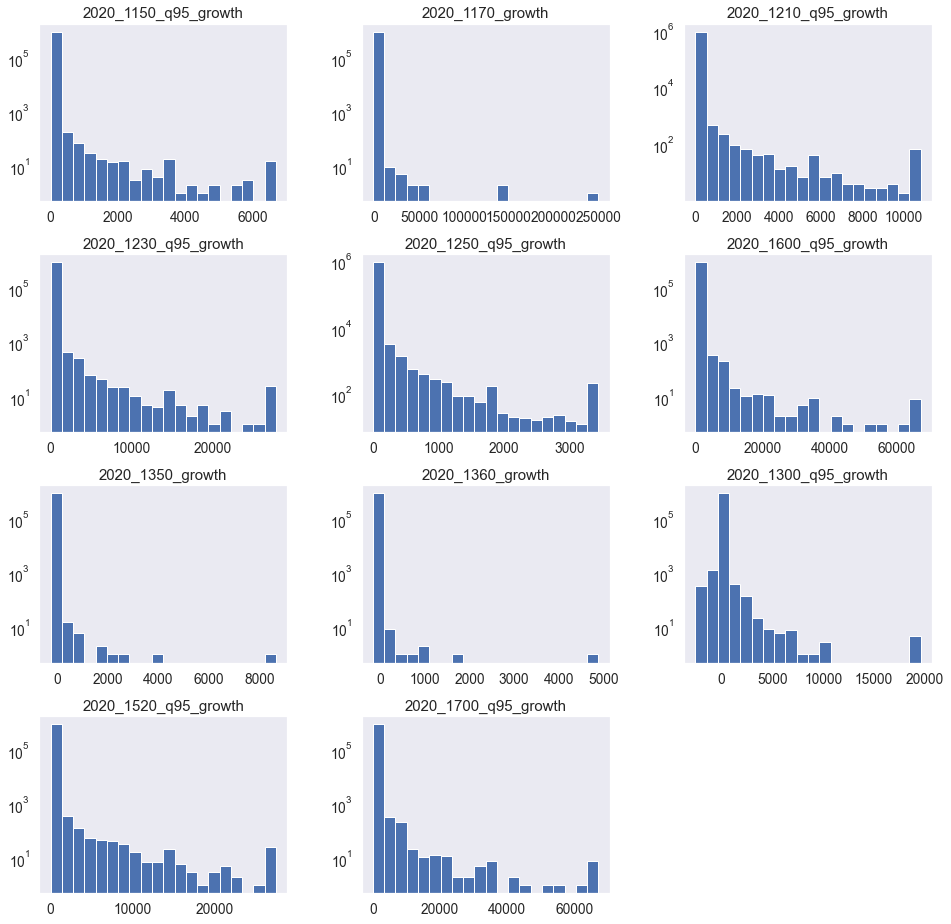

In [260]:
X_train[acc_report_growth].hist(figsize=(16, 16), bins=20, grid=False, log=True);

#### 1.4.4. фин. рез

         '2021_2110', - выручка
         '2020_2110',
         '2021_2120', - управленческие расходы
         '2020_2120',
         '2021_2330', - проценты к уплате
         '2020_2330',
         '2021_2340', - прочие доходы
         '2020_2340',
         '2021_2350', - прочие расходы
         '2020_2350',
         '2021_2410', - налог на прибыль
         '2020_2410',
         '2021_2400', - чистая прибыль (убыток)
         '2020_2400'

In [265]:
fin_res_cols = num_cols[23:37]

- имена столбцов для удобства

In [266]:
fin_res_20 = [col for col in fin_res_cols if '2020' in col]
fin_res_21 = [col for col in fin_res_cols if '2021' in col]
fin_res_20_med = [f'{col}_med' for col in fin_res_20]
fin_res_21_med = [f'{col}_med' for col in fin_res_21]
fin_res_20_q95 = [f'{col}_q95' for col in fin_res_20]
fin_res_21_q95 = [f'{col}_q95' for col in fin_res_21]

- выбросы

In [267]:
for col in fin_res_20 + fin_res_21:
    X_train = pd.concat([X_train, cut_outliers(X_train[col])], axis=1)

- сырые

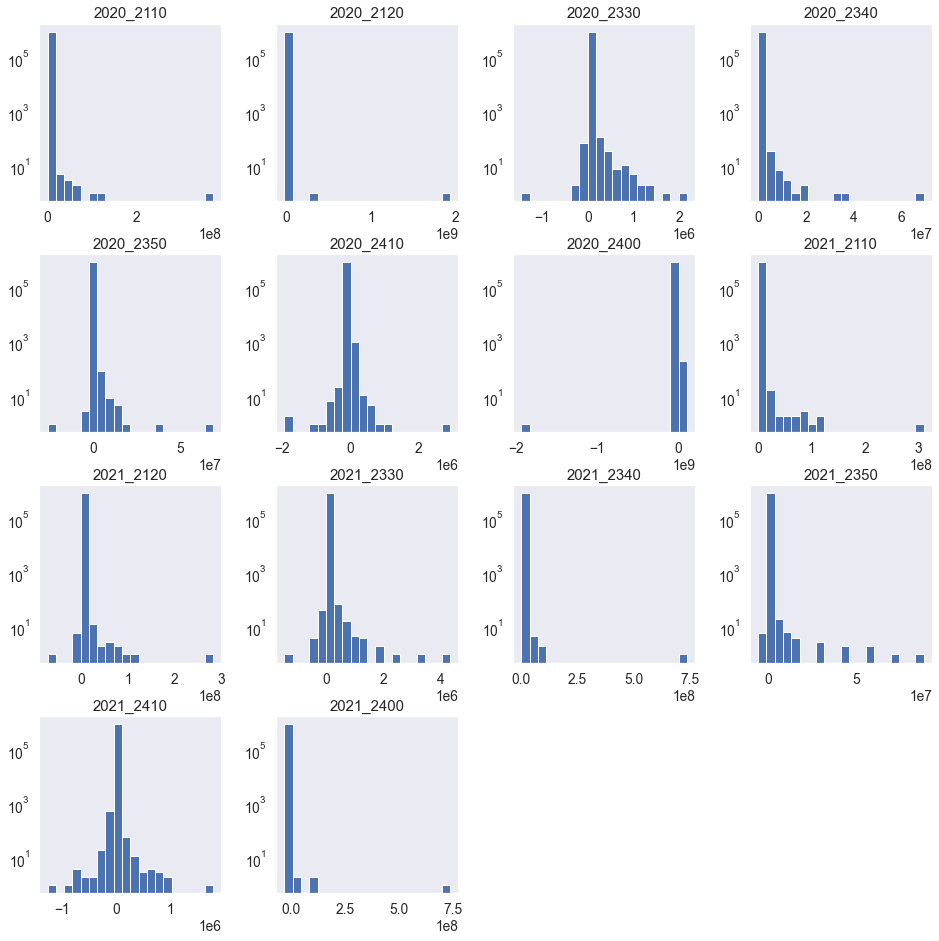

In [268]:
X_train[fin_res_20 + fin_res_21].hist(figsize=(16, 16), bins=20, grid=False, log=True);

- заполненные медианой

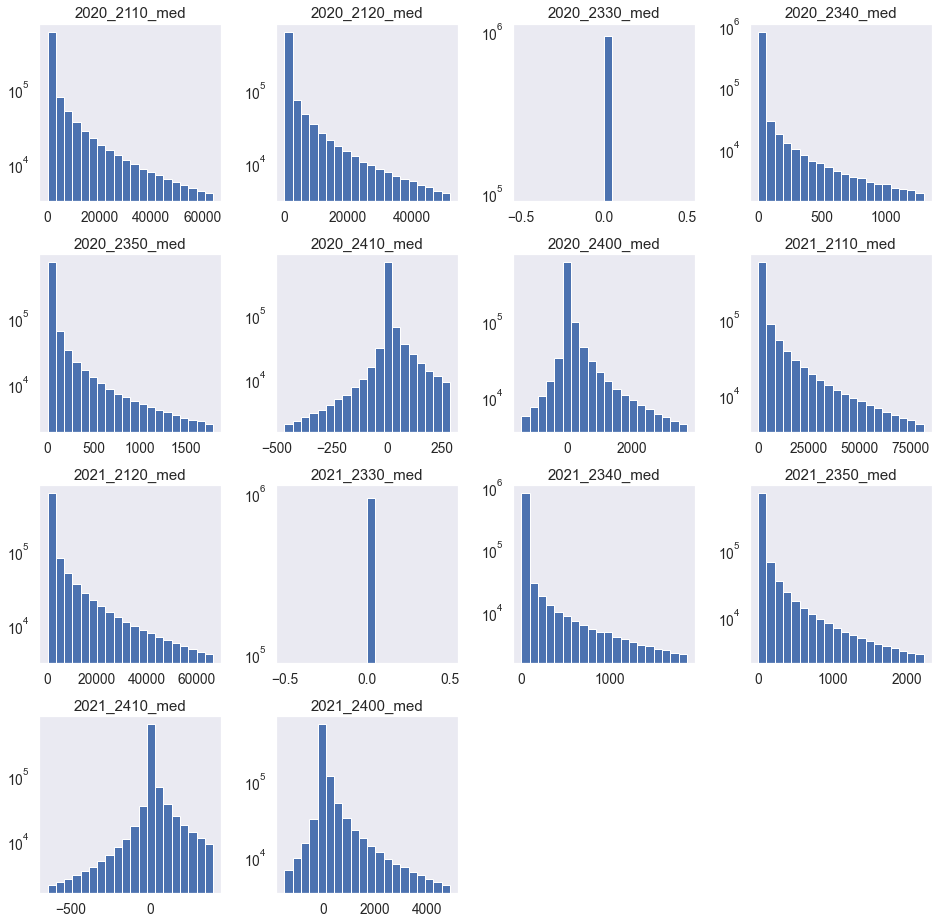

In [269]:
X_train[fin_res_20_med + fin_res_21_med].hist(figsize=(16, 16), bins=20, grid=False, log=True);

- опять некоторые зануляются
- корреляция - сырые

In [270]:
fin_res_corr = X_train[fin_res_20 + fin_res_21 + ['target']].corr()

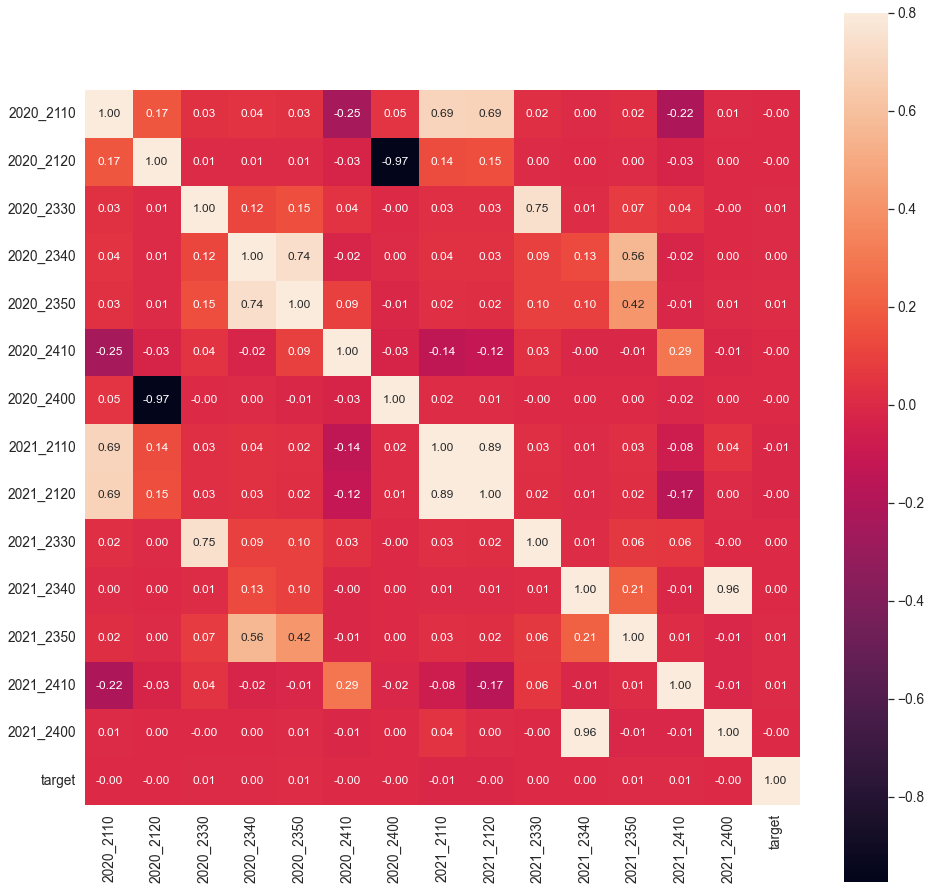

In [271]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(fin_res_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.2f', 
            annot_kws={'size': 12});

- (удивительно, но факт) - 2120 - управленческие расходы в 2020 г очень сильно коррелируют с 2400 = чистая прибыль (отрицательная связь). Для 2021 г. такого нет - там управленческие расходы сильно коррелируют с 2110 (выручка, положительная связь)
- и вообще много интересного
- если сделать отдельные матрицы для каждого года и сопоставить цифрам понятное название - тоже вполне можно в презентацию

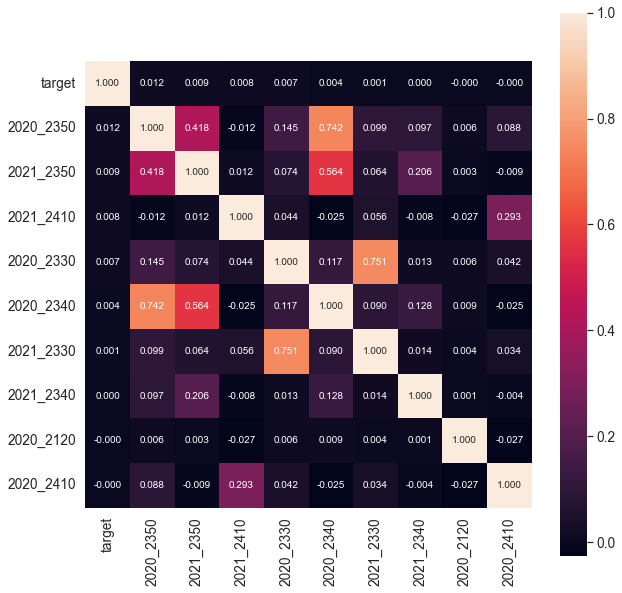

In [272]:
f, ax = plt.subplots(figsize=(10, 10))
k = 10 #number of variables for heatmap
cols = fin_res_corr.nlargest(k, 'target')['target'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- список признаков для _growth

In [277]:
cutted_fin_res_20 = ['2020_2110_q95',
                     '2020_2120_q95',
                     '2020_2330',
                     '2020_2340_q95',
                     '2020_2350_q95',
                     '2020_2410_q95',
                     '2020_2400_q95']
cutted_fin_res_21 = ['2021_2110_q95',
                     '2021_2120_q95',
                     '2021_2330',
                     '2021_2340_q95',
                     '2021_2350_q95',
                     '2021_2410_q95',
                     '2021_2400_q95']
fin_res_growth = [f'{col}_growth' for col in cutted_fin_res_20]

In [278]:
for col_0, col_1 in zip(cutted_fin_res_20, cutted_fin_res_21):
    X_train[f'{col_0}_growth'] = np.where(X_train[col_0] != 0,  
                                               (X_train[col_1] - X_train[col_0]) / X_train[col_0],
                                                0)

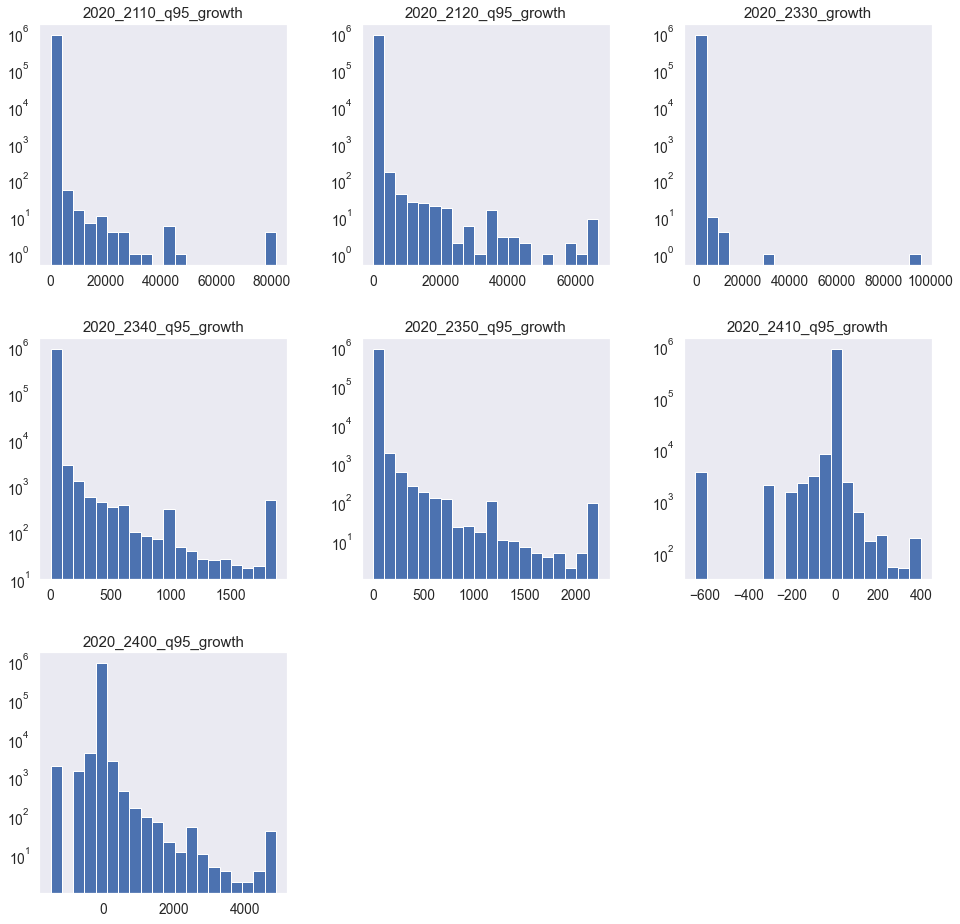

In [279]:
X_train[fin_res_growth].hist(figsize=(16, 16), bins=20, grid=False, log=True);

#### 1.4.5. финансовая поддержка
    
         '0102_2020', - гарантии и поручительство
         '0102_2021',
         '0103_2020', - субсидии и гранты
         '0103_2021',
         '0105_2020', - Финансовая аренда (лизинг)
         '0105_2021',
         
- интересный вопрос - кому чаще дают финансовую поддержку? - с какими признаками это мб связано (регион, численность, ...)?
- как раз можно посмотреть какое-нибудь распределение
- признак-флаг - факт фин. поддержки

In [282]:
fin_sup_col = ['0102_2020',
               '0102_2021',
               '0103_2020',
               '0103_2021',
               '0105_2020',
               '0105_2021',]

- новый признак - флаг - была поддержка в 20 или 21 гг - **is_fin_sup**

In [283]:
X_train['is_fin_sup'] = np.where(X_train[fin_sup_col].sum(axis=1) > 0, 1, 0)

In [284]:
X_train['is_fin_sup'].value_counts(normalize=True)

0    0.886964
1    0.113036
Name: is_fin_sup, dtype: float64

- вероятность таргета от факта поддержки
- топ-10 регионов по численности населения

In [285]:
region_popul.region_code.head(10).values

array([77, 50, 23, 78, 66, 61,  2, 16, 72, 74], dtype=int64)

In [286]:
tmp_df = X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values)]

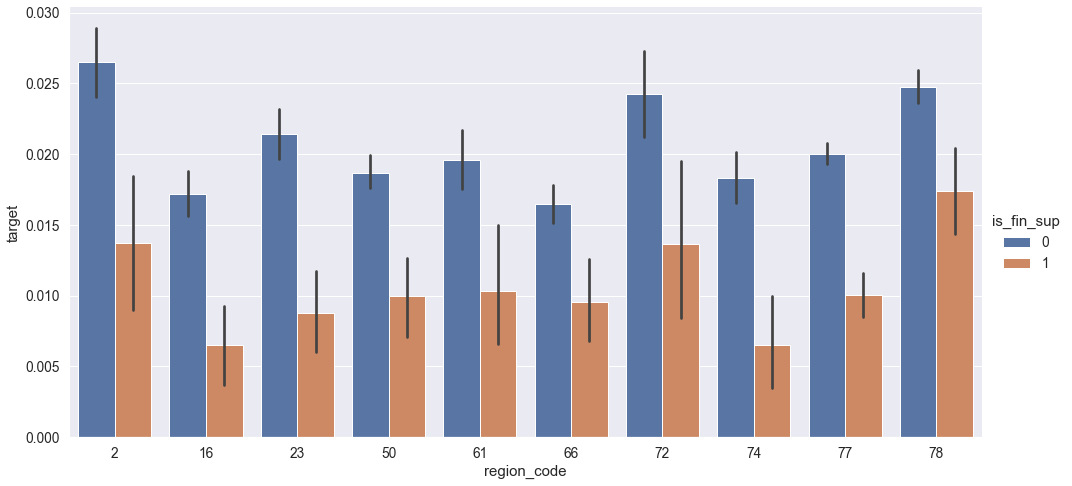

In [287]:
sns.catplot(
    data=tmp_df, x="region_code", y="target", hue='is_fin_sup',
    kind="bar", height=7, aspect=2,
)

In [ ]:
- просто таргет и поддержка

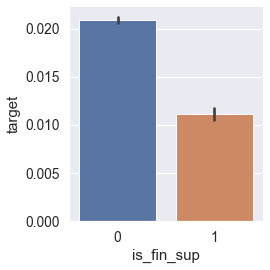

In [288]:
sns.catplot(
    data=X_train, x="is_fin_sup", y="target",
    kind="bar", height=4, aspect=1,
)

- цифры вообще невелики, не факт, что различие достоверно (хотя наблюдений и много) - но у тех, у кого нет поддержки - матожидание величины таргета заметно выше
- те наличие фин. поддержки, это хороший показатель для организации на ближайшие два года (хотя полоса ошибки мб достаточно большая)
- по регионам - тенденция везде примерно одна и та же

- 10 регионов с минимальной численностью

In [ ]:
region_popul.region_code.tail(10).values

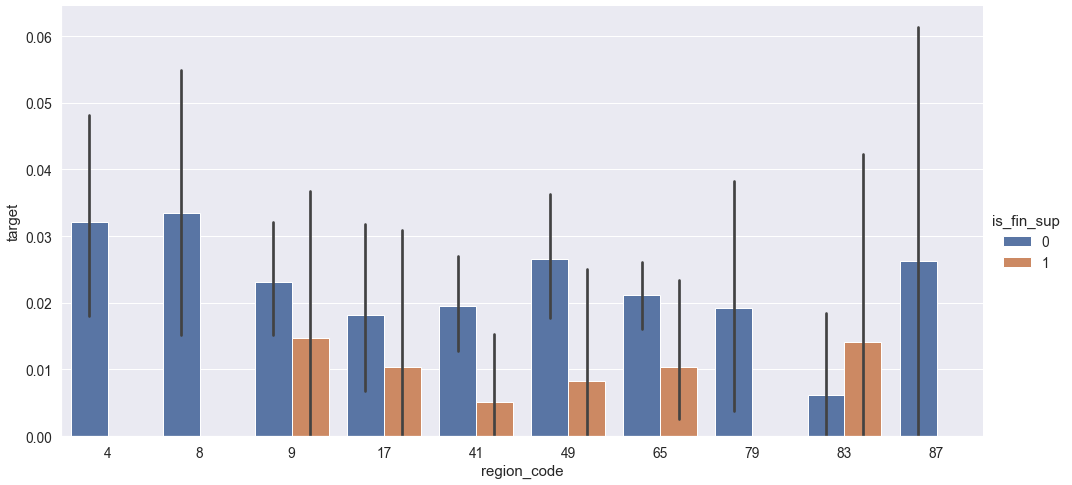

In [293]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.tail(10).values)],
    x="region_code", y="target", hue='is_fin_sup',
    kind="bar", height=7, aspect=2
)

- у таких регионов среднее таргета выше, + для некоторых регионов очень мало (или вообще нет поддержки)
- но поддержка всё так же работает
- но интервал ошибки - слишком большой

87 - Чукотский автономный округ

- можно было бы разбить на квантили или просто бины для регионов по численности

то же самое, но топ по числу организаций - признак n_org_per_region_code

In [295]:
X_train.region_code.value_counts().head(10).index

Int64Index([77, 78, 50, 66, 23, 54, 16, 74, 63, 52], dtype='int64')

- по списку почти совпадают, новые - 63, 52 и 54

- квантили по числу организаций n_org_per_region_code_quant

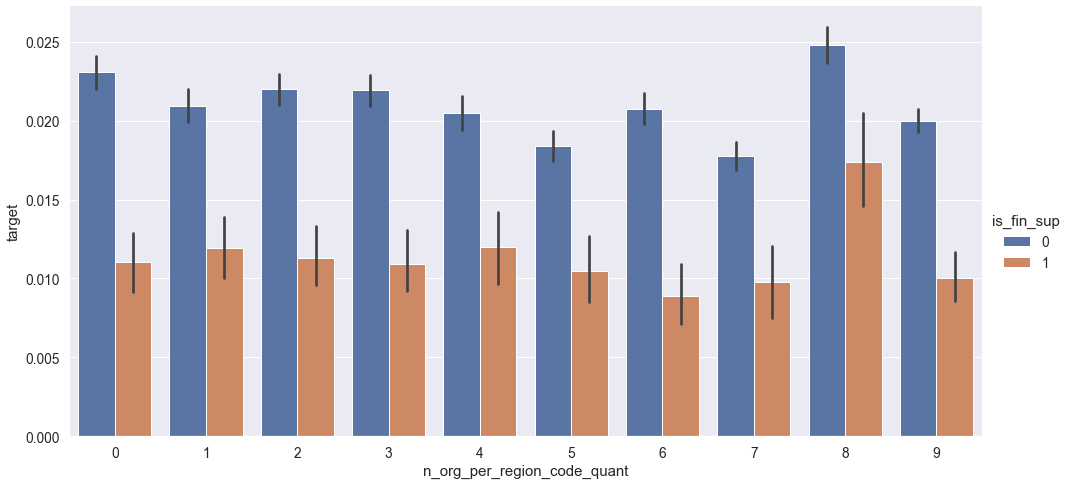

In [297]:
sns.catplot(
    data=X_train, x="n_org_per_region_code_quant", y="target", hue='is_fin_sup',
    kind="bar", height=7, aspect=2
)

- достаточно плавненько, столбец 8 - регионы с численностью организаций (52159.0, 75485.0]
- сами интервалы

In [298]:
pd.qcut(X_train.n_org_per_region_code, q=11, duplicates='drop').unique()

[(75485.0, 158991.0], (30070.0, 52159.0], (11625.0, 18334.0], (24228.0, 30070.0], (4730.0, 7194.0], (146.999, 4730.0], (9576.0, 11625.0], (7194.0, 9576.0], (52159.0, 75485.0], (18334.0, 24228.0]]
Categories (10, interval[float64, right]): [(146.999, 4730.0] < (4730.0, 7194.0] < (7194.0, 9576.0] < (9576.0, 11625.0] ... (24228.0, 30070.0] < (30070.0, 52159.0] < (52159.0, 75485.0] < (75485.0, 158991.0]]

In [299]:
X_train.loc[X_train.n_org_per_region_code_quant == 8, 'region_code'].unique()

array([78], dtype=int8)

- по наибольшей концентрации таргета (абсолютное число)

In [302]:
abs_regions = X_train.groupby('region_code')['target'].sum().sort_values(ascending=False).head(10).index

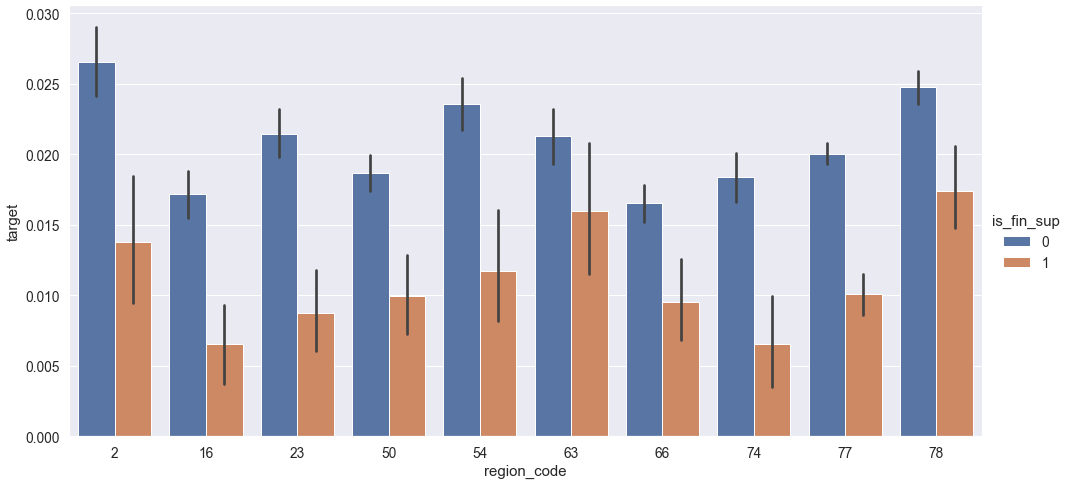

In [303]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(abs_regions)], x="region_code", y="target", hue='is_fin_sup',
    kind="bar", height=7, aspect=2
)

- естественно, практически совпадает со списком регионов, максимальных по численности
- но вот регион 63 - интересный (Самарская область)

- по относительной концентрации таргета

In [309]:
target_fract_per_region = X_train.groupby('region_code').agg(count_target=('target', 'count'), sum_target=('target', 'sum'))
target_fract_per_region['target_fract_per_region'] = tmp_2.sum_target / tmp_2.count_target
target_fract_per_region.sort_values('target_fract_per_region', ascending=False)

count_target  sum_target  target_fract_per_region
region_code                                                   
89                   1995          64                 0.032080
11                   2694          85                 0.031552
8                     377          11                 0.029178
13                   2858          82                 0.028691
35                  10063         283                 0.028123
...                   ...         ...                      ...
76                  11233         154                 0.013710
5                    3222          41                 0.012725
15                   2252          27                 0.011989
6                    1014           9                 0.008876
83                    234           2                 0.008547

[85 rows x 3 columns]

- и заодно новый признак - ранг региона в зависимости от... -**target_fract_per_region**

In [310]:
X_train['target_fract_per_region'] = X_train.region_code.replace(target_fract_per_region['target_fract_per_region'])

In [311]:
bad_regions = target_fract_per_region.sort_values('target_fract_per_region', ascending=False).head(10).index
best_regions = target_fract_per_region.sort_values('target_fract_per_region', ascending=False).tail(10).index
best_regions

Int64Index([36, 59, 20, 32, 52, 76, 5, 15, 6, 83], dtype='int64', name='region_code')

- худшие регионы

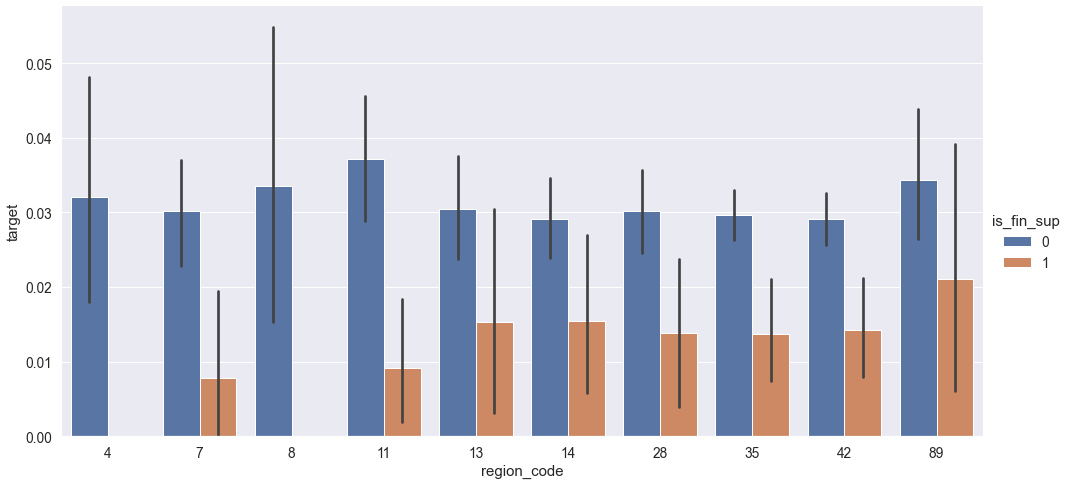

In [306]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(bad_regions)], x="region_code", y="target", hue='is_fin_sup',
    kind="bar", height=7, aspect=2
)

11 - Республика Коми, но здесь очень эффективна поддержка (хотя значений немного и полоса ошибки большая)

- лучшие

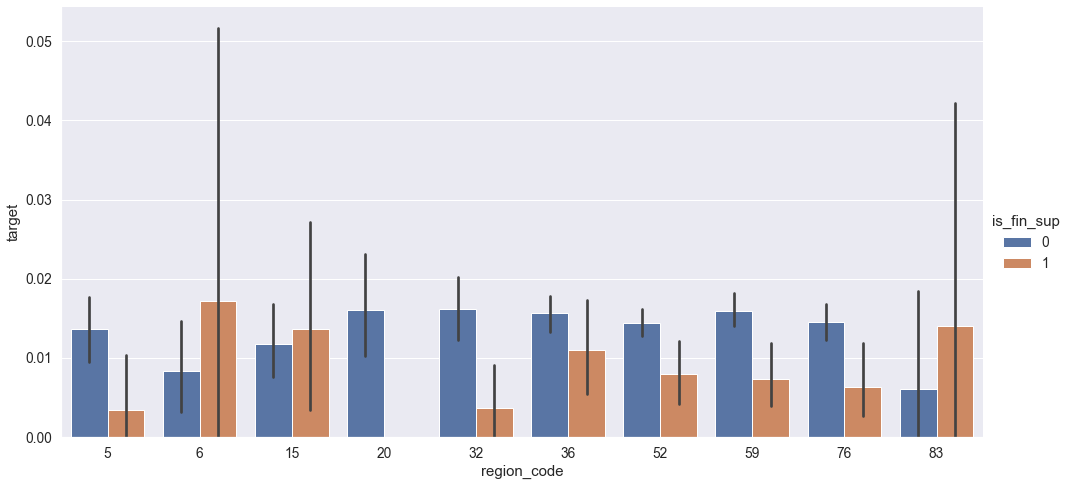

In [313]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(best_regions)], x="region_code", y="target", hue='is_fin_sup',
    kind="bar", height=7, aspect=2
)

- где на Руси жить хорошо
- интересные регионы 6 (респ. Ингушетия), 15 (Республика Северная Осетия-Алания) и 83 (Ненецкий автономный округ) (если опять же не обратить внимание на полосу ошибки)

- а если брать размер поддержки, а не только её факт
- размер субсидий и грантов по таргету для топ-10 регионов по численности

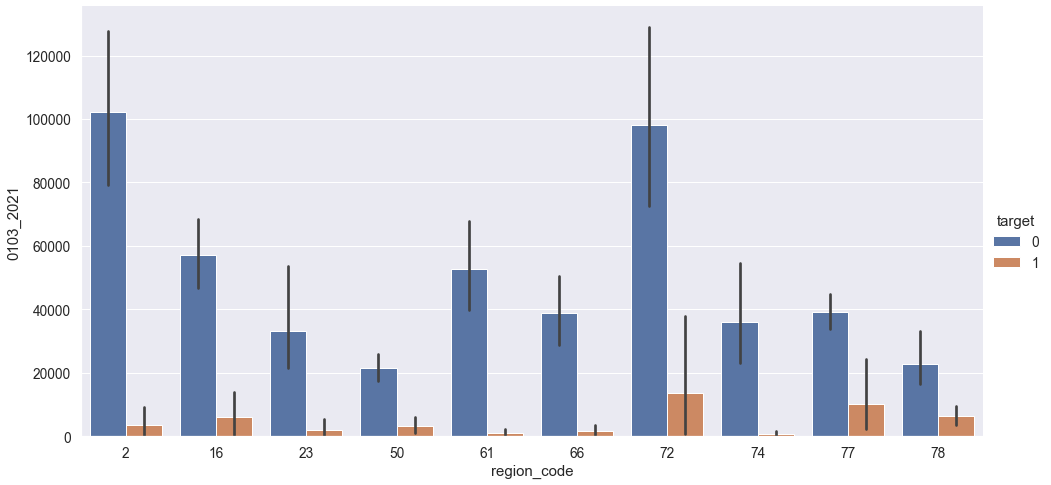

In [315]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values)], 
    x="region_code", y="0103_2021", hue='target',
    kind="bar", height=7, aspect=2
)

- в среднем, активные на 22-23гг. предприятия получали за 20-21 гг. большую фин. поддержку
- заметно большую
- есть регионы, для которых это не так?

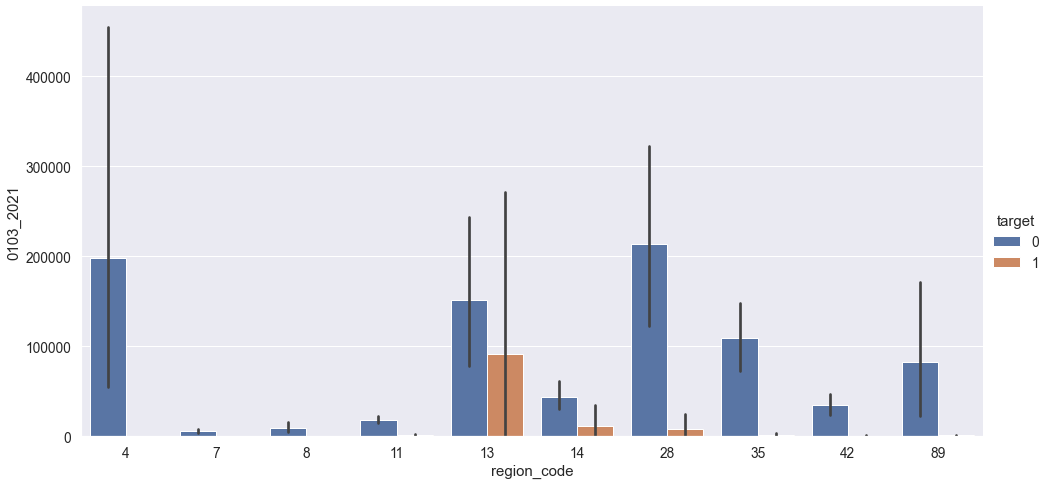

In [319]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(bad_regions)], 
    x="region_code", y="0103_2021", hue='target',
    kind="bar", height=7, aspect=2
)

- назад к сырым признакам:

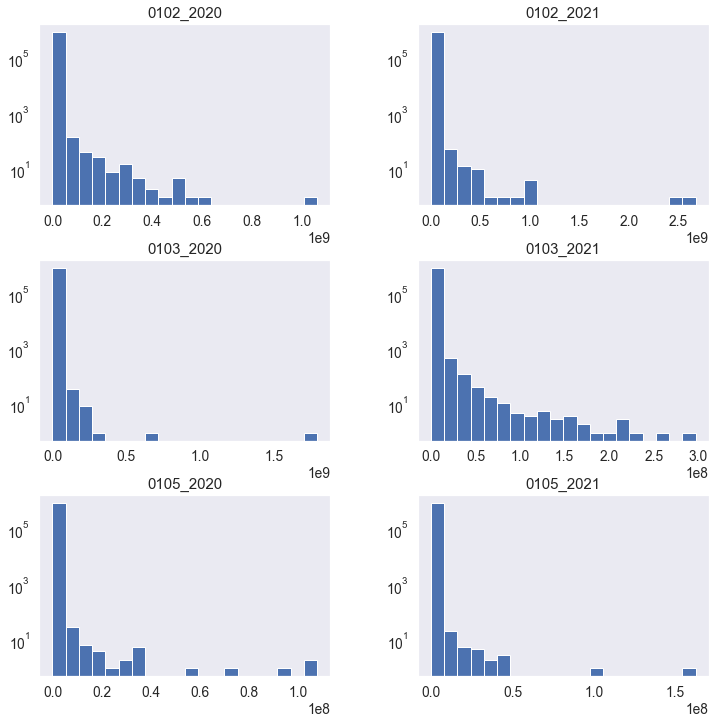

In [329]:
X_train[fin_sup_col].hist(figsize=(12, 12), bins=20, grid=False, log=True);

- выбросы

In [324]:
fin_sup_col_med = [f'{col}_med' for col in fin_sup_col]
fin_sup_col_q95 = [f'{col}_q95' for col in fin_sup_col]

In [325]:
for col in fin_sup_col:
    X_train = pd.concat([X_train, cut_outliers(X_train[col])], axis=1)

- обрезка выбросов большого смысла не имеет

In [331]:
fin_sup_corr = X_train[fin_sup_col + ['target']].corr()

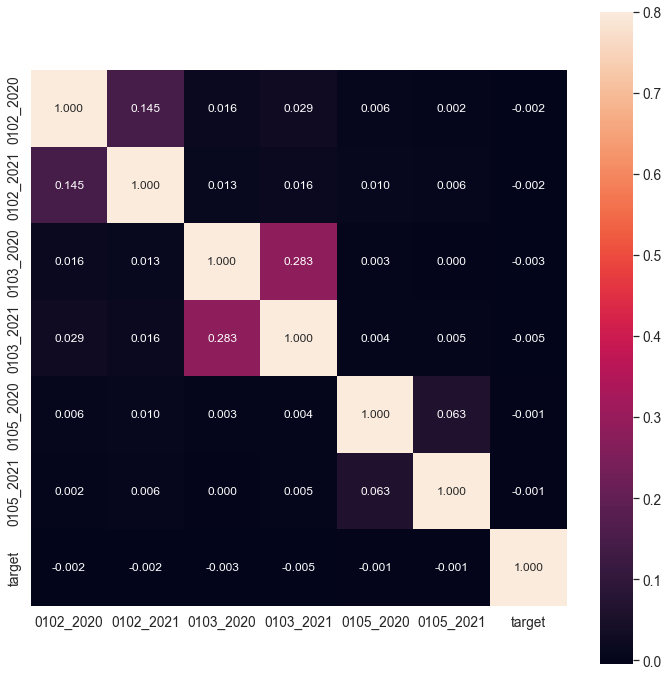

In [332]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(fin_sup_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.3f', 
            annot_kws={'size': 12});

- небольшие отрицательные корреляции с таргетом

#### 1.4.6. штрафы и нарушения по состоянию на 21 г

         'arrears', - недоимка
         'penalties', - пени
         'fines', - штраф
         'fine_amount', - сумма штрафа по налоговым нарушениям

In [333]:
fines_col = ['arrears', 'penalties', 'fines', 'fine_amount']
fines_col_med = [f'{col}_med' for col in fines_col]
fines_col_q95 = [f'{col}_q95' for col in fines_col]

In [334]:
X_train[fines_col].isnull().sum()

arrears        0
penalties      0
fines          0
fine_amount    0
dtype: int64

In [335]:
X_train[fines_col].describe()

arrears     penalties         fines   fine_amount
count  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05
mean   9.302804e+04  3.668978e+04  9.432697e+03  2.097111e+03
std    8.785817e+06  2.474202e+06  1.827100e+06  2.212859e+05
min   -1.995578e+06  0.000000e+00 -6.553725e+04  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    0.000000e+00  7.731000e+01  0.000000e+00  0.000000e+00
max    5.495136e+09  1.148000e+09  1.215472e+09  1.222110e+08

- режем выбросы, но скорее всего занулит

In [337]:
for col in fines_col:
    X_train = pd.concat([X_train, cut_outliers(X_train[col])], axis=1)

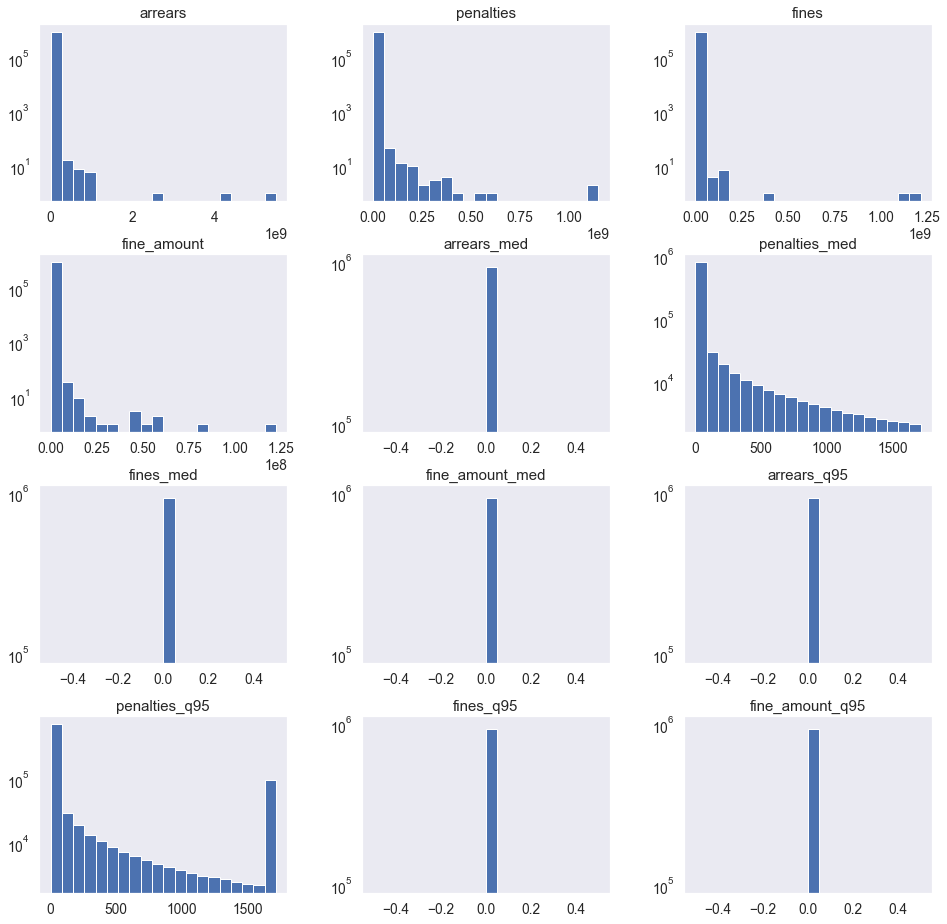

In [338]:
X_train[fines_col + fines_col_med + fines_col_q95].hist(figsize=(16, 16), bins=20, grid=False, log=True);

- только пени не занулило

In [339]:
fines_corr = X_train[fines_col + fines_col_med + fines_col_q95 + ['target']].corr()

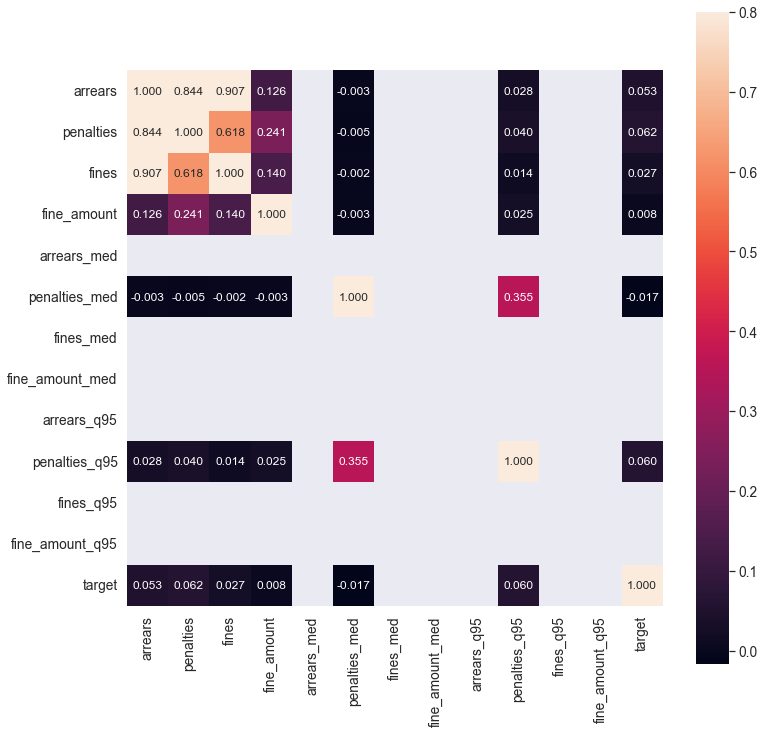

In [340]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(fines_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.3f', 
            annot_kws={'size': 12});

- можно сделать log для всех
- можно сложить arrears + penalties + fines

- новый признак - налоговая задолженность **tax_arrears**: 'arrears' + 'penalties' + 'fines'

In [341]:
X_train['tax_arrears'] = X_train.arrears + X_train.penalties + X_train.fines

- логарифмы

In [342]:
fines_col_log = [f'{col}_log' for col in fines_col + ['tax_arrears']]

- там есть отрицательные значения

In [343]:
for col, col_log in zip(fines_col + ['tax_arrears'], fines_col_log):
    X_train[col_log] = np.log(X_train[col] + 1)

C:\Users\013\AppData\Roaming\Python\Python38\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [344]:
X_train[fines_col].describe()

arrears     penalties         fines   fine_amount
count  9.360000e+05  9.360000e+05  9.360000e+05  9.360000e+05
mean   9.302804e+04  3.668978e+04  9.432697e+03  2.097111e+03
std    8.785817e+06  2.474202e+06  1.827100e+06  2.212859e+05
min   -1.995578e+06  0.000000e+00 -6.553725e+04  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    0.000000e+00  7.731000e+01  0.000000e+00  0.000000e+00
max    5.495136e+09  1.148000e+09  1.215472e+09  1.222110e+08

-  размер штрафов по таргету для топ-10 регионов - ничего не видно

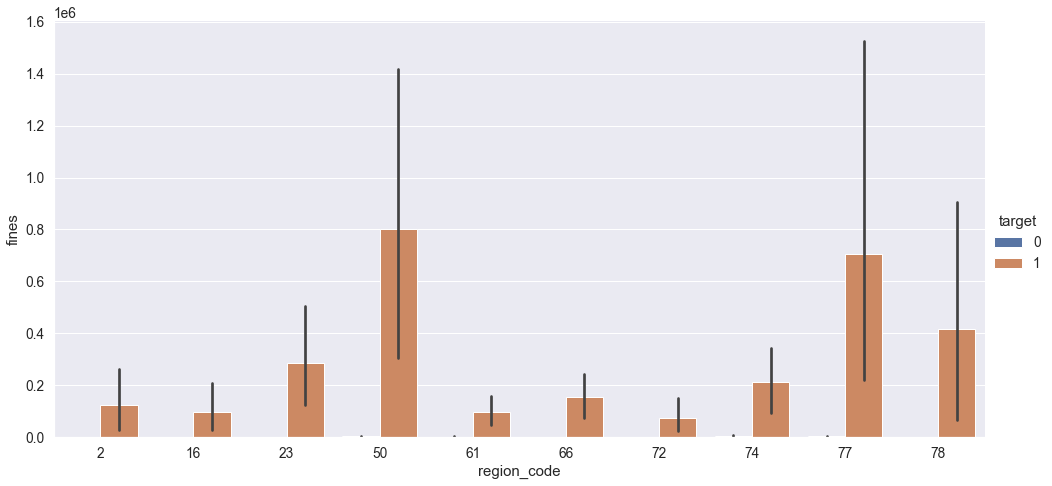

In [347]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values)], 
    x="region_code", y="fines", hue='target',
    kind="bar", height=7, aspect=2
)

- ну тут хотя бы уже сравнить можно, хотя логарифм сравнивать по высоте...

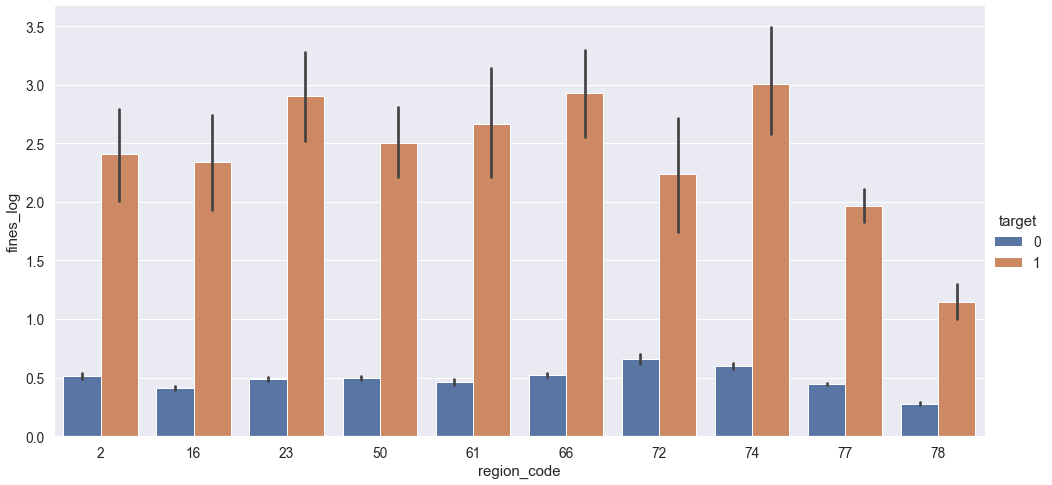

In [348]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values)], x="region_code", y="fines_log", hue='target',
    kind="bar", height=7, aspect=2
)

- средняя tax_arrears для региона и оквед - **tax_arr_per_reg_okved**

In [349]:
x = [el for el in product(X_train.region_code.unique(), X_train.okved2_1.unique())]
tmp_x = pd.DataFrame(x, columns=['region_code', 'okved2_1'])

In [350]:
tmp_x['tax_arr_per_reg_okved'] = tmp_x.apply(lambda x: X_train.loc[(X_train.region_code == x.region_code) & (X_train.okved2_1 == x.okved2_1), 'tax_arrears'].mean(), axis=1)
tmp_x.head(5)

region_code  okved2_1  tax_arr_per_reg_okved
0           77        46          144781.187500
1           77        55           30825.593750
2           77        71          241879.609375
3           77        96           21014.839844
4           77        86           16524.625000

- теперь заполнить пропуски пусть будет среднее по okved - хотя мб лучше по региону?

In [352]:
mean_okved = X_train.groupby('okved2_1')['tax_arrears'].mean()

In [353]:
tmp_x.loc[tmp_x.tax_arr_per_reg_okved.isna(), 'tax_arr_per_reg_okved'] = tmp_x.loc[tmp_x.tax_arr_per_reg_okved.isna(), 'okved2_1'].replace(mean_okved)

In [354]:
tmp_x.isna().sum()

region_code              0
okved2_1                 0
tax_arr_per_reg_okved    0
dtype: int64

- осталось смержить с основным датасетом

In [355]:
X_train = X_train.merge(tmp_x, how='left', on=['region_code', 'okved2_1'])

- внезапно логарифм неплох - **tax_arr_per_reg_okved_log**

tax_arr_per_reg_okved
Ассиметрия: -0.6667850016494239, эксцесс: 1.2038967381982086
Корреляция с таргетом: 0.022348355013445308


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


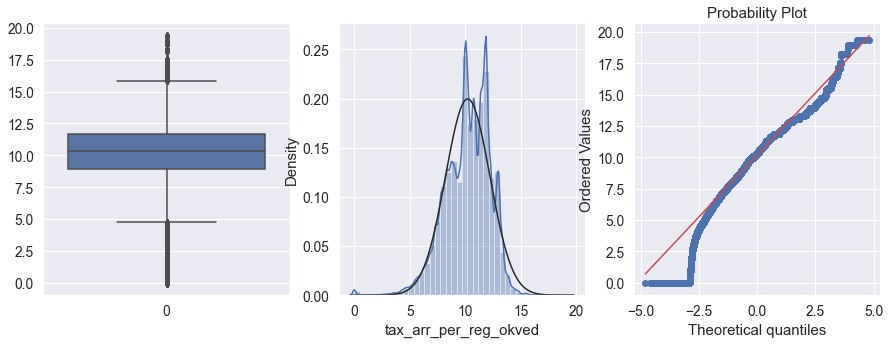

In [357]:
get_describe(np.log(X_train.tax_arr_per_reg_okved + 1))

In [358]:
X_train['tax_arr_per_reg_okved_log'] = np.log(X_train.tax_arr_per_reg_okved + 1)

#### 1.4.7 данные о ценах по регионам

         'AI92_cost_2020',
         'AI92_cost_2021',
         'AI92_volume_2020',
         'AI92_volume_2021',
         'AI95_cost_2020',
         'AI95_cost_2021',
         'AI95_volume_2020',
         'AI95_volume_2021',
         'AI98_cost_2020',
         'AI98_cost_2021',
         'AI98_volume_2020',
         'AI98_volume_2021',
         'cons_basket_child_2020',
         'cons_basket_child_2021',
         'cons_basket_pens_2020',
         'cons_basket_pens_2021',
         'cons_basket_working_age_2020',
         'cons_basket_working_age_2021',
         'diesel_cost_2020',
         'diesel_cost_2021',
         'diesel_volume_2020',
         'diesel_volume_2021',

In [359]:
cons_basket = ['cons_basket_child_2020',
               'cons_basket_child_2021',
               'cons_basket_pens_2020',
               'cons_basket_pens_2021',
               'cons_basket_working_age_2020',
               'cons_basket_working_age_2021',]
fuels_cost = ['AI92_cost_2020',
              'AI92_cost_2021',          
              'AI95_cost_2020',
              'AI95_cost_2021',              
              'AI98_cost_2020',
              'AI98_cost_2021',              
              'diesel_cost_2020',
              'diesel_cost_2021']
fuels_volume = ['AI92_volume_2020',
                'AI92_volume_2021',
                'AI95_volume_2020',
                'AI95_volume_2021',
                'AI98_volume_2020',
                'AI98_volume_2021',
                'diesel_volume_2020',
                'diesel_volume_2021']

In [360]:
X_train[cons_basket + fuels_cost + fuels_volume].isna().sum()

cons_basket_child_2020          0
cons_basket_child_2021          0
cons_basket_pens_2020           0
cons_basket_pens_2021           0
cons_basket_working_age_2020    0
cons_basket_working_age_2021    0
AI92_cost_2020                  0
AI92_cost_2021                  0
AI95_cost_2020                  0
AI95_cost_2021                  0
AI98_cost_2020                  0
AI98_cost_2021                  0
diesel_cost_2020                0
diesel_cost_2021                0
AI92_volume_2020                0
AI92_volume_2021                0
AI95_volume_2020                0
AI95_volume_2021                0
AI98_volume_2020                0
AI98_volume_2021                0
diesel_volume_2020              0
diesel_volume_2021              0
dtype: int64

- нулей и отрицательных нет

In [361]:
X_train[cons_basket + fuels_cost + fuels_volume].min()

cons_basket_child_2020          4511.396973
cons_basket_child_2021          4990.445312
cons_basket_pens_2020           3804.358887
cons_basket_pens_2021           4272.634766
cons_basket_working_age_2020    4465.030762
cons_basket_working_age_2021    5013.056641
AI92_cost_2020                    30.757460
AI92_cost_2021                    38.785423
AI95_cost_2020                    43.145874
AI95_cost_2021                    45.335342
AI98_cost_2020                    45.099998
AI98_cost_2021                    40.564110
diesel_cost_2020                  44.108742
diesel_cost_2021                  46.466850
AI92_volume_2020                5039.136719
AI92_volume_2021                4162.756348
AI95_volume_2020                1060.030029
AI95_volume_2021                1611.229370
AI98_volume_2020                   3.230874
AI98_volume_2021                  74.461784
diesel_volume_2020               824.203613
diesel_volume_2021               720.267334
dtype: float32

- сырые

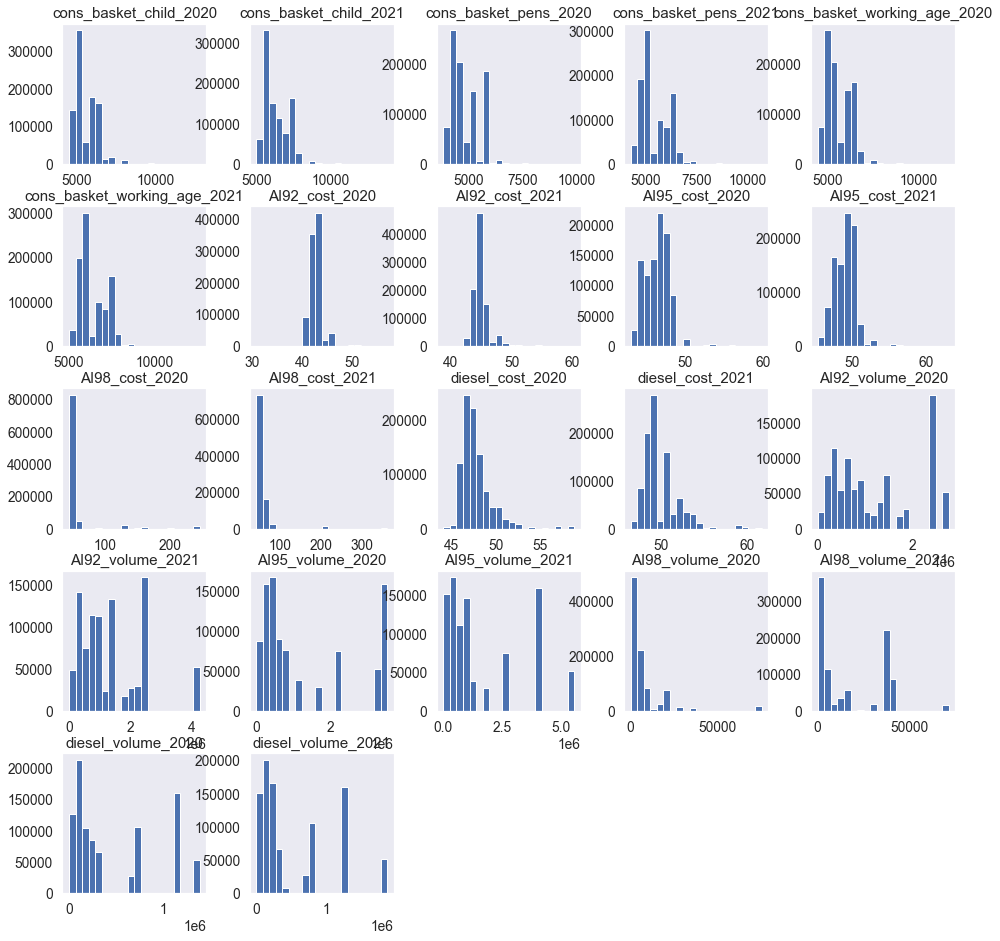

In [363]:
X_train[cons_basket + fuels_cost + fuels_volume].hist(figsize=(16, 16), bins=20, grid=False);

- корреляции

- сырые

In [364]:
costs_corr = X_train[cons_basket + fuels_cost + fuels_volume + ['target']].corr()

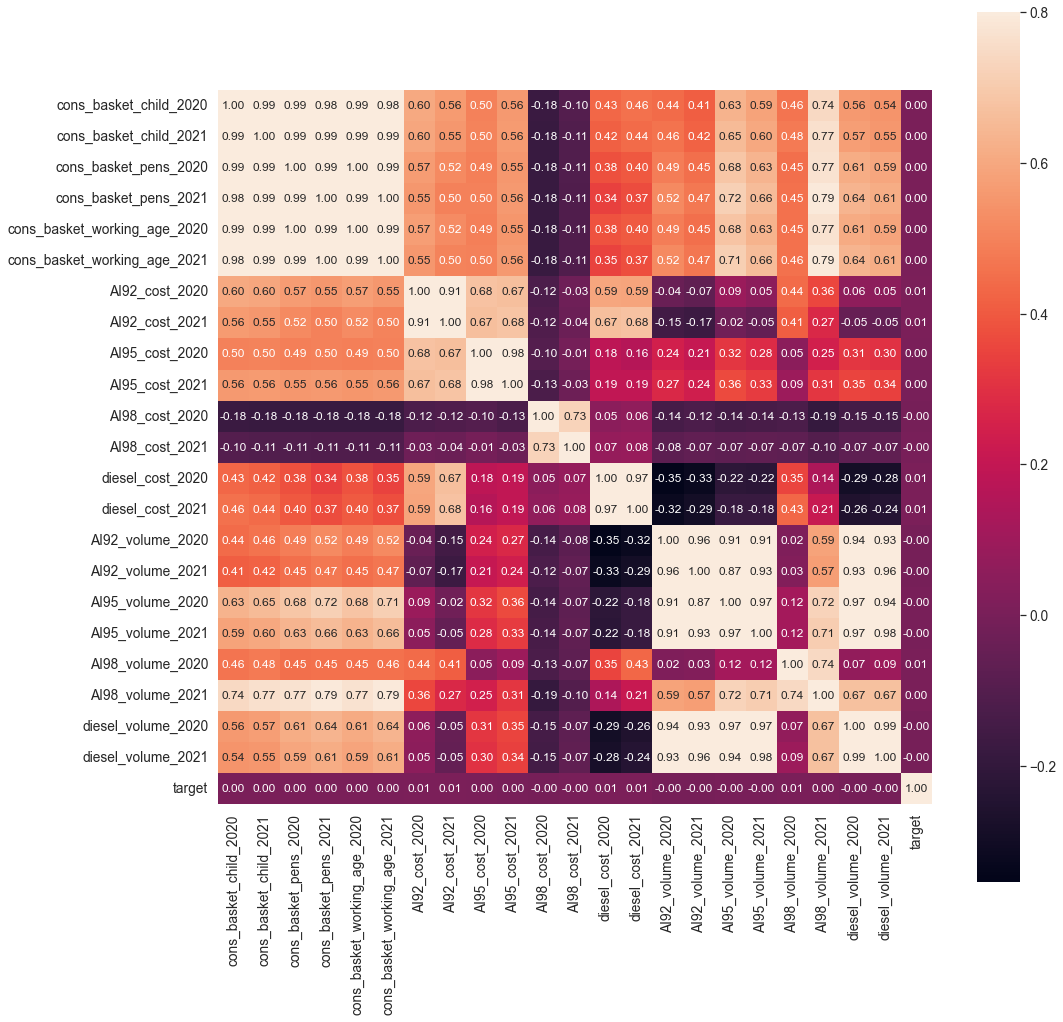

In [365]:
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(costs_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.2f', 
            annot_kws={'size': 12});

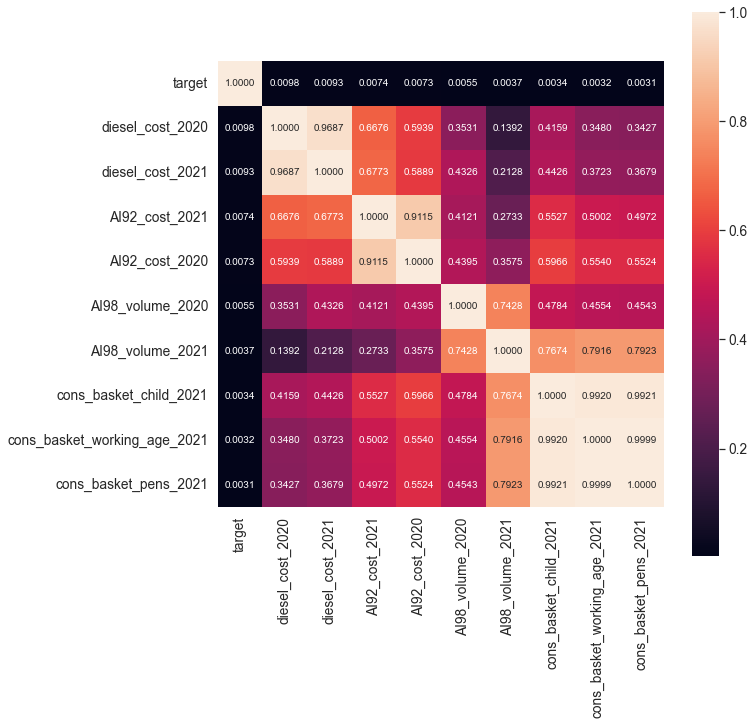

In [366]:
f, ax = plt.subplots(figsize=(10, 10))
k = 10 #number of variables for heatmap
cols = costs_corr.nlargest(k, 'target')['target'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.4f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- потребительскую корзину сразу объединяем: max, sum, mean - что лучше? - проще взять за 21 г.
- стоимость топлива - 20 и 21 год высокая коррел - но для некоторых данные за 20 чуть теснее связаны с таргетом
- а вот объём топлива -  ai95 различен.

- новые признаки для потребительской корзины: **cons_basket_max**, **cons_basket_mean**

In [367]:
X_train['cons_basket_max'] = X_train[cons_basket].max(axis=1)
X_train['cons_basket_mean'] = X_train[cons_basket].mean(axis=1)
X_train['cons_basket_min'] = X_train[cons_basket].min(axis=1)

cons_basket_max
Ассиметрия: 0.8181085586547852, эксцесс: 0.6921465992927551
Корреляция с таргетом: 0.0034430463027213263


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


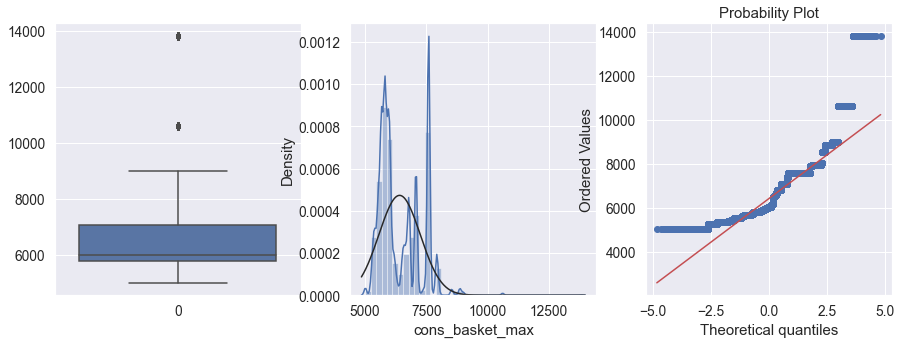

In [368]:
get_describe(X_train.cons_basket_max)

cons_basket_mean
Ассиметрия: 0.8054793477058411, эксцесс: 0.5961365699768066
Корреляция с таргетом: 0.0030440047858676816


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


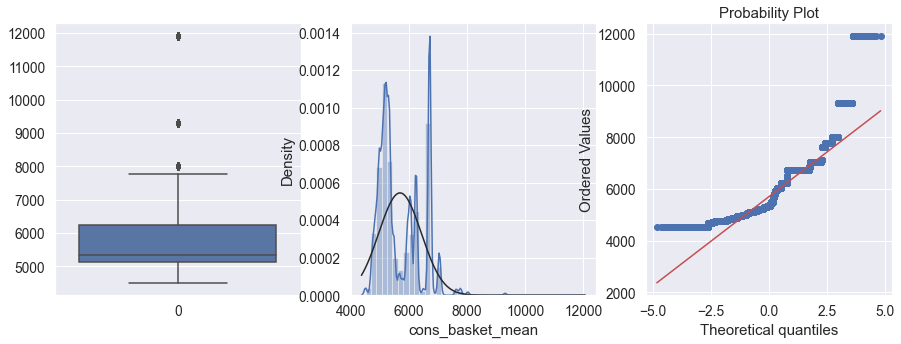

In [369]:
get_describe(X_train.cons_basket_mean)

cons_basket_min
Ассиметрия: 0.720637857913971, эксцесс: 0.290290892124176
Корреляция с таргетом: 0.0027268241454768702


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


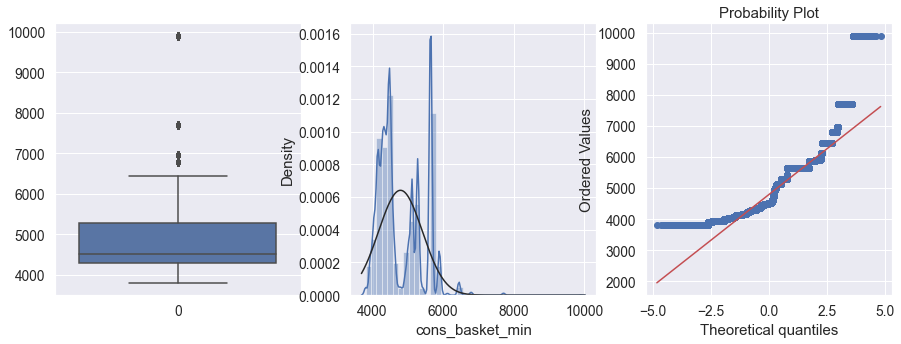

In [370]:
get_describe(X_train.cons_basket_min)

- max смотрится получше, сумма тоже не впечатлила

выбросы

In [371]:
fuels_cost_med = [f'{col}_med' for col in fuels_cost]
fuels_cost_q95 = [f'{col}_q95' for col in fuels_cost]

fuels_volume_med = [f'{col}_med' for col in fuels_volume]
fuels_volume_q95 = [f'{col}_q95' for col in fuels_volume]

In [372]:
for col in ['cons_basket_max'] + fuels_cost + fuels_volume:
    X_train = pd.concat([X_train, cut_outliers(X_train[col])], axis=1)

- логарифм?

In [376]:
costs_col_log = [f'{col}_log' for col in ['cons_basket_max_q95'] + fuels_cost_q95 + fuels_volume_q95]

for col in ['cons_basket_max_q95'] + fuels_cost_q95 + fuels_volume_q95:
    X_train[f'{col}_log'] = np.log(X_train[col])

- объём топлива можно нормировать по численности населения региона  **fuels_volume_norm**

In [377]:
fuels_volume_norm = [f'{col}_norm' for col in fuels_volume]

In [378]:
for col in fuels_volume:
    X_train[f'{col}_norm'] = X_train[col] / X_train.region_population

- вроде, не лишено смысла для некоторых столбцов

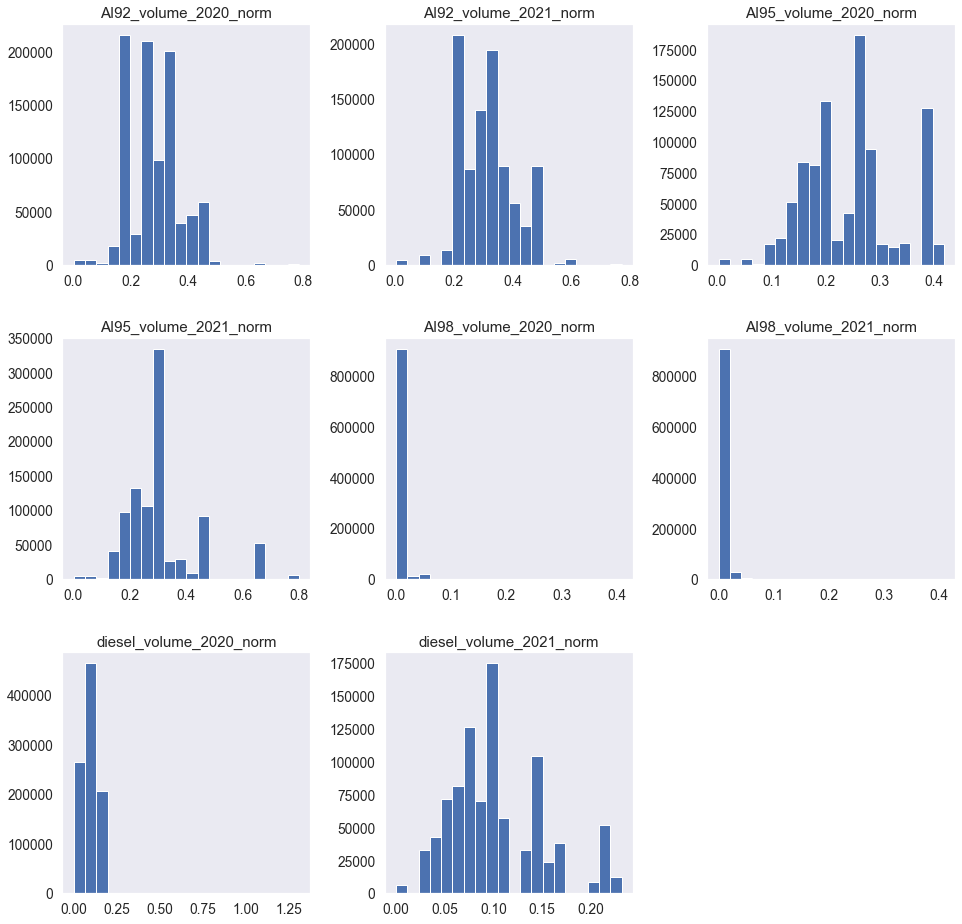

In [379]:
X_train[fuels_volume_norm].hist(figsize=(16, 16), bins=20, grid=False);

- обрежем выбросы - q95,

In [380]:
fuels_volume_norm_q95 = [f'{col}_q95' for col in fuels_volume_norm]

In [381]:
for col in fuels_volume_norm:
    q_95 = X_train[col].quantile(0.9)
    q_05 = X_train[col].quantile(0.05)
    X_train[f'{col}_q95'] = X_train[col].where(X_train[col] <= q_95, q_95).where(X_train[col] >= 0.05, q_05)

- топ10 регионов по объёмам продажи дизельного топлива
- то же самое можно посмотреть по стоимости, но это не очень показательно - надо как-то иначе визуализировать

In [385]:
top10_vol = X_train.groupby('region_code')['diesel_volume_2021'].first().sort_values(ascending=False).index[:10].values
top10_vol

array([50, 77, 78, 23, 16, 47, 61, 66, 91,  2], dtype=int64)

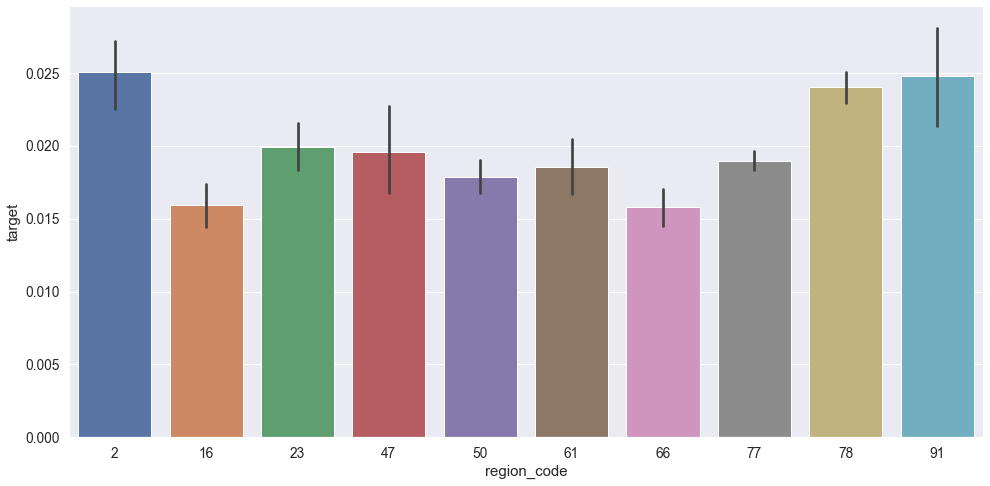

In [386]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_vol)], 
    x="region_code", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- хвост-10

In [388]:
tail_10_vol = X_train.groupby('region_code')['diesel_volume_2021'].first().sort_values().index[:10].values

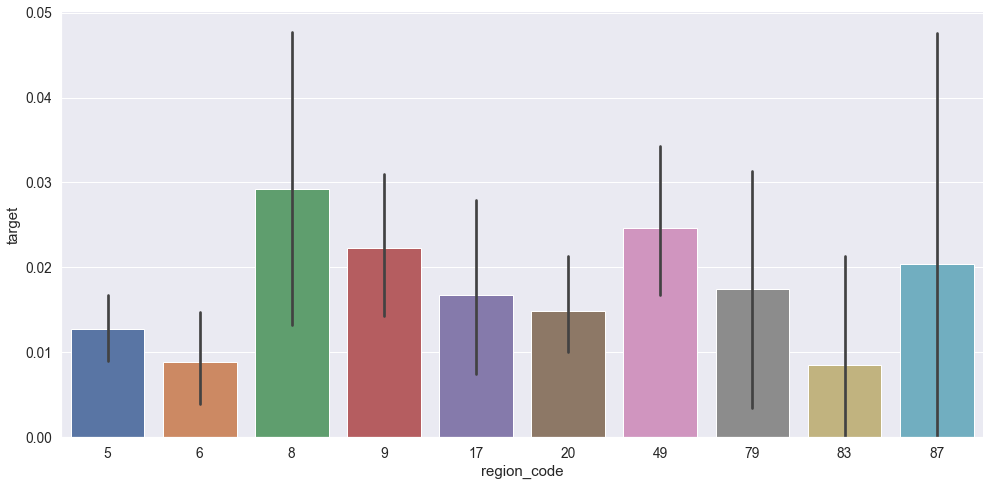

In [389]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(tail_10_vol)], 
    x="region_code", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- зависимость топлива от численности по региона

C:\Users\013\AppData\Roaming\Python\Python38\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


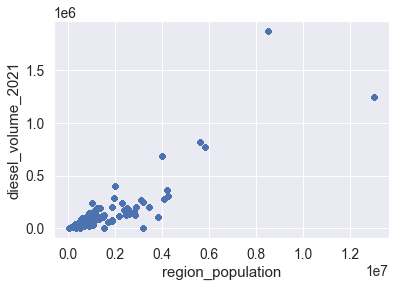

In [390]:
X_train.plot.scatter('region_population', 'diesel_volume_2021');

- и здесь интересно: при малой численности населения топливо может быть как дорогим, так и дешёвым, а вот при большой численности - всё же стоимость падает

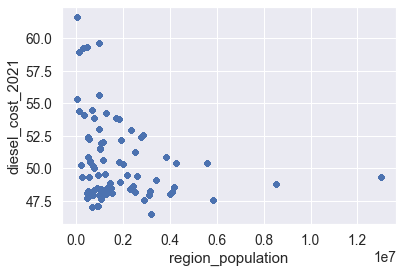

In [391]:
X_train.plot.scatter('region_population', 'diesel_cost_2021');

- все подряд, примерно всё одно и то же

In [ ]:
# for col in ['cons_basket_max'] + fuels_cost + fuels_volume:
#     print(col)
#     X_train.plot.scatter('region_population', col)
#     plt.show()

квантили по дизелю, чтобы только посмотреть 

In [392]:
# здесь квантили на нормированном объёме,иначе один столбец и всё
X_train['diesel_vol_quant'] = pd.qcut(X_train.diesel_volume_2021_norm, q=4, labels=range(4))
X_train['diesel_cost_quant'] = pd.qcut(X_train.diesel_cost_2021, q=6)

- график по нормированному объёму - для топ-10 регионов

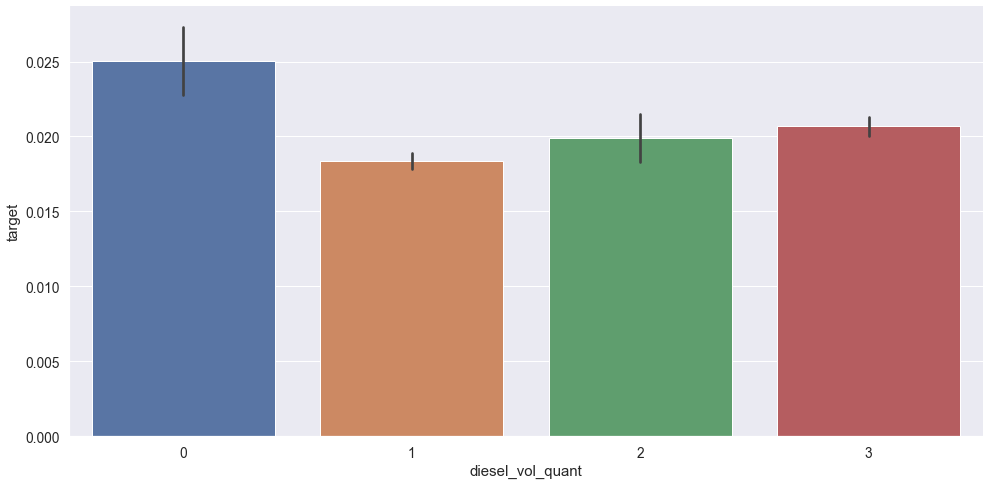

In [393]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_vol)], 
    x="diesel_vol_quant", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- в 0 квантиль попадают регионы: = минимальный объём дизеля на душу населения
- но не очень

In [394]:
X_train.diesel_volume_2021_norm.value_counts(bins=4, sort=False)

(-0.000754, 0.0582]    153472
(0.0582, 0.116]        509774
(0.116, 0.174]         199366
(0.174, 0.231]          73388
Name: diesel_volume_2021_norm, dtype: int64

In [395]:
X_train.loc[X_train.diesel_vol_quant == 0].region_code.unique()

array([24, 54, 86, 55, 20, 56, 35, 64, 26,  2, 13, 74, 75, 22, 14, 42, 27,
       45,  7, 72, 30, 70, 68,  9, 15, 19,  5, 46, 89, 17,  6, 79,  8],
      dtype=int8)

- график по стоимости

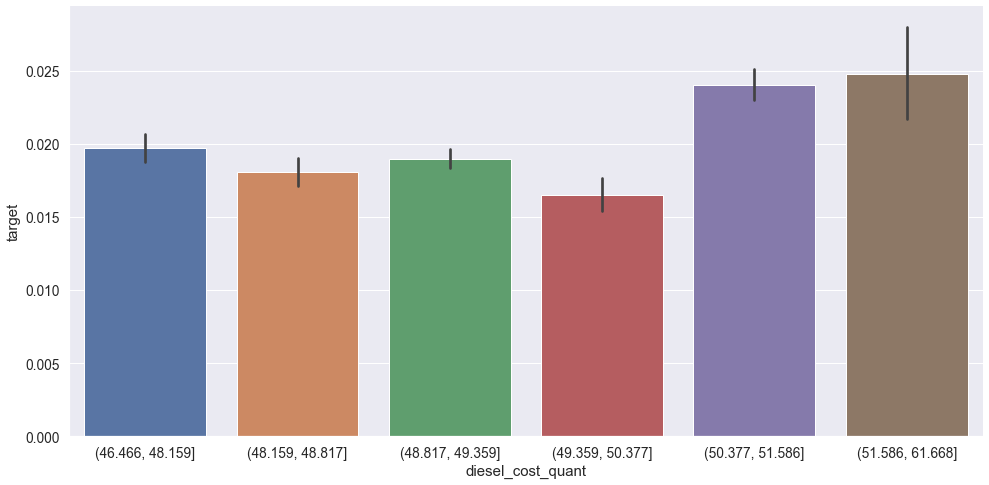

In [396]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_vol)], 
    x="diesel_cost_quant", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- чем дороже, тем чуть больше вероятность таргета, но это не точно
- можно то же самое сделать по другим видам топлива, какой-то ai там был показательным

#### 1.4.8 контракты, продукты, доп виды деятельности...

         'n_contracts', наличие в предшествующем календарном году контрактов, заключенных для обеспечения государственных и муниципальных нужд (№44-ФЗ)
         'n_agreements', - число договоров, закл в соотв с ФЗ №223-ФЗ О закупках товаров, работ, услу
         'n_okovd_add',
         'n_licenses',
         'n_products',

In [397]:
count_col = ['n_contracts', 'n_agreements', 'n_okovd_add', 'n_licenses', 'n_products',]

In [398]:
X_train[count_col].isna().sum()

n_contracts     0
n_agreements    0
n_okovd_add     0
n_licenses      0
n_products      0
dtype: int64

In [399]:
X_train[count_col].describe()

n_contracts   n_agreements    n_okovd_add     n_licenses  \
count  936000.000000  936000.000000  936000.000000  936000.000000   
mean        0.004851       0.001556      17.224729       0.192392   
std         1.336810       0.201458      20.746728       0.752348   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       6.000000       0.000000   
50%         0.000000       0.000000      12.000000       0.000000   
75%         0.000000       0.000000      22.000000       0.000000   
max      1084.000000      88.000000    2420.000000     251.000000   

          n_products  
count  936000.000000  
mean        0.003525  
std         0.237494  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        70.000000

- есть вероятность что те, у кого есть контракты/договора - мб чьими-то дочерними предприятиями

- некоторые max очень подозрительны
- значения распределены очень неравномерно - за искл n_okovd_add
- выбросы скорее всего надо будет резать

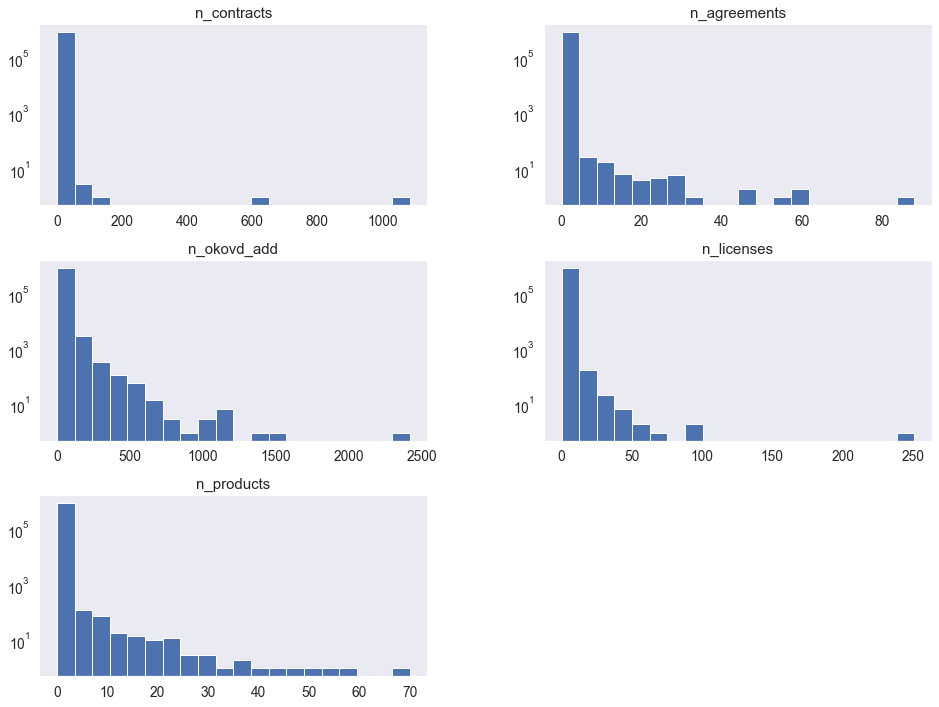

In [400]:
X_train[count_col].hist(figsize=(16, 12), bins=20, grid=False, log=True);

- для доп видов деятельности - однозначно логарифм
- для остальных можно просто попробовать

- но однозначно режем выбросы

- режем

In [405]:
count_col_med = [f'{col}_med' for col in count_col]
count_col_q95 = [f'{col}_q95' for col in count_col]

In [406]:
for col in count_col:
    X_train = pd.concat([X_train, cut_outliers(X_train[col])], axis=1)

In [409]:
new_count_col = ['n_contracts', 'n_agreements', 'n_okovd_add', 'n_licenses_q95', 'n_products']
count_col_log = [f'{col}_log' for col in new_count_col]

In [410]:
for col in new_count_col:
    X_train[f'{col}_log'] = np.log(X_train[col] + 1)

#### 1.4.9 n_employees - среднесписочная численность работников за предыдущий год

- здесь были пропуски, они обозначены -1, хотя значение 0 тоже странно

- оказалось, что заполнение пропусков ничуть не улучшает

In [413]:
X_train.loc[X_train.n_employees < 0, 'n_employees'].shape

(36884,)

- те это вполне могут быть действующие организации - причём в любой категории

In [414]:
X_train.loc[X_train.n_employees == -1, ['statusCode', 'subj_cat']].value_counts()

statusCode            subj_cat
ACTIVE                1           33632
                      2            1906
LIQUIDATION_STAGE     1             777
ACTIVE                3             291
INACTIVE              1             135
REORGANIZATION_STAGE  1              67
LIQUIDATION_STAGE     2              45
REORGANIZATION_STAGE  2              17
LIQUIDATION_STAGE     3               6
INACTIVE              2               4
REORGANIZATION_STAGE  3               3
INACTIVE              3               1
dtype: int64

- заполню пропуски медианой для subj_cat

In [415]:
n_empl_med = X_train.groupby('subj_cat')['n_employees'].median()
n_empl_med

subj_cat
1      1.0
2     22.0
3    101.0
Name: n_employees, dtype: float64

In [416]:
X_train['n_employees_1'] = X_train.n_employees.where(X_train.n_employees >= 0, X_train.subj_cat.replace(n_empl_med))

- выбросы

In [417]:
X_train = pd.concat([X_train, cut_outliers(X_train.n_employees)], axis=1)

n_employees_q95
Ассиметрия: 1.4010394963422677, эксцесс: 0.5850836047144319
Корреляция с таргетом: -0.04783930339078939


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


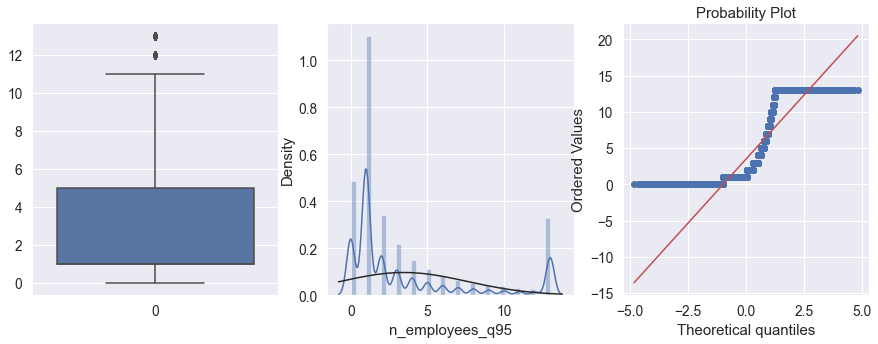

In [418]:
get_describe(X_train.n_employees_q95)

- логарифм

In [419]:
X_train['n_employees_q95_log'] = np.log(X_train.n_employees_q95 + 1)

- а он достаточно неплох

n_employees_q95_log
Ассиметрия: 0.47679946973824855, эксцесс: -0.799655195393925
Корреляция с таргетом: -0.06258492878188737


C:\Users\013\AppData\Local\Temp/ipykernel_5820/2270805538.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(col, bins=bins, fit=norm)


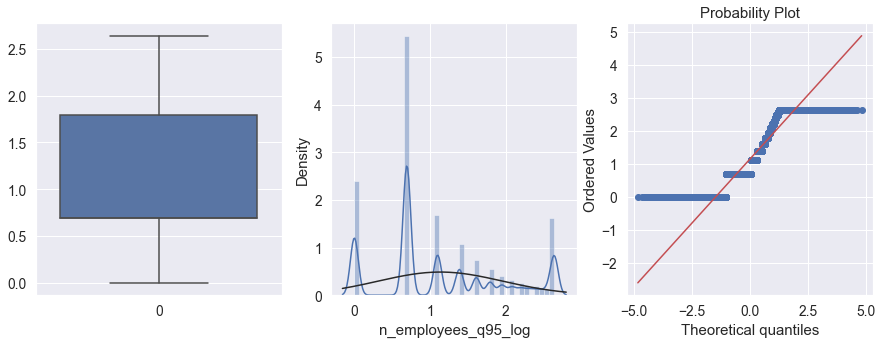

In [420]:
get_describe(X_train.n_employees_q95_log)

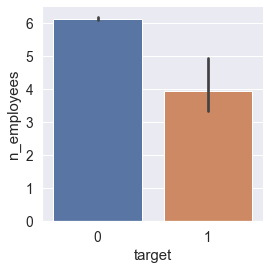

In [422]:
sns.catplot(
    data=X_train, x="target", y="n_employees",
    kind="bar", height=4, aspect=1,
)

- смотрим по регионам

- топ10 по численности

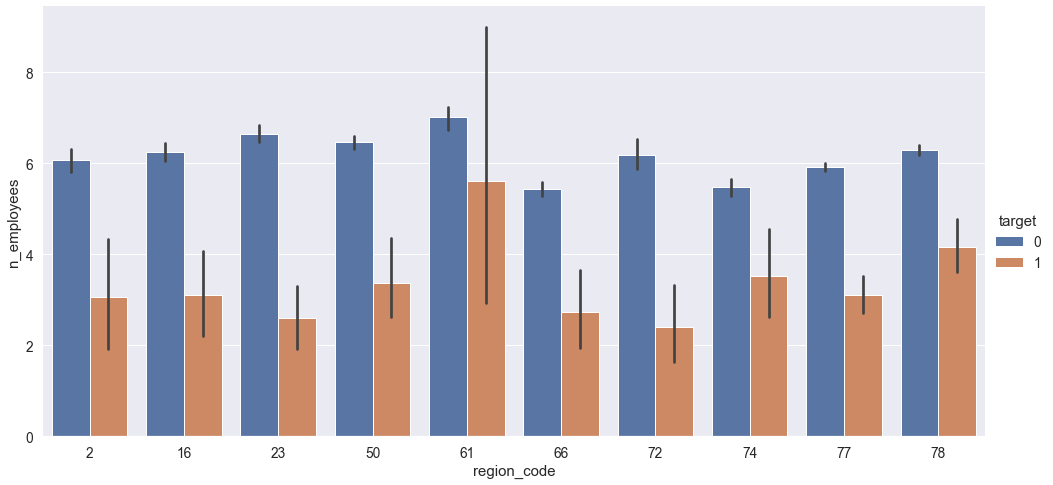

In [424]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values)], 
    x="region_code", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2,
)

- хвост 10 по численности

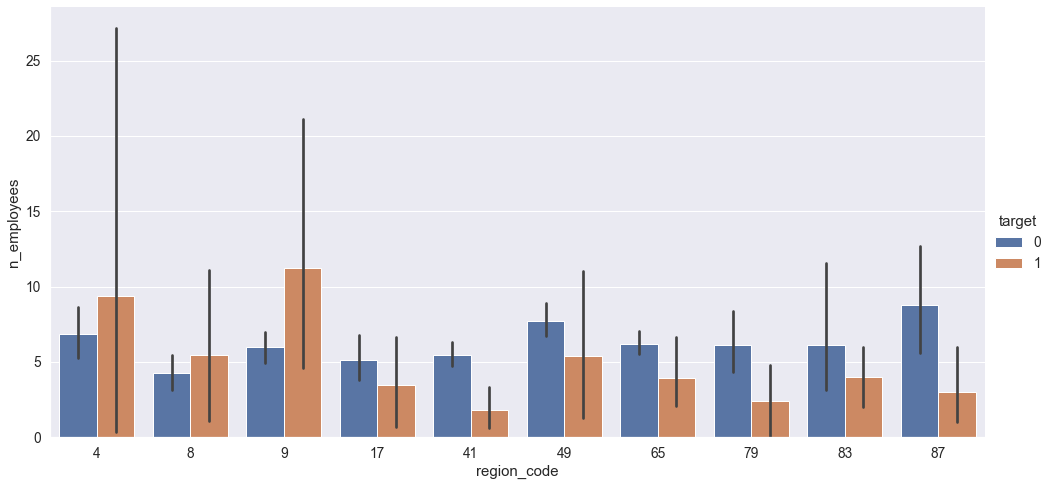

In [425]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.tail(10).values)], 
    x="region_code", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2,
)

- топ 10 по относительной концентрации таргета

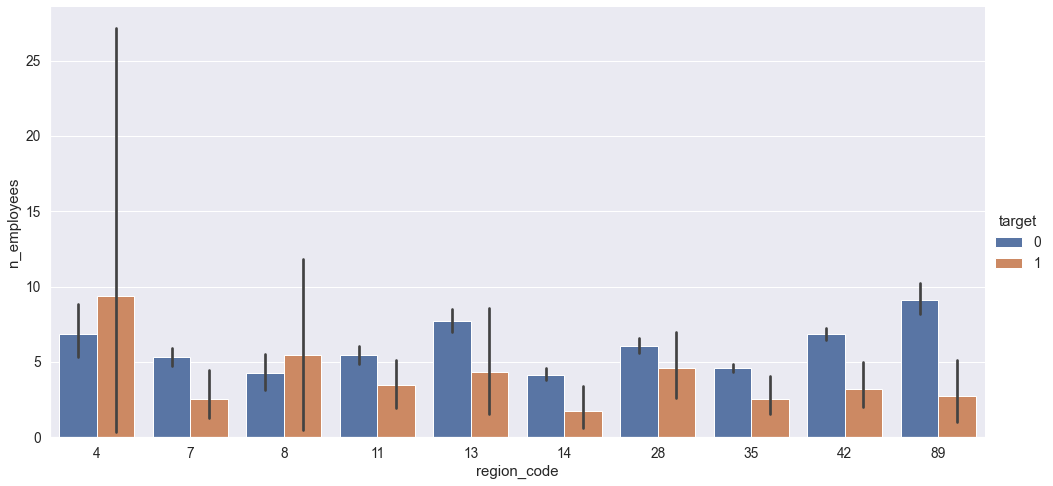

In [426]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(bad_regions)], x="region_code", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2
)

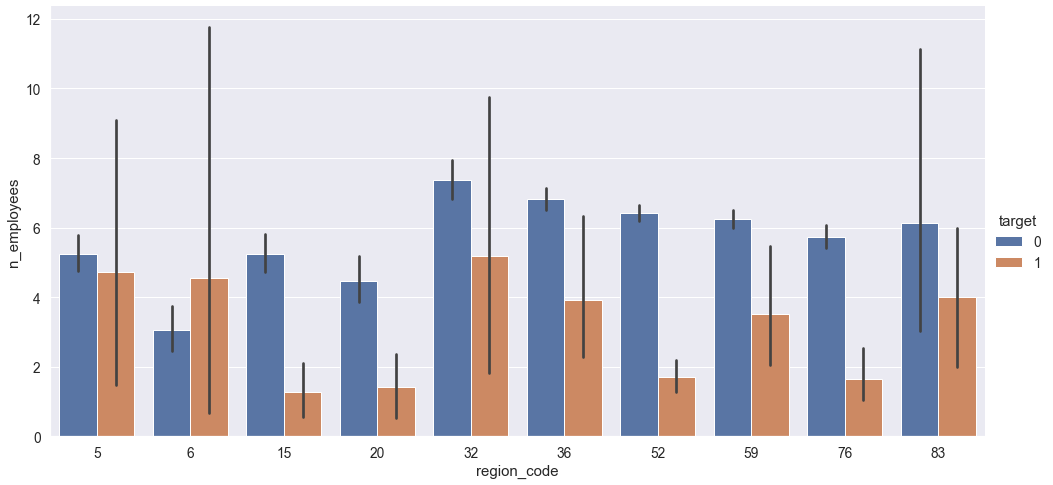

In [427]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(best_regions)], x="region_code", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2
)

- в целом, у таргета немного 1 меньше работников

- сделаю бины по численности и ещё посмотрю
- бины можно использовать как категорию и как ранговую шкалу

In [428]:
X_train['n_employees_quant'] = pd.qcut(X_train.n_employees, q=8, duplicates='drop', labels=range(6))

In [429]:
pd.qcut(X_train.n_employees, q=8, duplicates='drop').unique()

[(0.0, 1.0], (2.0, 5.0], (-1.001, 0.0], (11.0, 8617.0], (5.0, 11.0], (1.0, 2.0]]
Categories (6, interval[float64, right]): [(-1.001, 0.0] < (0.0, 1.0] < (1.0, 2.0] < (2.0, 5.0] < (5.0, 11.0] < (11.0, 8617.0]]

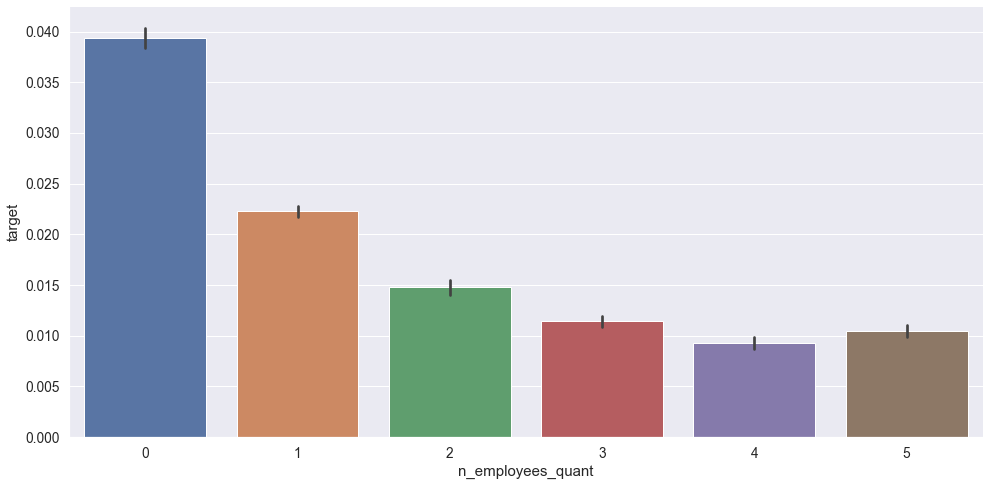

In [430]:
sns.catplot(
    data=X_train, 
    x="n_employees_quant", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- организации с -1 работником - это плохо
- есть вероятность, что -1 работник (т.е. None) - это те, которые своевременно не подали данные о численности...
- 1 работник - плоховато, 2 чуть лучше
- начиная с 3 - неплохо

### ещё немного графиков

In [2]:
with open('parsed_data/X_train_all_feats_0.pickle', 'rb') as f:
    X_train = pickle.load(f)

- authorizedCapital - здесь нет единой закономерности
- можно посмотреть средний authorizedCapital по регионам

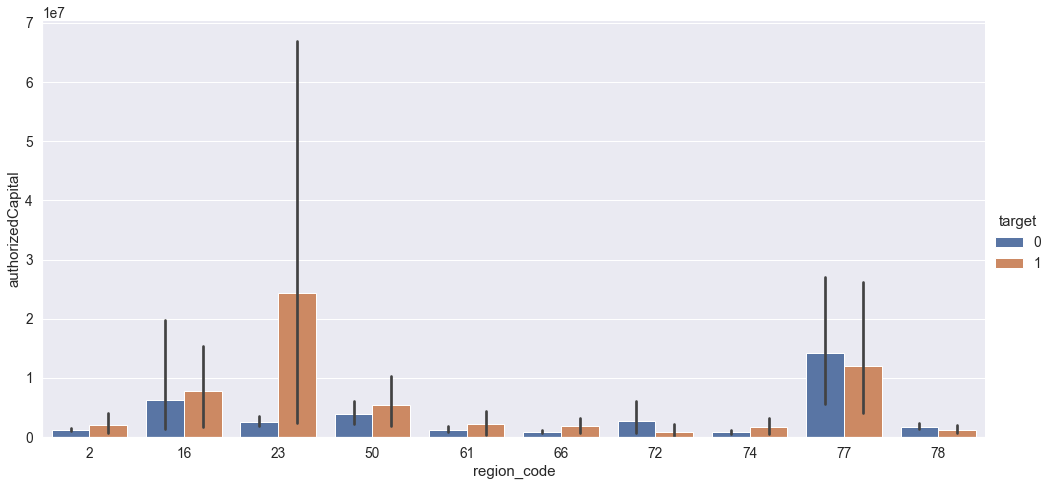

In [290]:
sns.catplot(
    data=tmp_df, x="region_code", y="authorizedCapital", hue='target',
    kind="bar", height=7, aspect=2,
)

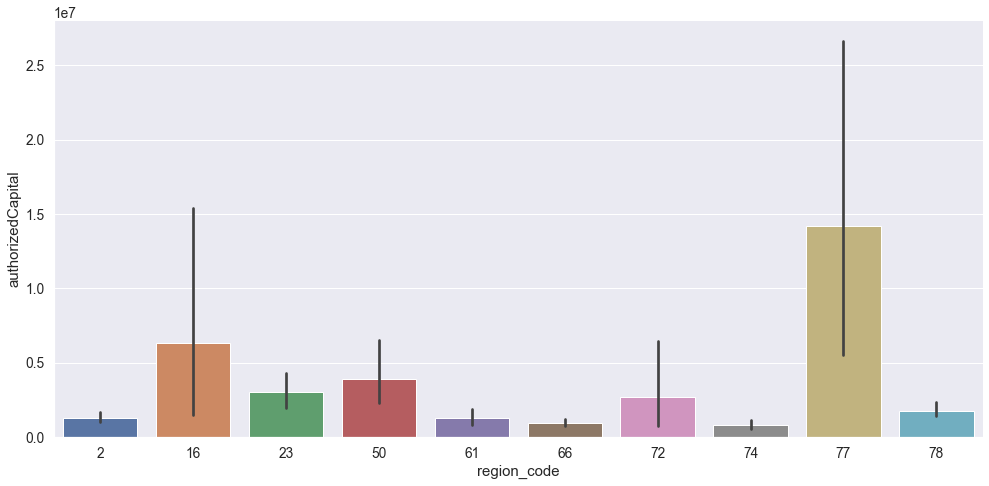

In [291]:
sns.catplot(
    data=tmp_df, x="region_code", y="authorizedCapital",
    kind="bar", height=7, aspect=2,
)

- всё то же самое относительно кодов оквед

- топ-5 оквэд кодов

In [320]:
okveds = X_train.okved2_1.value_counts().head(5).index
okveds

Int64Index([46, 68, 47, 41, 43], dtype='int64')

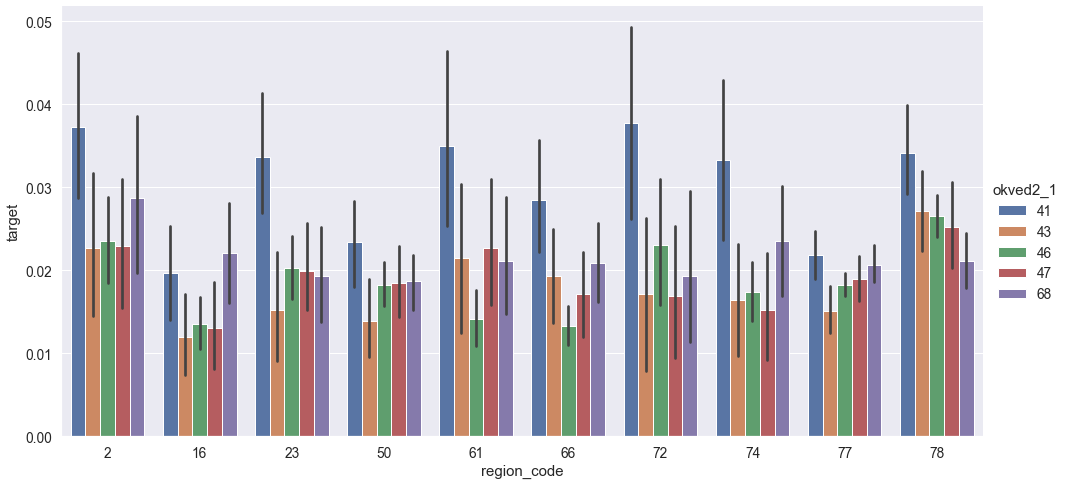

In [321]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values) & X_train.okved2_1.isin(okveds)], 
    x="region_code", y="target", hue='okved2_1',
    kind="bar", height=7, aspect=2
)

41 - строительство жилья, административных зданий, складов и прочих общественных и обслуживающих зданий, фермерских помещений и т. д. - наибольший фактор риска
- но, вероятность ошибки
- по остальным для регионов - своя специфика

- просто по топ-5 okved

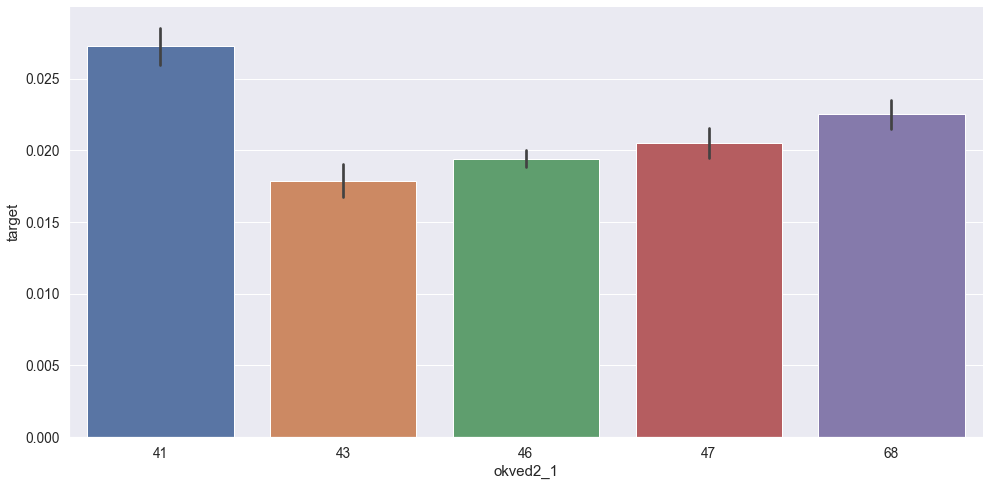

In [322]:
sns.catplot(
    data=X_train.loc[X_train.okved2_1.isin(okveds)], 
    x='okved2_1', y="target",
    kind="bar", height=7, aspect=2
)

43 - монтажные работы, которые обеспечивают функционирование зданий и сооружений гражданского строительства, включая монтаж электрических систем, водопроводно-канализационной сети, сети газоснабжения, системы отопления и кондиционирования, лифтов и т.д

46 - Торговля оптовая, кроме оптовой торговли автотранспортными средствами и мотоциклами

47 - Торговля розничная, кроме торговли автотранспортными средствами и мотоциклами

68 - операции с недвижимым имуществом (здесь имело бы смысл пойти вглубь категории)

- для оквед = строительство жилья: смена категории, среднее по таргету

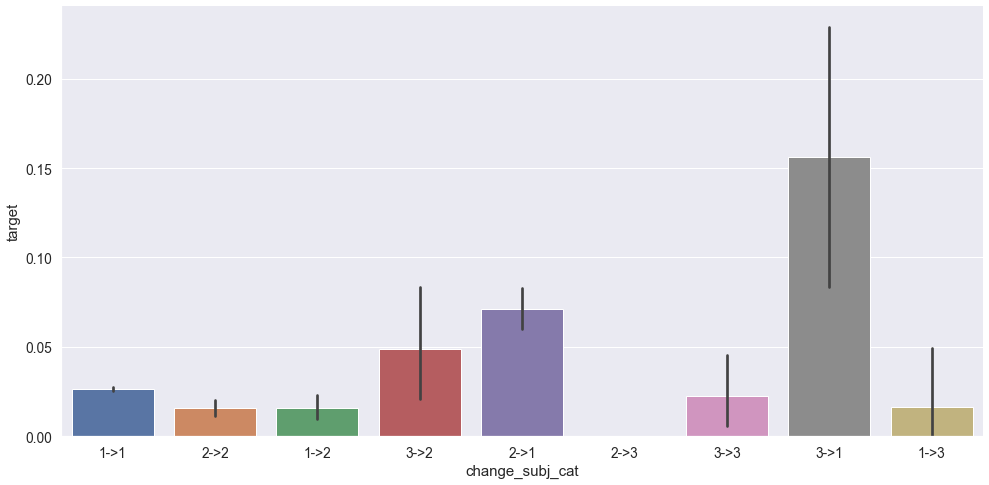

In [323]:
sns.catplot(
    data=X_train.loc[X_train.okved2_1 == 41], x="change_subj_cat", y="target",
    kind="bar", height=7, aspect=2,
)

- интересно, что в сфере строительства микропредприятия как раз относительно неплохо себя чувствуют

- всё то, что делалось с регионами - можно сделать выборки по конкретным городам

- top-10 городов

In [3]:
top10_cities = X_train.groupby('city')['populations'].first().sort_values(ascending=False).index[:10]
tail10_cities = X_train.groupby('city')['populations'].first().sort_values().index[:10]

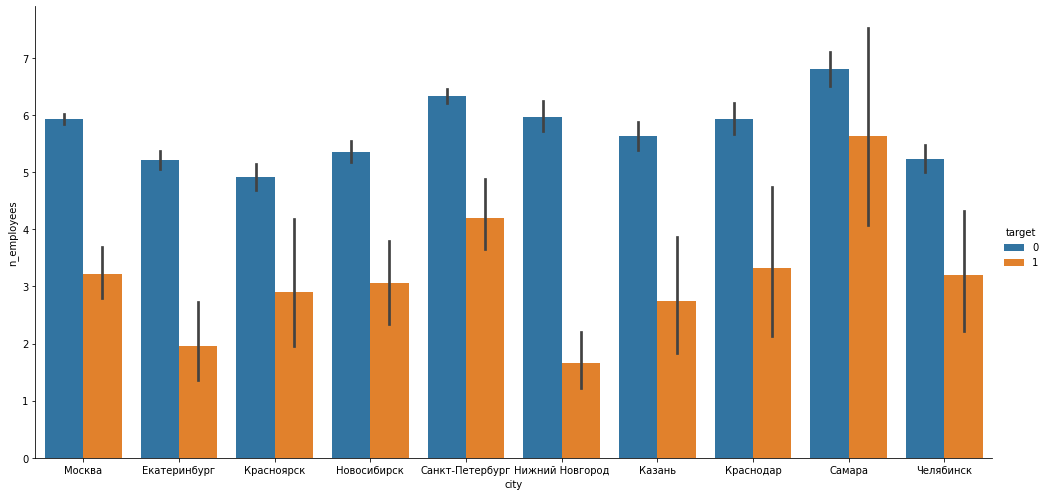

In [4]:
sns.catplot(
    data=X_train.loc[X_train.city.isin(top10_cities)], 
    x="city", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2,
)

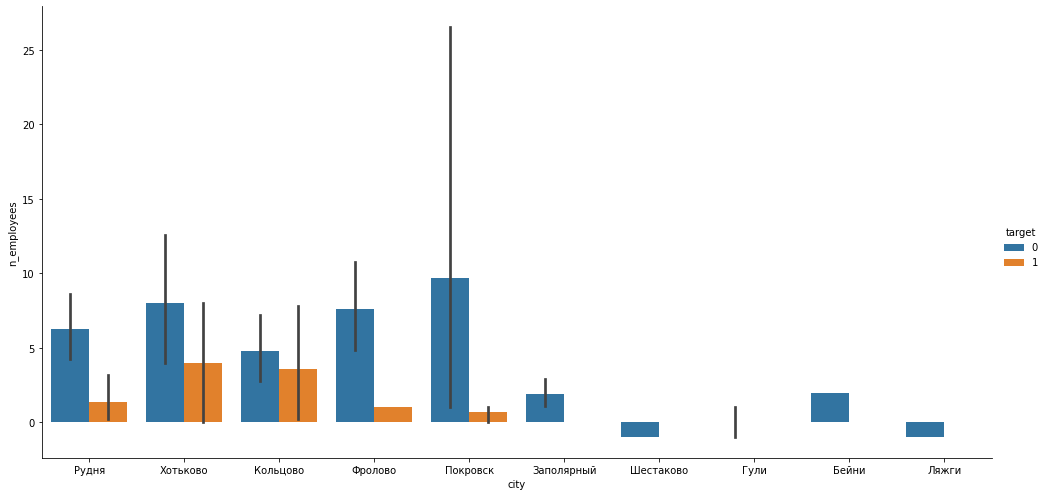

In [5]:
sns.catplot(
    data=X_train.loc[X_train.city.isin(tail10_cities)], 
    x="city", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2,
)

- те это достаточно универсальная закономерность - начиная где-то с 4, а лучше - с 5 работников (в 2021 г) - более стабильные предприятия (на 22-23 гг.)

In [6]:
region_popul = X_train.groupby('region_code', as_index=False)['region_population'].first().sort_values('region_population', ascending=False)
# регионы по численности населения
top10_popul = region_popul.region_code.head(10).values
tail10_popul = region_popul.region_code.tail(10).values

In [7]:
tmp_target_prop = X_train.groupby('region_code').agg(count_target=('target', 'count'), sum_target=('target', 'sum'))
tmp_target_prop['target_perc'] = tmp_target_prop.sum_target / tmp_target_prop.count_target
tmp_target_prop.sort_values('target_perc', ascending=False, inplace=True)

# регионы по относительной концентрации таргета
bad_regions = tmp_target_prop.head(10).index
best_regions = tmp_target_prop.tail(10).index
best_regions

Int64Index([36, 59, 20, 32, 52, 76, 5, 15, 6, 83], dtype='int64', name='region_code')

In [8]:
# города по относительной концентрации таргета - плохо, так себе города, мб брать относительную, но не менее какой-то суммы таргета?
tmp_city_prop = X_train.groupby('city').agg(count_target=('target', 'count'), sum_target=('target', 'sum'))
tmp_city_prop['target_perc'] = tmp_city_prop.sum_target / tmp_city_prop.count_target
# м б брать относительную, нконцентрацию, но не менее какой-то суммы организаций
tmp_city_prop = tmp_city_prop.loc[tmp_city_prop.count_target >= 100]
tmp_city_prop.sort_values('target_perc', ascending=False, inplace=True)

bad_cities = tmp_city_prop.head(10).index
best_cities = tmp_city_prop.tail(10).index
best_cities, bad_cities

(Index(['Арамиль', 'Березники', 'Сухой Лог', 'Кохма', 'Шарыпово', 'Урай',
        'Мончегорск', 'Приозерск', 'Балтийск', 'Клин'],
       dtype='object', name='city'),
 Index(['Инта', 'Прохладный', 'Михайловка', 'Воркута', 'Горячий Ключ',
        'Анжеро-Судженск', 'Кропоткин', 'Прокопьевск', 'Ржев', 'Ноябрьск'],
       dtype='object', name='city'))

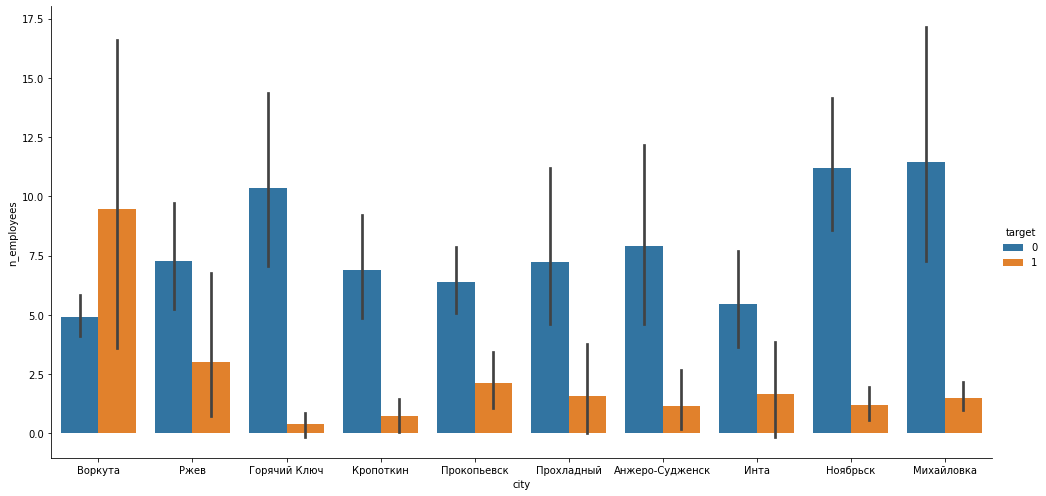

In [9]:
sns.catplot(
    data=X_train.loc[X_train.city.isin(bad_cities)], 
    x="city", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2,
)

- здесь интересные города - не меньше 100 организаций и очень немного неактивных

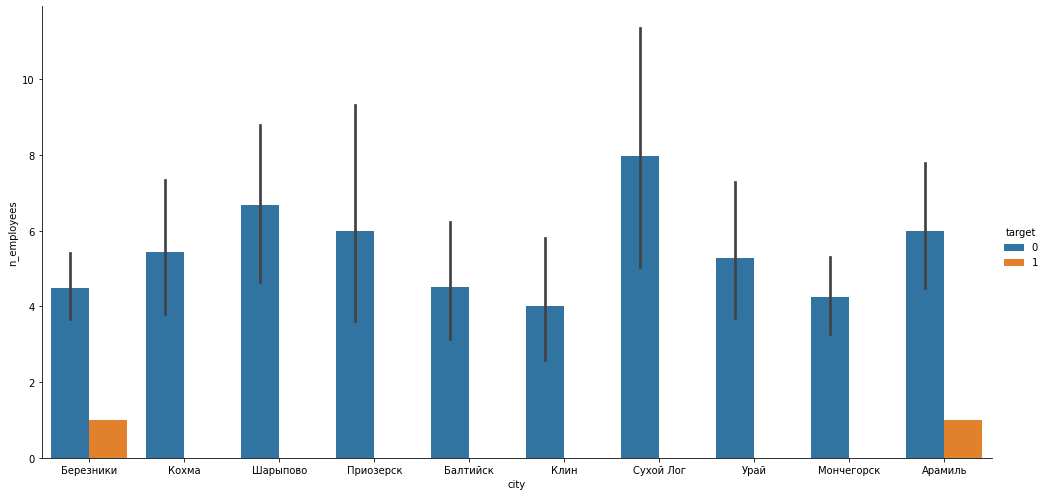

In [10]:
sns.catplot(
    data=X_train.loc[X_train.city.isin(best_cities)], 
    x="city", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2,
)

- число контрактов и договоров по регионам

        'n_contracts', наличие в предшествующем календарном году контрактов, заключенных для обеспечения государственных и муниципальных нужд (№44-ФЗ)
         'n_agreements', - число договоров, закл в соотв с ФЗ №223-ФЗ О закупках товаров, работ, услуг

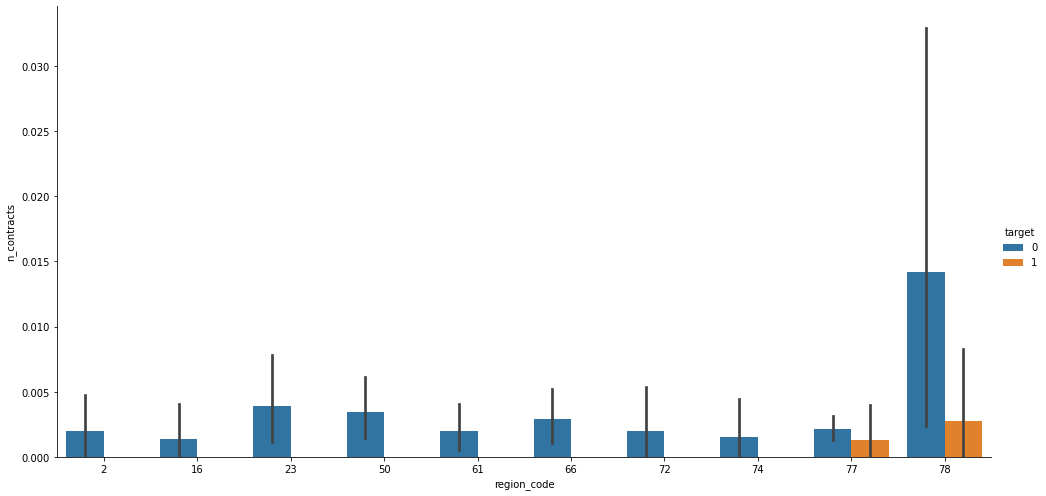

In [12]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_popul)], 
    x="region_code", y="n_contracts", hue='target',
    kind="bar", height=7, aspect=2
)

- так и есть, 78 - СПб, 77 - Москва
- можно просто посмотреть, где оседают контракты

In [13]:
n_contracts = X_train.groupby('region_code')['n_contracts'].sum().sort_values(ascending=False)
n_contracts.head(10)

region_code
47    1235
78    1049
77     336
50     178
52     175
63     146
23     116
66     109
21      68
40      67
Name: n_contracts, dtype: int16

In [16]:
n_agreements = X_train.groupby('region_code')['n_agreements'].sum().sort_values(ascending=False)
n_agreements.head(10)

region_code
77    280.0
66    139.0
50    130.0
63    114.0
52     81.0
78     76.0
74     63.0
53     60.0
16     50.0
72     40.0
Name: n_agreements, dtype: float64

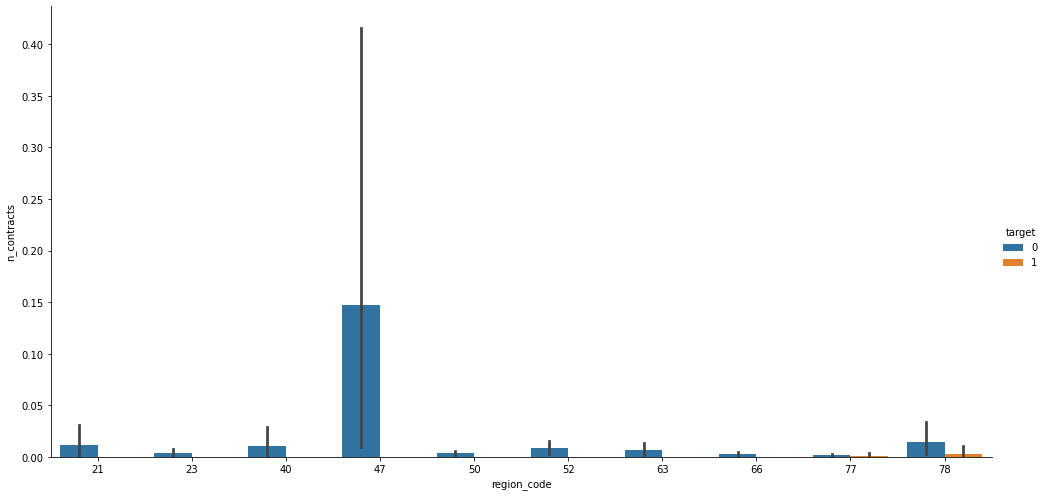

In [14]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(n_contracts.index[:10])], 
    x="region_code", y="n_contracts", hue='target',
    kind="bar", height=7, aspect=2
)

- слишком мало наблюдений, но те, у кого есть договора и контракты - скорее стабильны

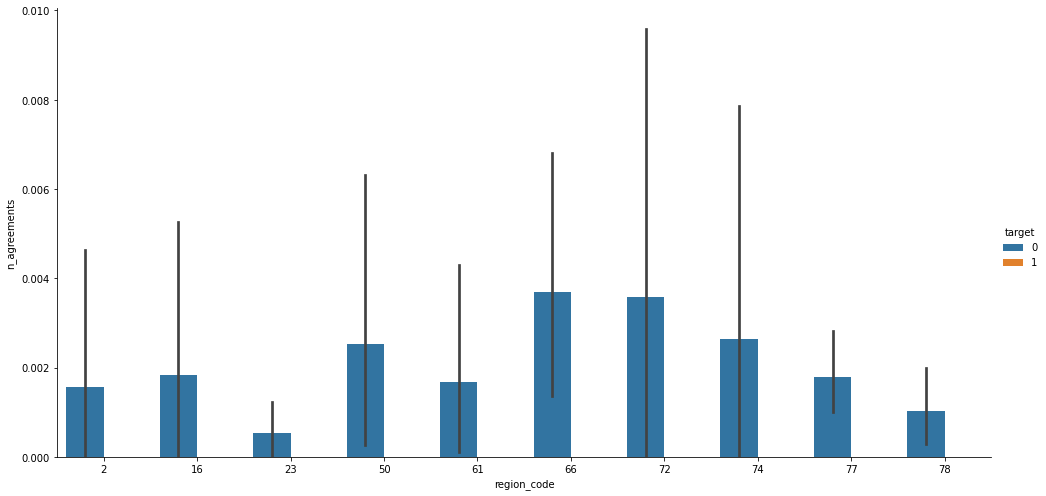

In [15]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_popul)], 
    x="region_code", y="n_agreements", hue='target',
    kind="bar", height=7, aspect=2
)

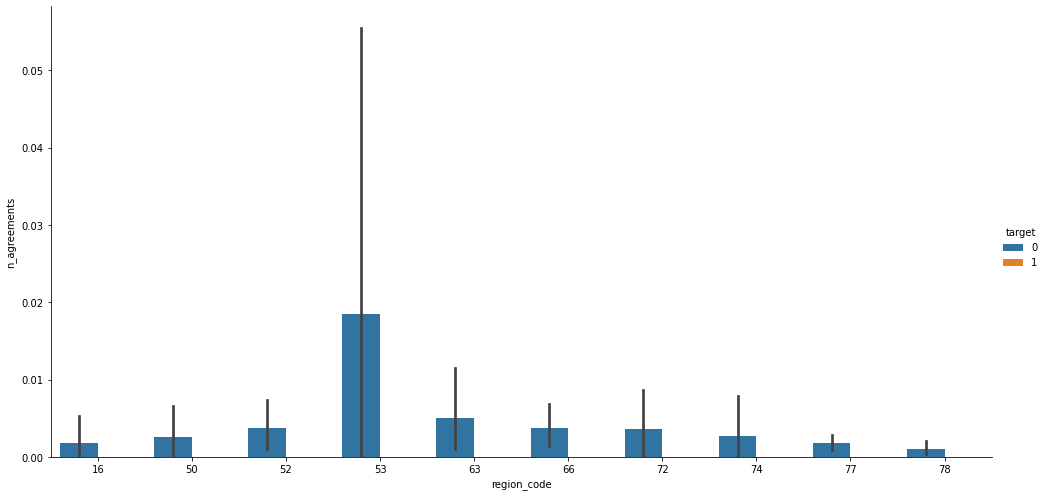

In [17]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(n_agreements.index[:10])], 
    x="region_code", y="n_agreements", hue='target',
    kind="bar", height=7, aspect=2
)

- посмотрим на оквед по форме организации (микро, малая, средняя)

топ-10 оквед-кодов

In [18]:
okveds = X_train.okved2_1.value_counts().head(10).index
okveds

Int64Index([46, 68, 47, 41, 43, 49, 52, 45, 71, 69], dtype='int64')

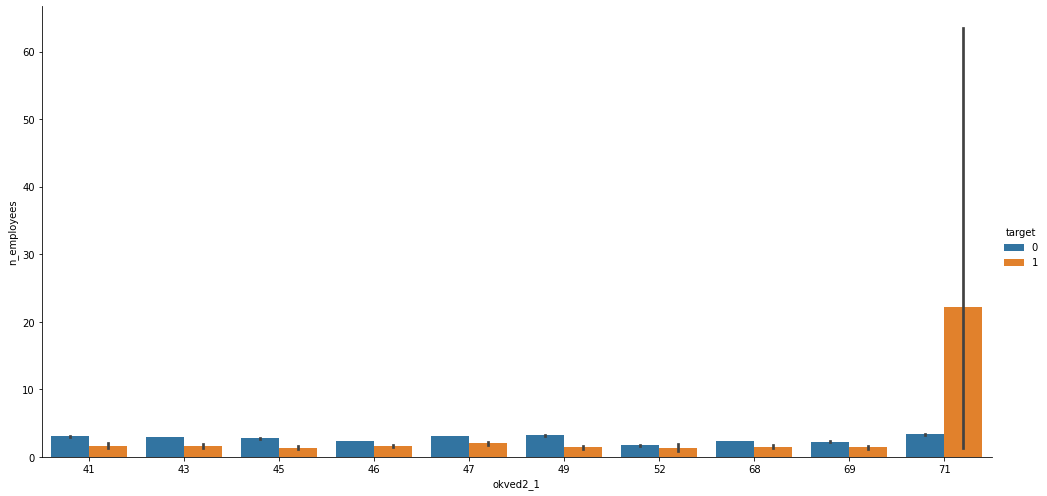

In [19]:
# микроорганизации - таргет от okved
sns.catplot(
    data=X_train.loc[(X_train.subj_cat == 1) & X_train.okved2_1.isin(okveds)], 
    x="okved2_1", y="n_employees", hue='target',
    kind="bar", height=7, aspect=2
)

как интересно - код 71 - Деятельность в области архитектуры и инженерно-технического проектирования; технических испытаний, исследований и анализа, больше 5 работников - это плохо

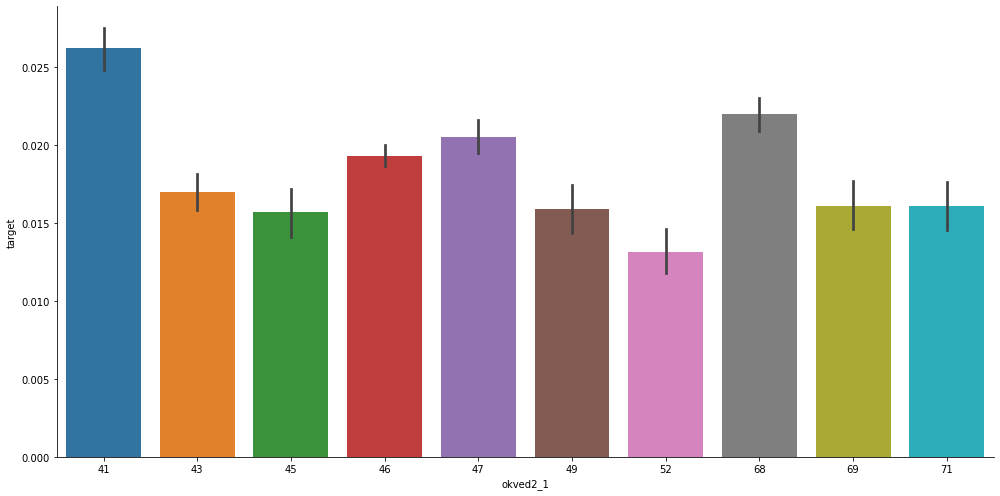

In [20]:
sns.catplot(
    data=X_train.loc[(X_train.subj_cat == 1) & X_train.okved2_1.isin(okveds)], 
    x="okved2_1", y="target",
    kind="bar", height=7, aspect=2
)

- посмотрим подробно влияние размера организации на код 41
    - форма организации по свежей численности работников

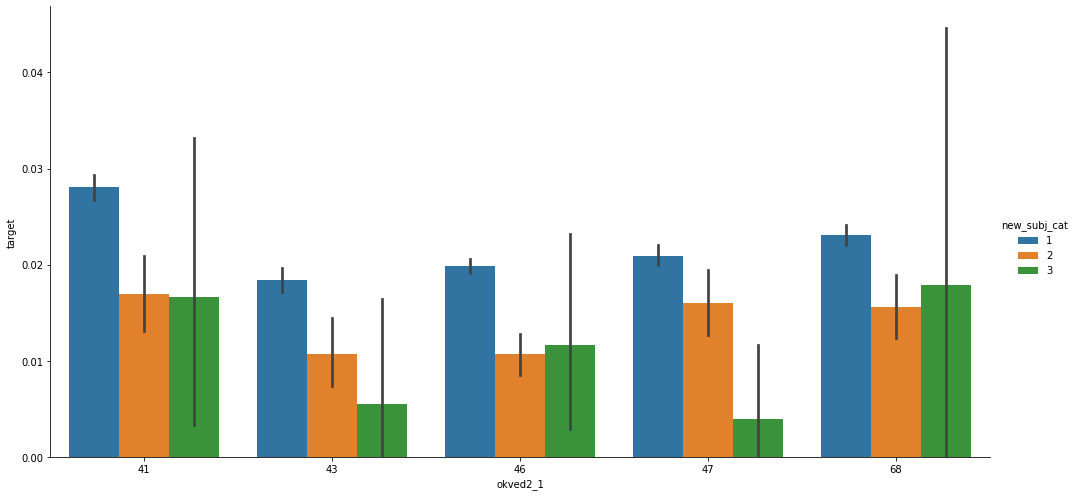

In [21]:
sns.catplot(
    data=X_train.loc[X_train.okved2_1.isin(okveds[:5])], 
    x="okved2_1", y="target", hue='new_subj_cat',
    kind="bar", height=7, aspect=2
)

- чем больше предприятие, тем стабильнее
- те чем больше работников, за искл 68 - но там большая ошибка

- а вот по более старой зависимости - по действительной форме организации (которая сменится, через 3 года, если предприятие не соответствует критерием) - очень даже наоборот

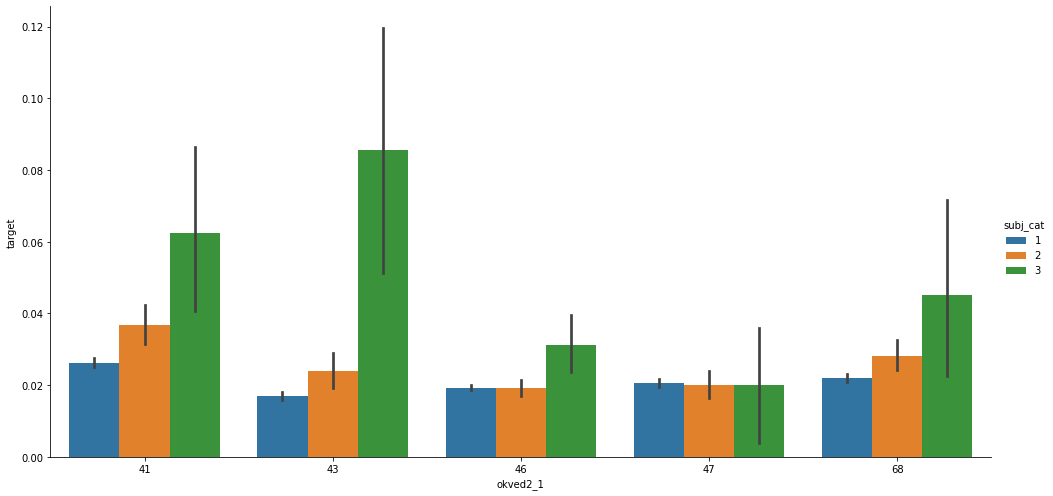

In [22]:
sns.catplot(
    data=X_train.loc[X_train.okved2_1.isin(okveds[:5])], 
    x="okved2_1", y="target", hue='subj_cat',
    kind="bar", height=7, aspect=2
)

- вывод: надо смотреть на актуальные показатели, а не формальный статус
- численность работников - достаточно динамичный показатель для мсп

- дальше посмотрим на топливо ai92

- топ10 регионов по объёмам продажи ai92

In [23]:
top10_vol = X_train.groupby('region_code')['AI92_volume_2021'].first().sort_values(ascending=False).index[:10].values
top10_vol

array([50, 77, 23, 16,  2, 78, 66, 61, 63, 74], dtype=int64)

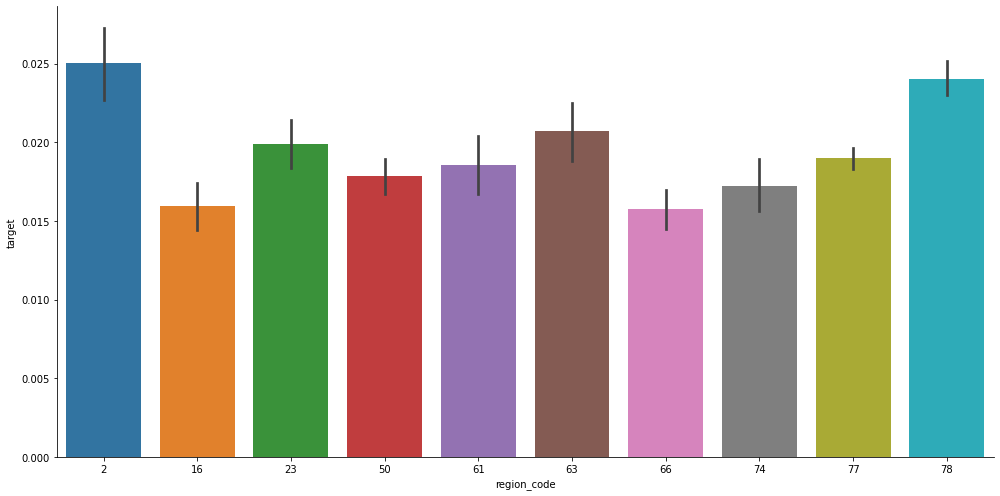

In [24]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_vol)], 
    x="region_code", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

In [25]:
tail_10_vol = X_train.groupby('region_code')['AI92_volume_2021'].first().sort_values().index[:10].values

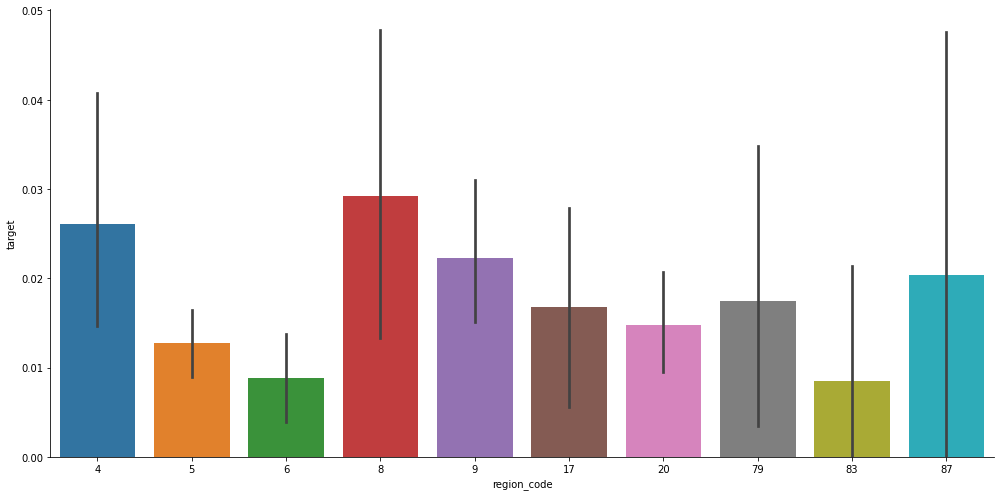

In [26]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(tail_10_vol)], 
    x="region_code", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- квантили для ai

In [27]:
# здесь квантили на нормированном объёме,иначе один столбец и всё
X_train['ai92_vol_quant'] = pd.qcut(X_train.diesel_volume_2021, q=4)
X_train['ai92_cost_quant'] = pd.qcut(X_train.diesel_cost_2021, q=5)

- график по нормированному объёму - для топ-10 регионов (по абс продаже)

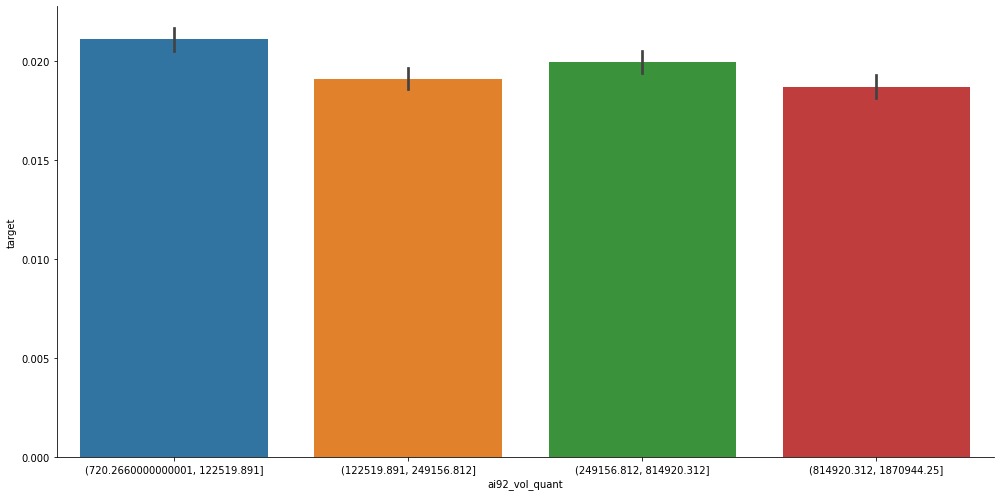

In [28]:
sns.catplot(
    data=X_train,#.loc[X_train.region_code.isin(top10_vol)], 
    x="ai92_vol_quant", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- то же самое, но для топ-10 регионов по численности
- та же самая тенденция, но более выраженная: наибольшая вероятность для минимального объёма на душу населения... а дальше - такая лесенка

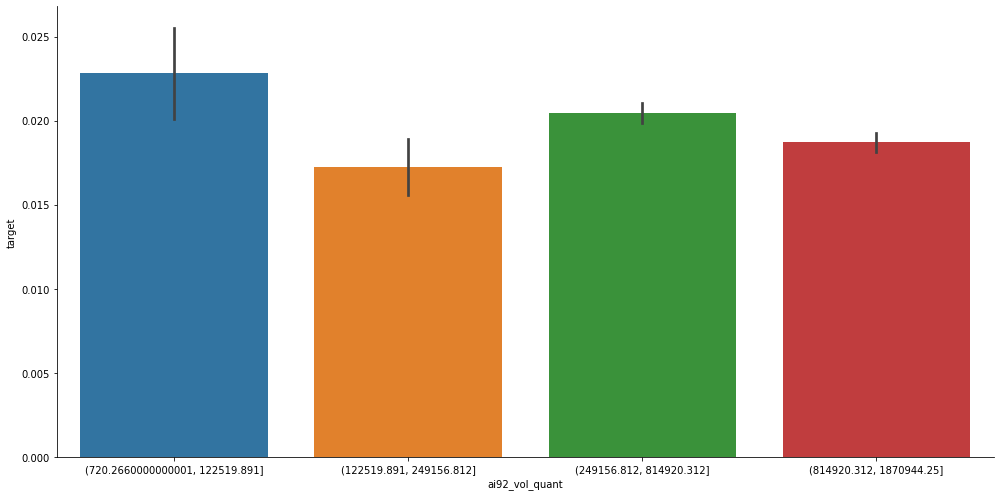

In [29]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(top10_popul)], 
    x="ai92_vol_quant", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- квантили по стоимости
- слабая, но есть тенденция - чем выше стоимость, тем больше вероятность таргета

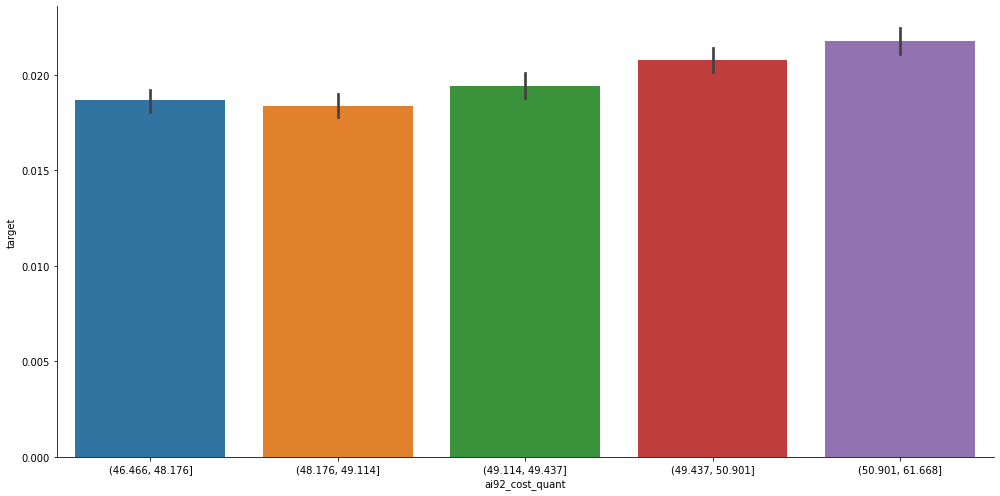

In [30]:
sns.catplot(
    data=X_train,#.loc[X_train.region_code.isin(top10_vol)], 
    x="ai92_cost_quant", y="target",# hue='target',
    kind="bar", height=7, aspect=2,
)

- сильно совпадает с регионами с продажей дизеля

- связь дизеля и стоимости потребительской корзины

In [31]:
cons_basket = ['cons_basket_child_2020',
               'cons_basket_child_2021',
               'cons_basket_pens_2020',
               'cons_basket_pens_2021',
               'cons_basket_working_age_2020',
               'cons_basket_working_age_2021',]
diesel = ['diesel_cost_2020',
          'diesel_cost_2021',
          'diesel_volume_2020',
          'diesel_volume_2021']
ai_98 = ['AI98_cost_2020',
         'AI98_cost_2021', 
         'AI98_volume_2020',
         'AI98_volume_2021',]

- на примере дизеля - аналогичная ситуация с другими видами топлива, кроме ai98 - стоимость потребительской корзины положительно связана со стоимостью и объемами продажи топлива

In [32]:
costs_corr = X_train[cons_basket + diesel].corr()

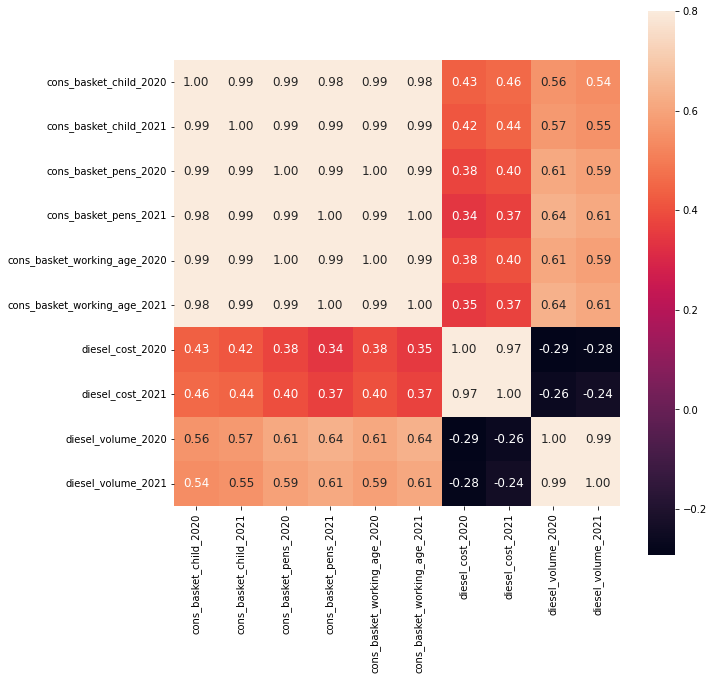

In [33]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(costs_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.2f', 
            annot_kws={'size': 12});

ai_98 - слабая отрицательная связь со стоимостью - и наиболее сильная положительная с объёмом (что интересно:)
- чем больше населения или расстояния - больше тратится топливо - больше стоимость продуктовой корзины
- но отрицательная связь - при более дешёвом топливе - более дорогая потребительская корзина?

In [34]:
costs_corr = X_train[cons_basket + ai_98].corr()

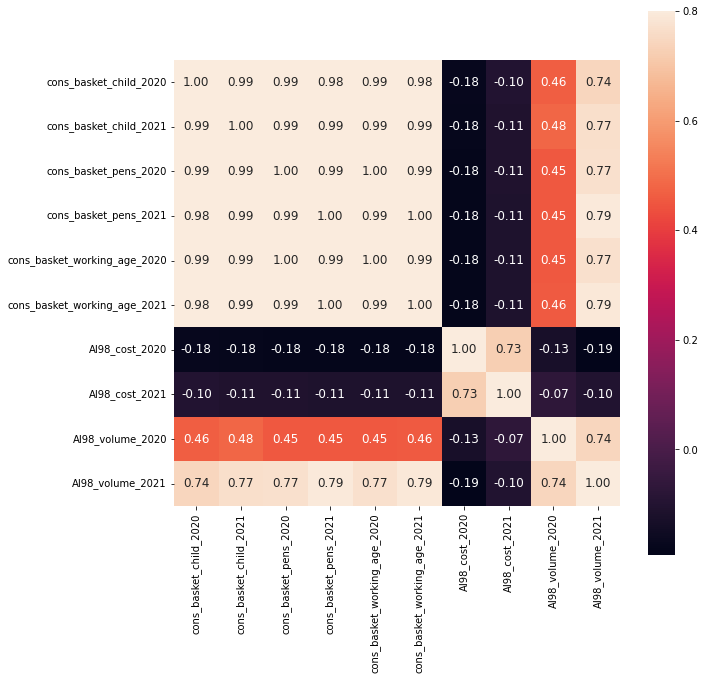

In [35]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(costs_corr, 
            vmax=.8, 
            square=True, 
            cbar=True, 
            annot=True,
            fmt='.2f', 
            annot_kws={'size': 12});

- распределение таргет, регион, оквед и штрафы - по каким оквед в основном штрафуют? число штрафов и их размер

In [36]:
okveds5 = X_train.okved2_1.value_counts().head(5).index
okveds5

Int64Index([46, 68, 47, 41, 43], dtype='int64')

- штрафы по налоговым нарушениям

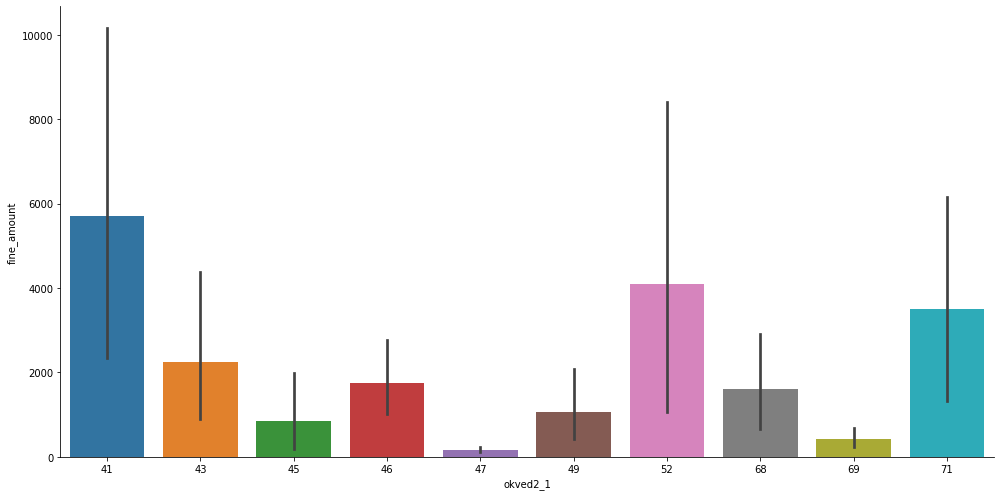

In [37]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values) & X_train.okved2_1.isin(okveds)], 
    x="okved2_1", y="fine_amount",# hue='target',
    kind="bar", height=7, aspect=2
)

- налоговые задолженности

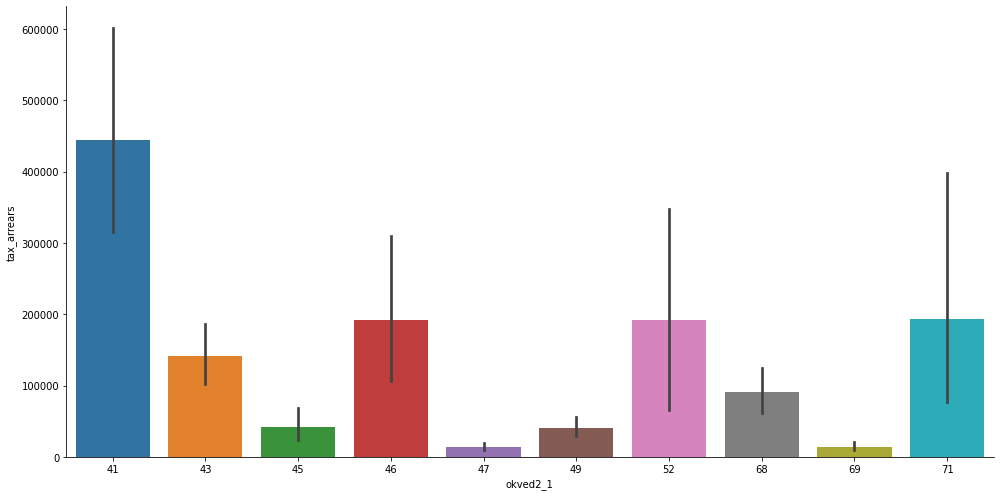

In [38]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values) & X_train.okved2_1.isin(okveds)], 
    x="okved2_1", y="tax_arrears", #hue='target',
    kind="bar", height=7, aspect=2
)

то же самое, но сразделением для таргета

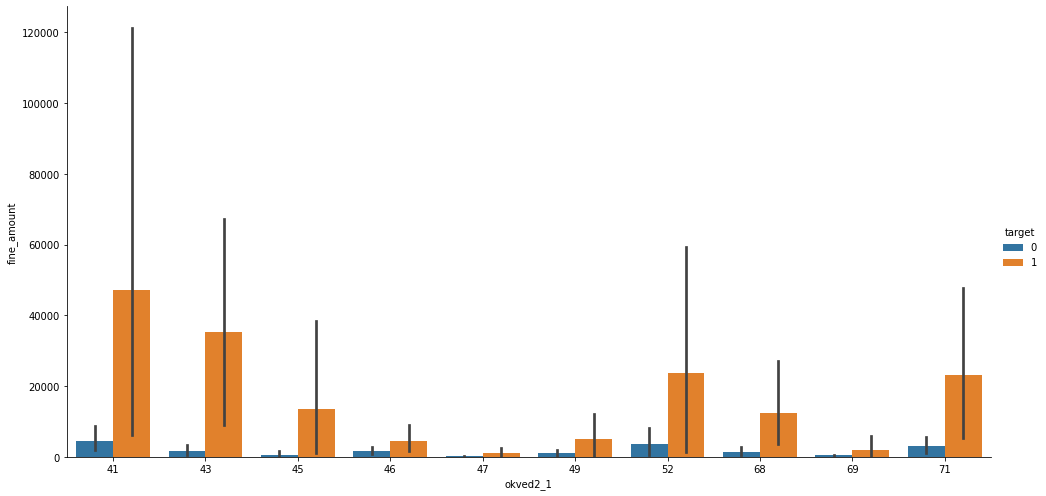

In [40]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values) & X_train.okved2_1.isin(okveds)], 
    x="okved2_1", y="fine_amount", hue='target',
    kind="bar", height=7, aspect=2
)

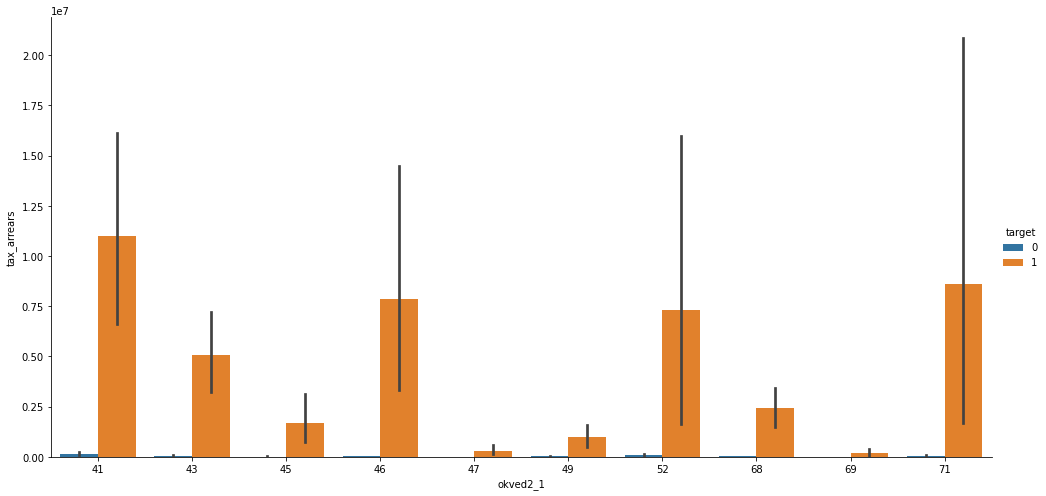

In [41]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(10).values) & X_train.okved2_1.isin(okveds)], 
    x="okved2_1", y="tax_arrears", hue='target',
    kind="bar", height=7, aspect=2
)

- топ10 регионов, топ5 okveds - налоговые нарушения

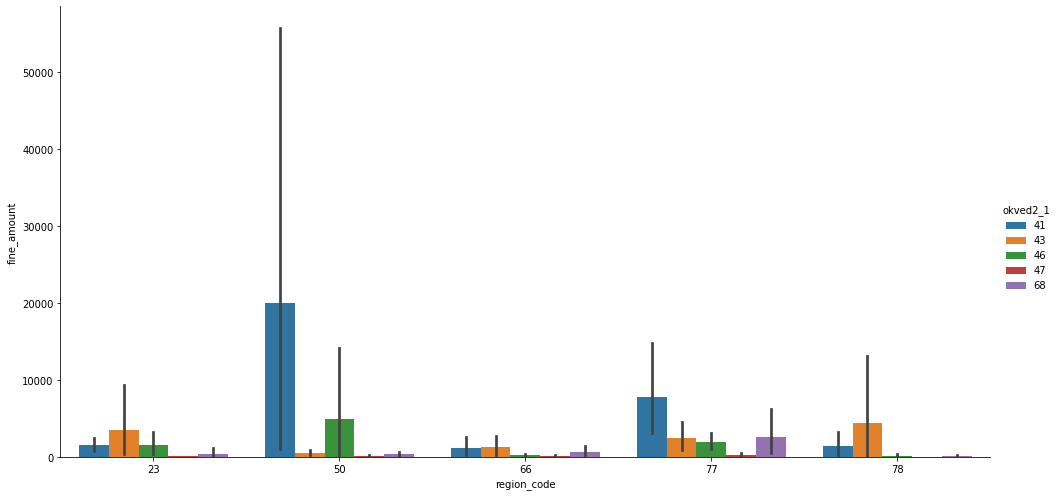

In [42]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(5).values) & X_train.okved2_1.isin(okveds5)], 
    x="region_code", y="fine_amount", hue='okved2_1',
    kind="bar", height=7, aspect=2
)

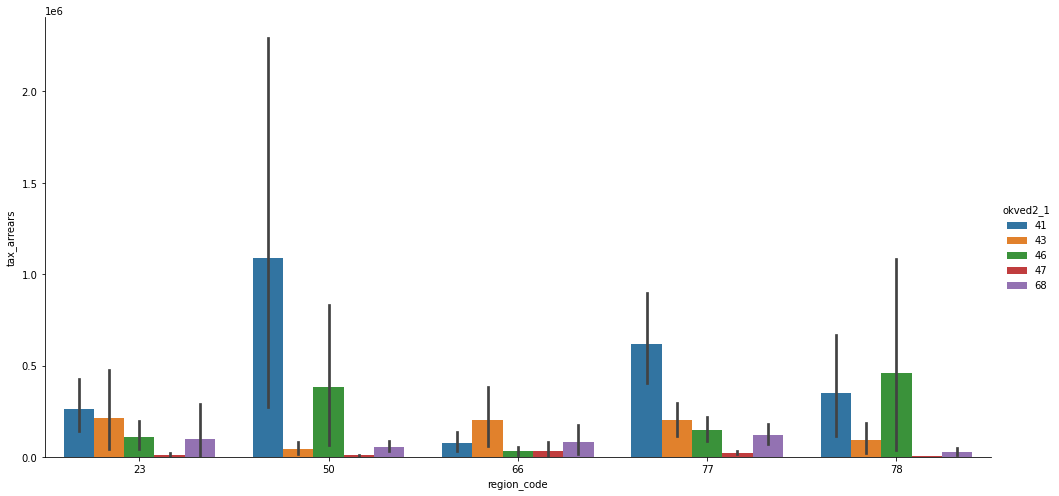

In [43]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(5).values) & X_train.okved2_1.isin(okveds5)], 
    x="region_code", y="tax_arrears", hue='okved2_1',
    kind="bar", height=7, aspect=2
)

41 - строительство
43 - работы строительные
46 - торговля оптовая
47 - розничная
68 - операции с недвижимым имуществом

- но это была средняя сумма штрафа
- посмотрим на число штрафов

In [44]:
X_train['is_fine_amount'] = np.where(X_train.fine_amount > 0, 1, 0)

In [45]:
sum(X_train.is_fine_amount)

26875

- это средняя доля штрафов на число компаний
- те в строительной сфере - больше всего штрафов и они, кажется, наиболее высокие?

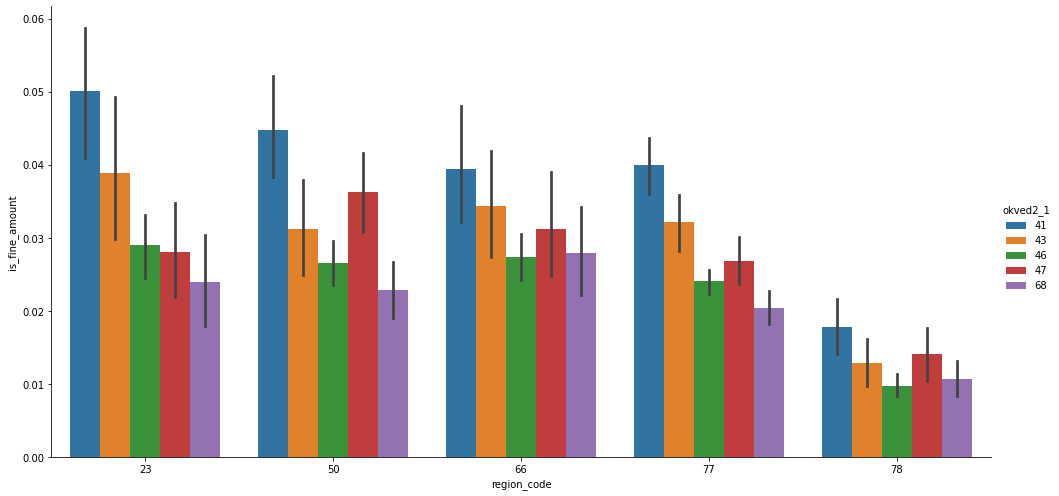

In [46]:
sns.catplot(
    data=X_train.loc[X_train.region_code.isin(region_popul.region_code.head(5).values) & X_train.okved2_1.isin(okveds5)], 
    x="region_code", y="is_fine_amount", hue='okved2_1',
    kind="bar", height=7, aspect=2
)

- да, они самые высокие

In [47]:
X_train.loc[X_train.okved2_1.isin(okveds5)].groupby('okved2_1')['fine_amount'].mean()

okved2_1
41    5646.174805
43    2506.506836
46    1686.017700
47     285.309448
68    3200.125977
Name: fine_amount, dtype: float32

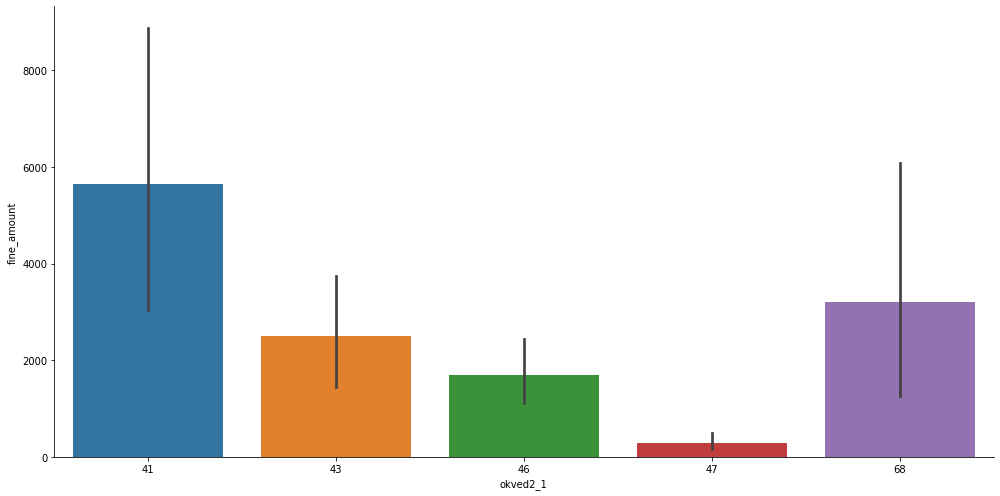

In [48]:
# а здесь что за число?
sns.catplot(
    data=X_train.loc[X_train.okved2_1.isin(okveds5)], 
    x="okved2_1", y="fine_amount",
    kind="bar", height=7, aspect=2
)

- вторые по высоте - операции с недвижимостью, самые мелкие штрафы - розничная торговля и их немного по числу
- хотя здесь - большая ошибка, тк штрафов в общей сумме очень мало!

-  распределение по штрафам и оквед по subj_cat

- среднее число штрафов 

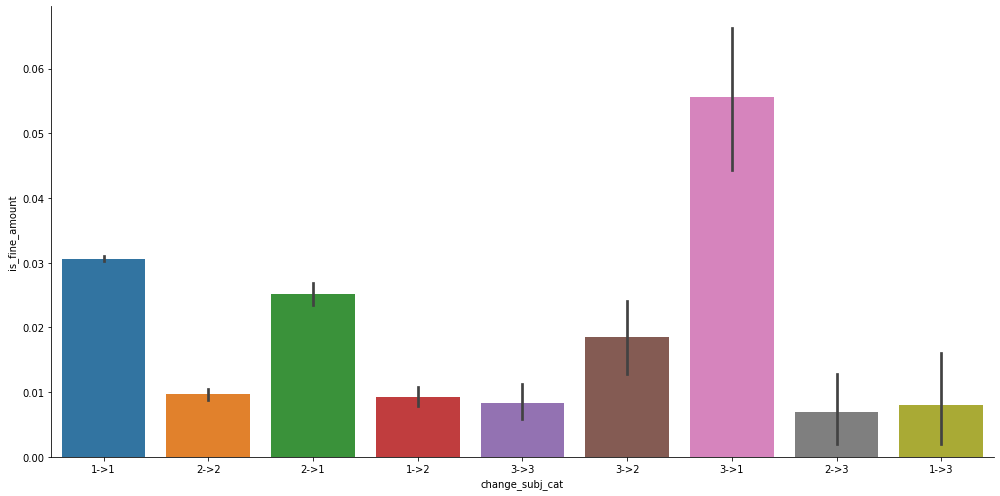

In [49]:
sns.catplot(
    data=X_train,
    x="change_subj_cat", y="is_fine_amount",
    kind="bar", height=7, aspect=2
)

и средняя сумма штрафов

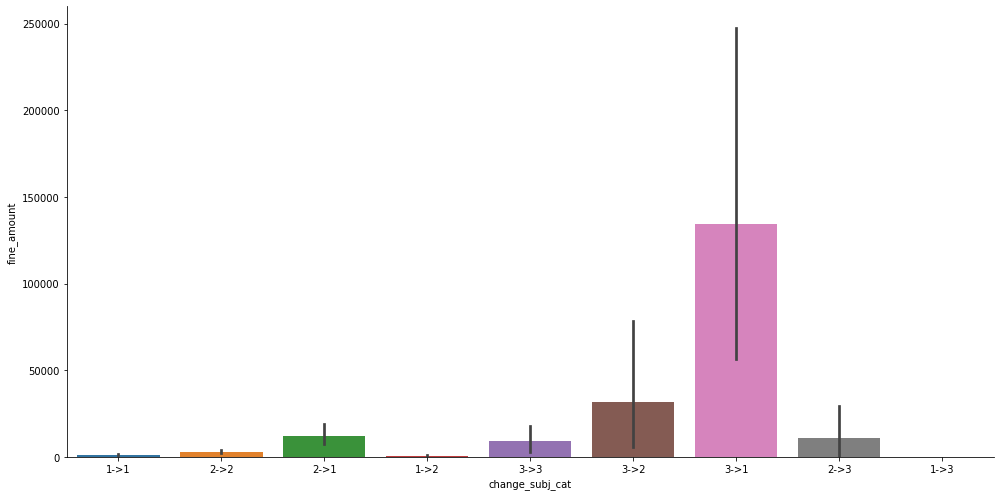

In [50]:
sns.catplot(
    data=X_train,
    x="change_subj_cat", y="fine_amount",
    kind="bar", height=7, aspect=2
)

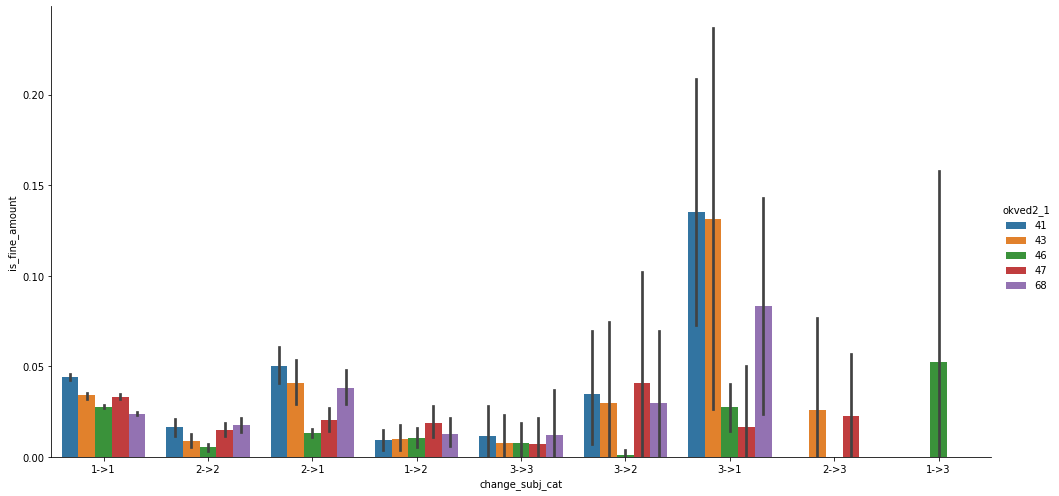

In [52]:
sns.catplot(
    data=X_train.loc[X_train.okved2_1.isin(okveds5)], 
    x="change_subj_cat", y="is_fine_amount", hue='okved2_1',
    kind="bar", height=7, aspect=2
)

- непоказательно из-за масштабов, но всё то же самое

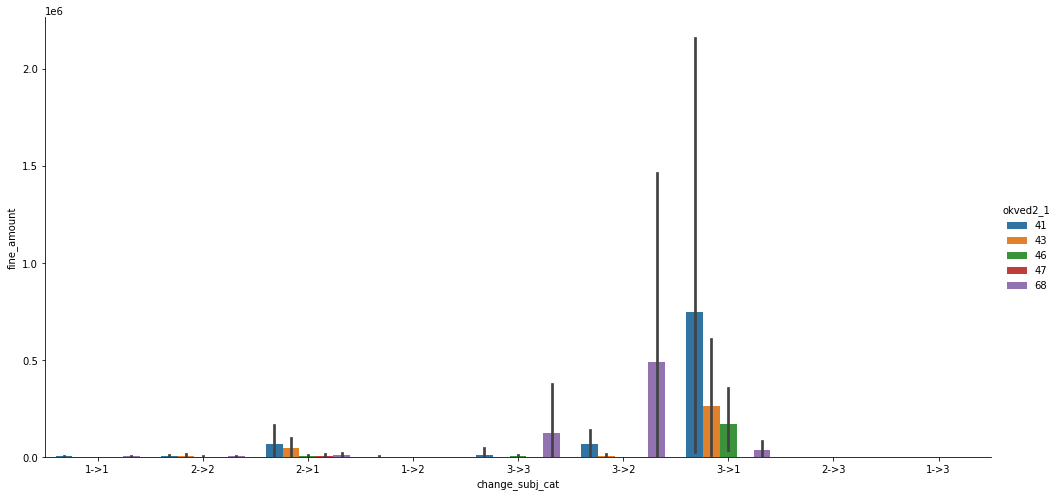

In [51]:
sns.catplot(
    data=X_train.loc[X_train.okved2_1.isin(okveds5)], 
    x="change_subj_cat", y="fine_amount", hue='okved2_1',
    kind="bar", height=7, aspect=2
)

- столбцы для отбора признаков

In [431]:
onehot_col = ['n_org_per_index_quant', 'region_code', 'n_org_per_region_code_quant', 'okved2_1', 'okopf', 'subj_cat',
              'new_subj_cat', 'change_subj_cat'
             ]

bin_col = ['is_soc_enterprise', 'newly_establ', 'is_high_tech', 'disqual_person', 'is_fin_sup'
          ]

num_col = ['n_org_per_index', 'n_org_per_index_q95', 'n_org_per_index_log', 'n_org_per_index_quant',
           
           'n_org_per_region_code', 'n_org_per_region_code_log', 'n_org_per_region_code_med', 'n_org_per_region_code_q95',
           'n_org_per_region_code_quant', 'target_fract_per_region',
           
           'n_org_per_okved2', 'n_org_per_okved2_med', 'n_org_per_okved2_q95', 'n_org_per_okved2_per_region', 
           'n_org_per_okved2_per_region_log', 'n_org_per_okved2_per_region_med', 'n_org_per_okved2_per_region_q95', 
           'n_org_per_okved2_per_locality', 'n_org_per_okved2_per_locality_med', 'n_org_per_okved2_per_locality_q95',
           
           'n_org_per_okopf', 'n_org_per_okopf_region', 'n_org_per_okopf_region_log', 'n_org_per_okopf_region_med', 
           'n_org_per_okopf_region_q95', 'n_org_per_okopf_locality', 'n_org_per_okopf_locality_med', 
           'n_org_per_okopf_locality_q95',
           
           'subj_cat', 'new_subj_cat', 'change_subj_cat_range',
           
           'from_registr_days', 'from_registr_days_log', 'from_registr_days_med', 'from_registr_days_q95', 'from_registr_days_fract',
           'from_registr_days_fract_med', 'from_registr_days_fract_q95',
           
           'from_inclusion_days', 'from_inclusion_days_med', 'from_inclusion_days_q95', 'from_inclusion_days_fract',
           'from_inclusion_days_fract_med', 'from_inclusion_days_fract_q95',
           
           'populations', 'populations_med', 'populations_med_med', 'populations_med_q95', 'populations_region_med',
           'populations_region_med_med', 'populations_region_med_q95',
           
           'region_population',
           
           '2021_1150','2020_1150','2021_1170','2020_1170','2021_1210','2020_1210','2021_1230', '2020_1230', '2021_1250',
           '2020_1250','2021_1600','2020_1600', '2021_1350', '2020_1350', '2021_1360', '2020_1360', '2021_1300', 
           '2020_1300', '2021_1520', '2020_1520', '2021_1700', '2020_1700',
           '2021_1150_med', '2020_1150_med', '2021_1170_med', '2020_1170_med', '2021_1210_med', '2020_1210_med', 
           '2021_1230_med', '2020_1230_med', '2021_1250_med', '2020_1250_med', '2021_1600_med', '2020_1600_med', 
           '2021_1350_med', '2020_1350_med', '2021_1360_med', '2020_1360_med', '2021_1300_med', '2020_1300_med', 
           '2021_1520_med', '2020_1520_med', '2021_1700_med', '2020_1700_med',
           '2021_1150_q95', '2020_1150_q95', '2021_1170_q95', '2020_1170_q95', '2021_1210_q95', '2020_1210_q95', 
           '2021_1230_q95', '2020_1230_q95', '2021_1250_q95', '2020_1250_q95', '2021_1600_q95', '2020_1600_q95', 
           '2021_1350_q95', '2020_1350_q95', '2021_1360_q95', '2020_1360_q95', '2021_1300_q95', '2020_1300_q95', 
           '2021_1520_q95', '2020_1520_q95', '2021_1700_q95', '2020_1700_q95',
           '2020_1150_q95_growth', '2020_1170_growth', '2020_1210_q95_growth', '2020_1230_q95_growth', 
           '2020_1250_q95_growth', '2020_1600_q95_growth', '2020_1350_growth', '2020_1360_growth', '2020_1300_q95_growth', 
           '2020_1520_q95_growth', '2020_1700_q95_growth',
           
           '2021_2110', '2020_2110', '2021_2120', '2020_2120', '2021_2330', '2020_2330', '2021_2340', '2020_2340', 
           '2021_2350', '2020_2350', '2021_2410', '2020_2410', '2021_2400', '2020_2400', 
           '2021_2110_med', '2020_2110_med', '2021_2120_med', '2020_2120_med', '2021_2330_med', '2020_2330_med', 
           '2021_2340_med', '2020_2340_med', '2021_2350_med', '2020_2350_med', '2021_2410_med', '2020_2410_med', 
           '2021_2400_med', '2020_2400_med',
           '2021_2110_q95', '2020_2110_q95', '2021_2120_q95', '2020_2120_q95', '2021_2330_q95', '2020_2330_q95', 
           '2021_2340_q95', '2020_2340_q95', '2021_2350_q95', '2020_2350_q95', '2021_2410_q95', '2020_2410_q95', 
           '2021_2400_q95', '2020_2400_q95',
           '2020_2110_q95_growth', '2020_2120_q95_growth', '2020_2330_growth', '2020_2340_q95_growth', 
           '2020_2350_q95_growth', '2020_2410_q95_growth', '2020_2400_q95_growth', 
           
           '0102_2020', '0102_2021', '0103_2020', '0103_2021', '0105_2020', '0105_2021',
           '0102_2020_med', '0102_2021_med', '0103_2020_med', '0103_2021_med', '0105_2020_med', '0105_2021_med', 
           '0102_2020_q95', '0102_2021_q95', '0103_2020_q95', '0103_2021_q95', '0105_2020_q95', '0105_2021_q95',
           '0102_2020_log', '0102_2021_log', '0103_2020_log', '0103_2021_log', '0105_2020_log', '0105_2021_log',
           
           'arrears', 'penalties', 'fines', 'fine_amount',
           'arrears_med', 'penalties_med', 'fines_med', 'fine_amount_med',
           'arrears_q95', 'penalties_q95', 'fines_q95', 'fine_amount_q95',
           'arrears_log', 'penalties_log', 'fines_log', 'fine_amount_log', 
           'tax_arrears', 'tax_arrears_med', 'tax_arrears_q95', 'tax_arrears_log',
           'tax_arr_per_reg_okved', 'tax_arr_per_reg_okved_log',
           
           'cons_basket_child_2020', 'cons_basket_child_2021', 'cons_basket_pens_2020', 'cons_basket_pens_2021', 
           'cons_basket_working_age_2020', 'cons_basket_working_age_2021',
           'cons_basket_max', 'cons_basket_max_med', 'cons_basket_max_q95',
           
           'AI92_cost_2020', 'AI92_cost_2021', 'AI95_cost_2020', 'AI95_cost_2021', 'AI98_cost_2020', 'AI98_cost_2021', 
           'diesel_cost_2020', 'diesel_cost_2021',
           'AI92_cost_2020_med', 'AI92_cost_2021_med', 'AI95_cost_2020_med', 'AI95_cost_2021_med', 'AI98_cost_2020_med', 
           'AI98_cost_2021_med', 'diesel_cost_2020_med', 'diesel_cost_2021_med',
           'AI92_cost_2020_q95', 'AI92_cost_2021_q95', 'AI95_cost_2020_q95', 'AI95_cost_2021_q95', 'AI98_cost_2020_q95', 
           'AI98_cost_2021_q95', 'diesel_cost_2020_q95', 'diesel_cost_2021_q95', 
#            'diesel_cost_quant',
           
           'AI92_volume_2020', 'AI92_volume_2021', 'AI95_volume_2020', 'AI95_volume_2021', 'AI98_volume_2020', 
           'AI98_volume_2021', 'diesel_volume_2020', 'diesel_volume_2021',
           'AI92_volume_2020_med', 'AI92_volume_2021_med', 'AI95_volume_2020_med', 'AI95_volume_2021_med', 
           'AI98_volume_2020_med', 'AI98_volume_2021_med', 'diesel_volume_2020_med', 'diesel_volume_2021_med',
           'AI92_volume_2020_q95', 'AI92_volume_2021_q95', 'AI95_volume_2020_q95', 'AI95_volume_2021_q95', 
           'AI98_volume_2020_q95', 'AI98_volume_2021_q95', 'diesel_volume_2020_q95', 'diesel_volume_2021_q95',
           'AI92_volume_2020_norm', 'AI92_volume_2021_norm', 'AI95_volume_2020_norm', 'AI95_volume_2021_norm', 
           'AI98_volume_2020_norm', 'AI98_volume_2021_norm', 'diesel_volume_2020_norm', 'diesel_volume_2021_norm',
           'AI92_volume_2020_norm_q95', 'AI92_volume_2021_norm_q95', 'AI95_volume_2020_norm_q95', 
           'AI95_volume_2021_norm_q95', 'AI98_volume_2020_norm_q95', 'AI98_volume_2021_norm_q95', 
           'diesel_volume_2020_norm_q95', 'diesel_volume_2021_norm_q95',
           'diesel_vol_quant',
           
           'cons_basket_max_q95_log', 'AI92_cost_2020_q95_log', 'AI92_cost_2021_q95_log', 'AI95_cost_2020_q95_log', 
           'AI95_cost_2021_q95_log', 'AI98_cost_2020_q95_log', 'AI98_cost_2021_q95_log', 'diesel_cost_2020_q95_log', 
           'diesel_cost_2021_q95_log', 'AI92_volume_2020_q95_log', 'AI92_volume_2021_q95_log', 'AI95_volume_2020_q95_log', 
           'AI95_volume_2021_q95_log', 'AI98_volume_2020_q95_log', 'AI98_volume_2021_q95_log', 
           'diesel_volume_2020_q95_log', 'diesel_volume_2021_q95_log',
           
           'n_contracts', 'n_agreements', 'n_okovd_add', 'n_licenses', 'n_products',
           'n_contracts_log', 'n_agreements_log', 'n_okovd_add_log', 'n_licenses_q95_log', 'n_products_log', 
           
           'n_employees', 'n_employees_1', 'n_employees_med', 'n_employees_q95', 'n_employees_q95_log', 'n_employees_quant'
          ]